# **Intro linear latent space arithmetic PCA**
In this notebook I use a regular VAE in order to predict the gene expression changes induced by a perturbation.
Here, we want to know the cell-type specific perturbation effect.
We use unperturbed single-cell and pert+unpert bulk in order to infer the cell-type specific expressiom change.
To do this, we use latent space arithmetic, where the latent space is the PCA space. 
First, we need to get the cell-type specific expression.
This is the cell-type of interest from our single-cell reference.
Then we do two latent space additions: 1) sample 1015-sample of interest 2) sample specific unperturbed to perturbed
1) learn the sample to sample transformation (in our case we project from the unperturbed sample 1015 to all other unperturbed samples).
2) Then after applying the sample transformation, I apply the linear transformation from unperturbed to perturbed using the sample-specific vector in the latent space.



The experimental set-up is as follows:
All data is from Kang dataset.
We generate pesudobulks from the original data, which contains 8 samples and 1 stimulated and one ctrl condition per sample.
We either perturb all cells, a single cell-type, or no cell types. 
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `exp_id`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang"
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the "labeled" data (meaning each sample has a ground truth cell-type proportion and it is from the cell-type proportion) and 6 samples with unlabeled data (ground truth proportions are not used in training.)




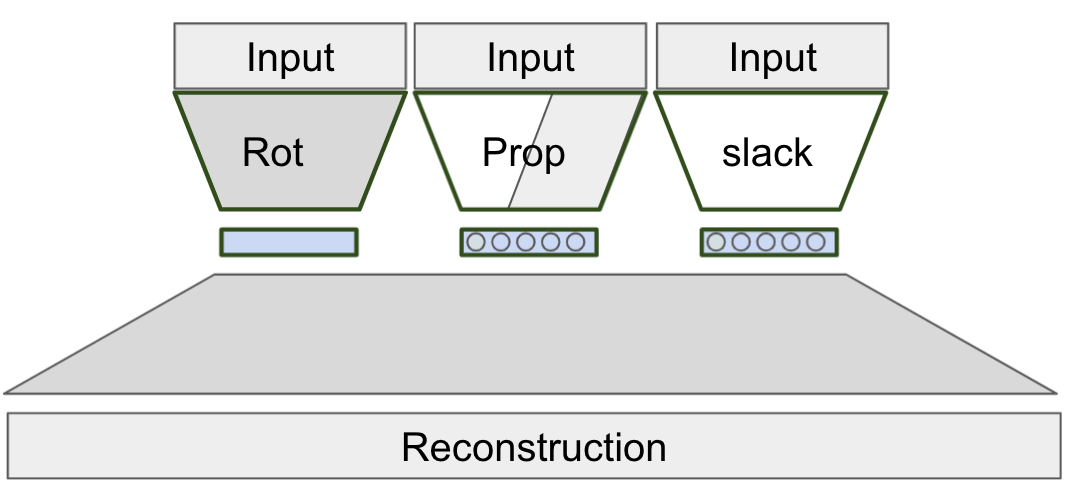

# **Imports**

In [29]:
import pandas as pd


In [30]:
import tensorflow as tf

In [31]:
# general imports
import warnings
import numpy as np
import scanpy as sc

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [32]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [33]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_liver_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_liver/"

de_genes_path = f"{os.getcwd()}/../data/single_cell_data/liver_sex/de_pseudobulk_results.pkl"
de_bulk_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/de_real_bulk_results.pkl"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_liver/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_liver/" +
                        "CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt")


num_genes = 7000

exp_id = "all-liver"

# Set-up experimental variables

In [34]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 51 # 3 "patients", old / young

# number of drugs (one-hot encoded)
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_bulk = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [35]:
in_name = "liver_bulk_processed"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data

# read in male first
sample_order = ['30-M-5']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

# now read in female
sample_order = ['18-F-51']
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    X_concat = pd.concat([X_concat, pseudobulks_df])
    Y_concat = pd.concat([Y_concat, prop_df])
    meta_concat = pd.concat([meta_concat, metadata_df])



# read in the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(15)]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])



30-M-5
18-F-51


<ipython-input-35-87ecae84aa3b>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
<ipython-input-35-87ecae84aa3b>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
<ipython-input-35-87ecae84aa3b>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [36]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6680)[-6680:] # num_genes # 6679
gene_df = gene_df.iloc[idx_top]


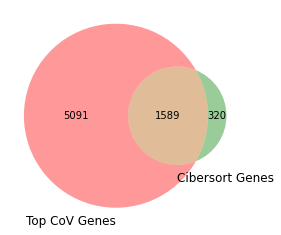

In [37]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [38]:
union_genes = np.union1d(gene_df, cibersort_genes)


In [39]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [40]:
X_full = X_full.loc[:,union_genes]


## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = StandardScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()





In [41]:
X_train

array([[6.04790753e+03, 4.13491679e+03, 3.72671291e+02, ...,
        1.31632535e+03, 2.06216943e+03, 1.76635544e+02],
       [1.29872810e+04, 6.51578699e+03, 1.76391206e+01, ...,
        2.26274923e+03, 1.77538685e+03, 1.00000000e+01],
       [2.70810459e+02, 2.20964577e+03, 2.41347443e+02, ...,
        2.90765409e+03, 2.83329645e+03, 6.61815872e+01],
       ...,
       [0.00000000e+00, 4.00000000e+00, 0.00000000e+00, ...,
        6.40000000e+01, 6.20000000e+01, 0.00000000e+00],
       [6.00000000e+00, 5.20000000e+01, 7.00000000e+00, ...,
        9.70000000e+01, 7.70000000e+01, 0.00000000e+00],
       [3.24600000e+03, 3.13000000e+02, 2.20000000e+01, ...,
        5.65000000e+02, 4.04000000e+02, 1.00000000e+00]])

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3649 samples in 0.014s...
[t-SNE] Computed neighbors for 3649 samples in 0.871s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3649
[t-SNE] Computed conditional probabilities for sample 2000 / 3649
[t-SNE] Computed conditional probabilities for sample 3000 / 3649
[t-SNE] Computed conditional probabilities for sample 3649 / 3649
[t-SNE] Mean sigma: 4.640793
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.750519
[t-SNE] KL divergence after 500 iterations: 0.958058
(3649, 2)
(3649, 2)


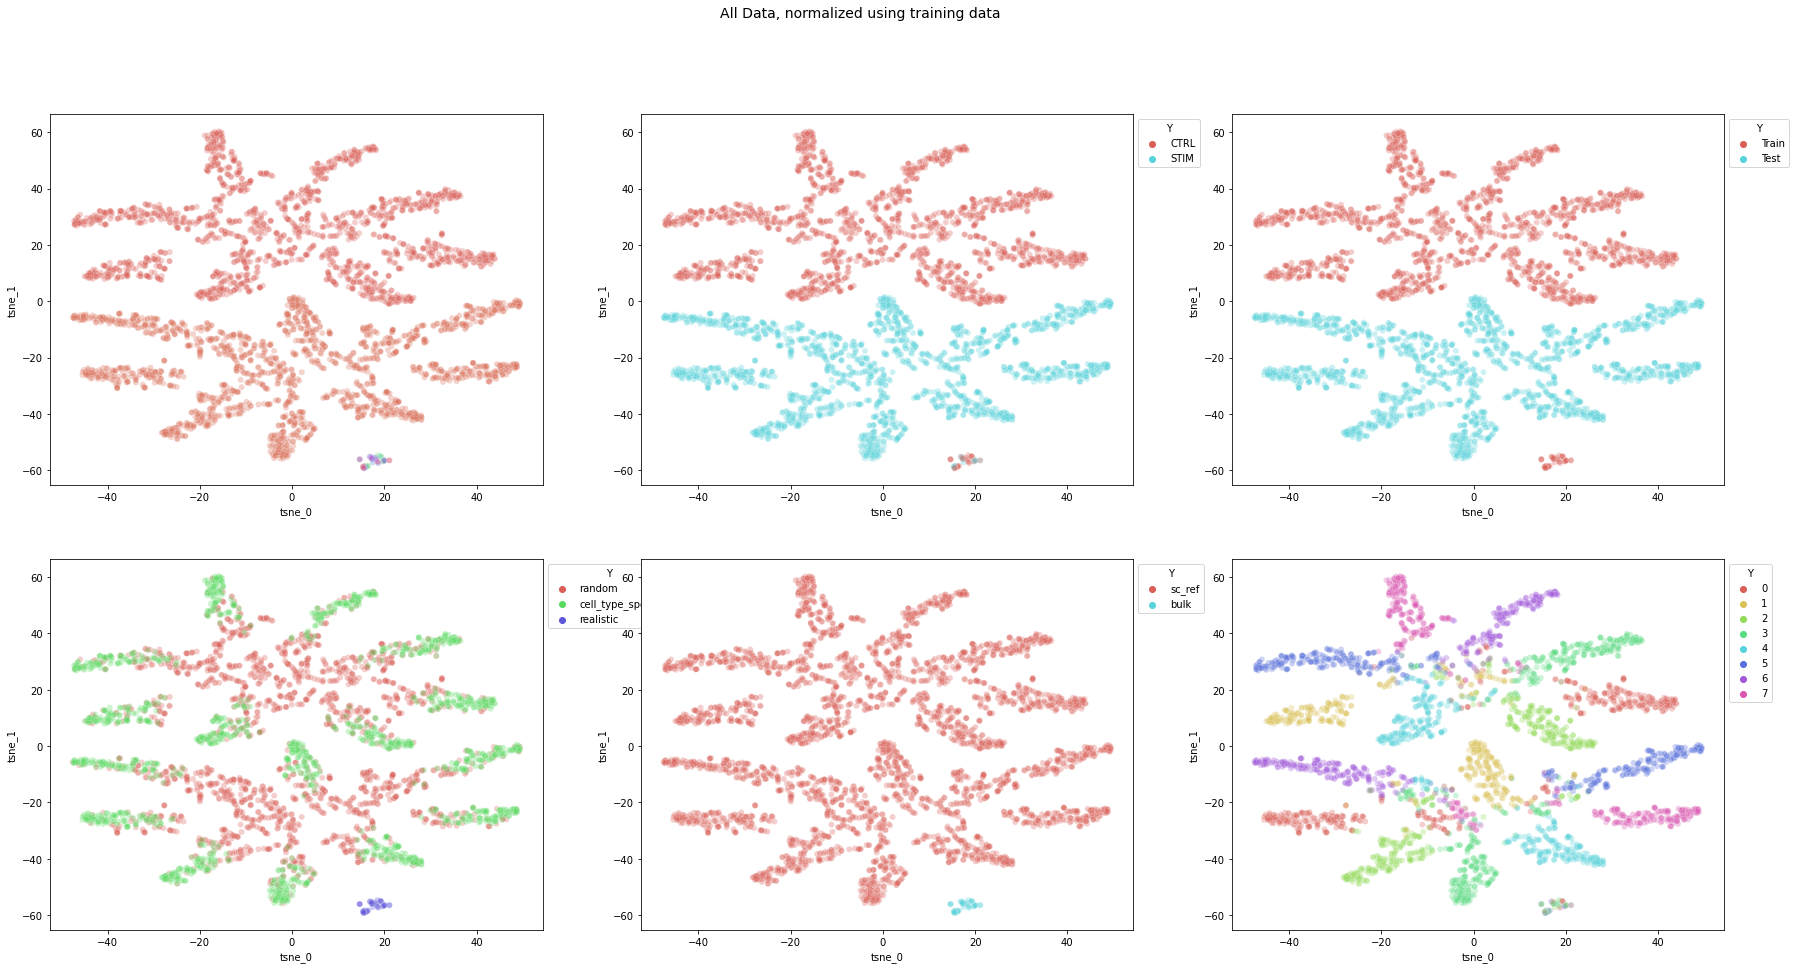

In [42]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **PCA Model Definition**

In [43]:
len(np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type != "bulk"))[0] )

1800

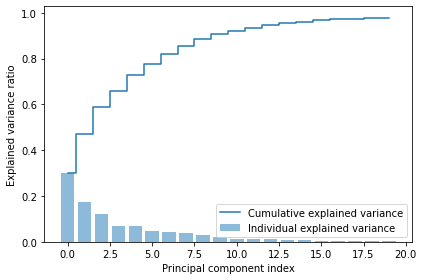

In [44]:
### get training data

idx_bulk_train = np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type == "bulk"))[0] 
X_temp = X_full[idx_bulk_train]

fit = PCA(n_components=20)
pca_results = fit.fit_transform(X_temp)

exp_var_pca = fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

## plot variance explained
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [45]:
Label_full.shape

(3649,)

In [46]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full

recon_idx = np.where(meta_df.isTraining == "Train")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)


Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_temp[recon_idx]
label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the PCA to get the latent space
pca_proj = fit.transform(X_temp)
decoded_outputs = fit.inverse_transform(pca_proj)


(10000, 2)
(10000, 2)


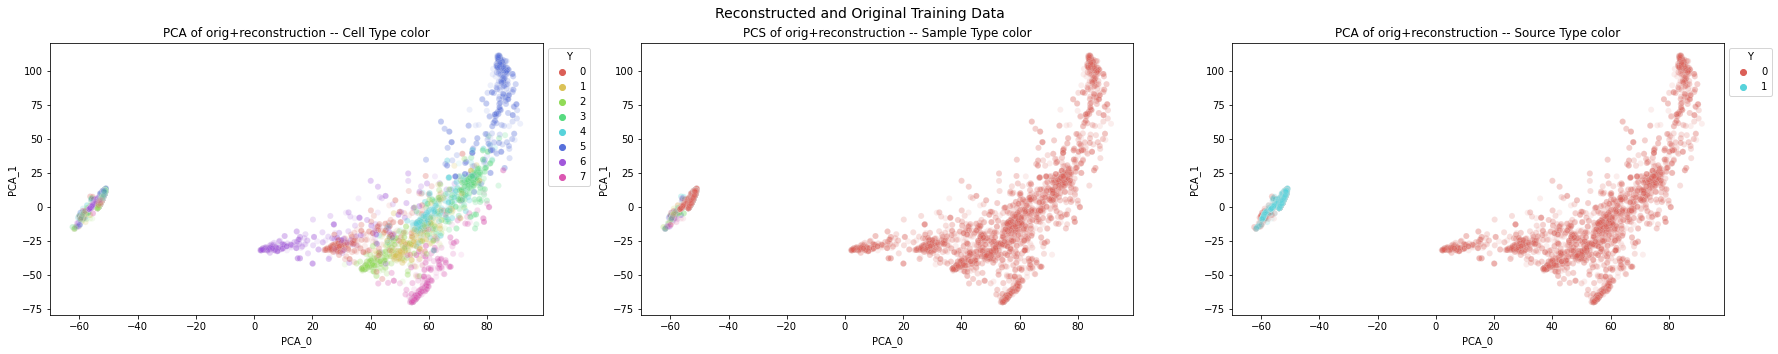

In [47]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

In [48]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full
bulk_temp = bulk_full

recon_idx = np.where(meta_df.isTraining == "Test")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_temp[recon_idx]
label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the PCA to get the latent space
pca_proj = fit.transform(X_temp)
decoded_outputs = fit.inverse_transform(pca_proj)


(10000, 2)
(10000, 2)


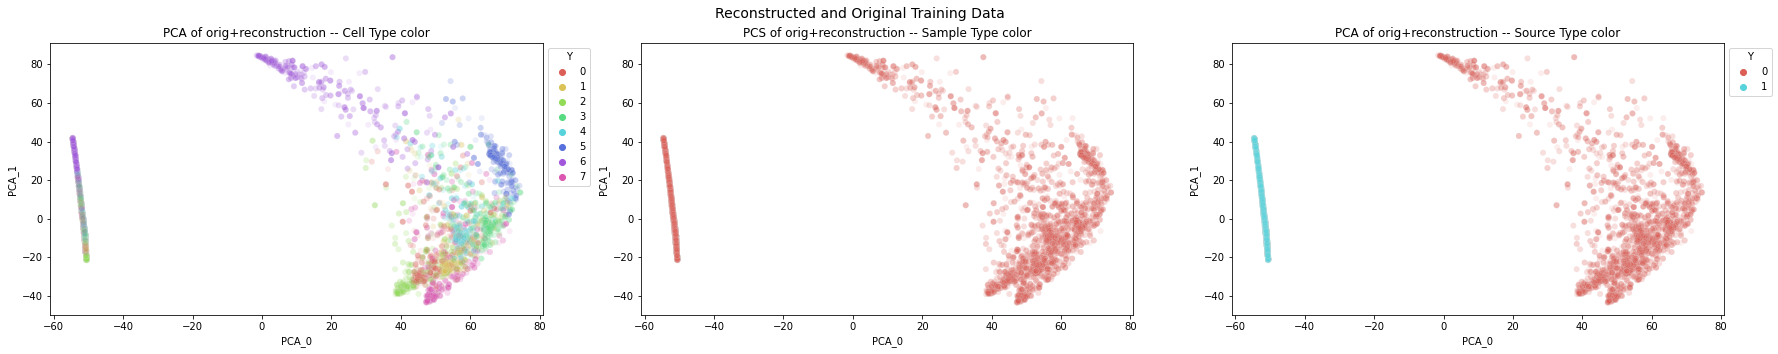

In [49]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

(5000, 2)
(5000, 2)


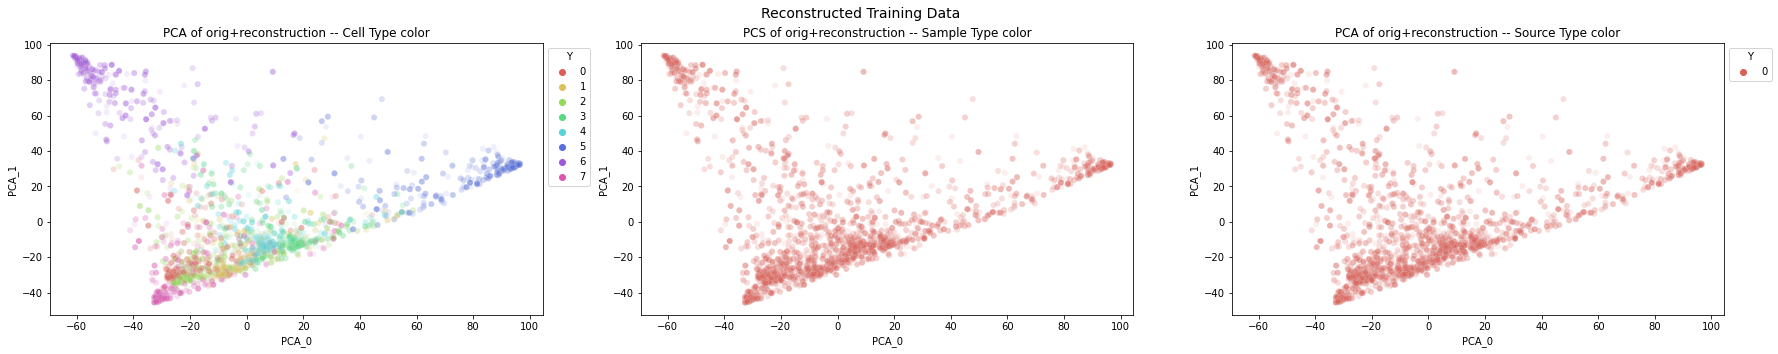

In [52]:

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_num, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=[0]*len(perturb_temp), ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

(5000, 2)
(5000, 2)


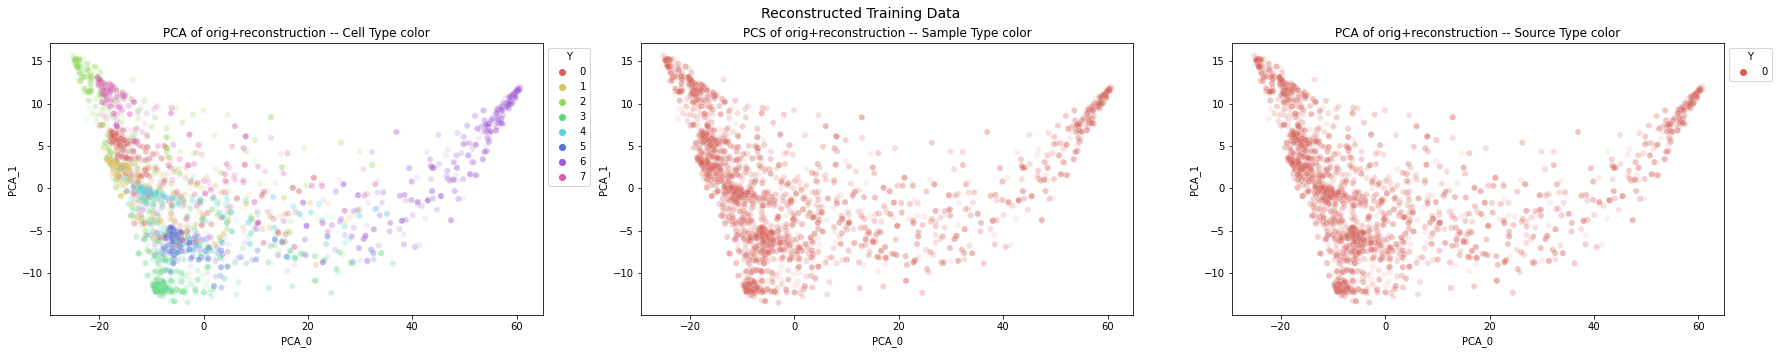

In [53]:

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_num, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=[0]*len(perturb_temp), ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

In [54]:
X_temp

array([[-0.87698414,  1.70114383, -0.21922896, ..., -1.0850276 ,
        -1.41466973, -0.44009245],
       [ 0.3955711 ,  0.04253815, -1.07015959, ...,  0.22183903,
         1.94273454, -0.48833844],
       [-0.80750375,  0.10053636, -0.48457426, ...,  0.93323088,
        -0.16704224, -0.48833844],
       ...,
       [-0.14438162, -0.61905144, -0.63014089, ...,  0.93323088,
         0.23306257,  0.50070437],
       [-0.63364016, -0.04691746, -0.56577897, ...,  0.93323088,
        -0.16779864,  0.23535142],
       [-0.71457762, -0.62742696, -0.82533181, ...,  0.93323088,
         0.76320179, -0.44009245]])

In [55]:
decoded_outputs

array([[-0.55691801, -1.67263631, -0.80091267, ..., -0.92730657,
        -0.64545646, -0.51184929],
       [-0.45488952, -1.64032525, -0.72329256, ..., -0.42066426,
        -0.54053279, -0.50741785],
       [-0.49202339, -1.65672681, -0.78645019, ..., -0.78219903,
        -0.63443172, -0.50953561],
       ...,
       [-0.29036357, -1.64799481, -0.78588306, ..., -0.83408224,
        -0.65081298, -0.50982766],
       [-0.45783771, -1.65516684, -0.78594245, ..., -0.76099597,
        -0.63029846, -0.5098119 ],
       [-0.40459473, -1.64828795, -0.75064924, ..., -0.69927481,
        -0.60230876, -0.50949125]])

## Do latent space projectsions

### drug perturbation

In [ ]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)


<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [59]:
def get_sex_transform_vec_PCA(X_full, meta_df, fit):
    # get the perturbation latent code
    idx_start_train = np.logical_and(meta_df.stim == "CTRL", meta_df.isTraining == "Train")
    idx_start_train = np.logical_and(idx_start_train, meta_df.samp_type == "bulk")
    idx_start_train = np.where(idx_start_train)[0]


    idx_end_train = np.logical_and(meta_df.stim == "STIM", meta_df.isTraining == "Train")
    idx_end_train = np.logical_and(idx_end_train, meta_df.samp_type == "bulk")
    idx_end_train = np.where(idx_end_train)[0]

    X_start = X_full[idx_start_train]
    train_start = fit.transform(X_start)

    X_end = X_full[idx_end_train]
    train_end = fit.transform(X_end)


    train_start_med = np.median(train_start, axis=0)
    train_end_med = np.median(train_end, axis=0)

    proj_train = train_start_med - train_end_med
    return(proj_train)



In [60]:

def calc_PCA_perturbation(X_full, meta_df, scaler, fit):

    # get the perturbation latent code
    idx_sc_ref = np.logical_and(meta_df.stim == "CTRL", meta_df.isTraining == "Train")
    idx_sc_ref = np.logical_and(idx_sc_ref, meta_df.cell_prop_type == "cell_type_specific")
    idx_sc_ref = np.where(idx_sc_ref)[0]

    # get metadata
    sc_ref_meta_df = meta_df.iloc[idx_sc_ref]

    # get input data
    X_sc_ref = np.copy(X_full)
    X_sc_ref = X_sc_ref[idx_sc_ref,]

    ## get the transofrmation vector
    proj_vec = get_sex_transform_vec_PCA(X_full, meta_df, fit)


    # now get the refernce sample that we will use to do all projectsions
    decoded_0_0 = fit.transform(X_sc_ref)
    decoded_0_1 = np.copy(decoded_0_0)


    # do the projections
    decoded_0_1 = decoded_0_0 + proj_vec

    # fit
    decoded_0_1 = fit.inverse_transform(decoded_0_1)
    decoded_0_1 = scaler.inverse_transform(decoded_0_1)

    decoded_0_0 = fit.inverse_transform(decoded_0_0)
    decoded_0_0 = scaler.inverse_transform(decoded_0_0)

    return (sc_ref_meta_df, decoded_0_0, decoded_0_1)


In [61]:



ctrl_test_meta_df, decoded_0_0, decoded_0_1 = calc_PCA_perturbation(X_full, meta_df, scaler, fit)
decoded_0_1 = np.clip(decoded_0_1, 0, clip_upper)
decoded_0_0 = np.clip(decoded_0_0, 0, clip_upper)


(1600, 2)
(1600, 2)


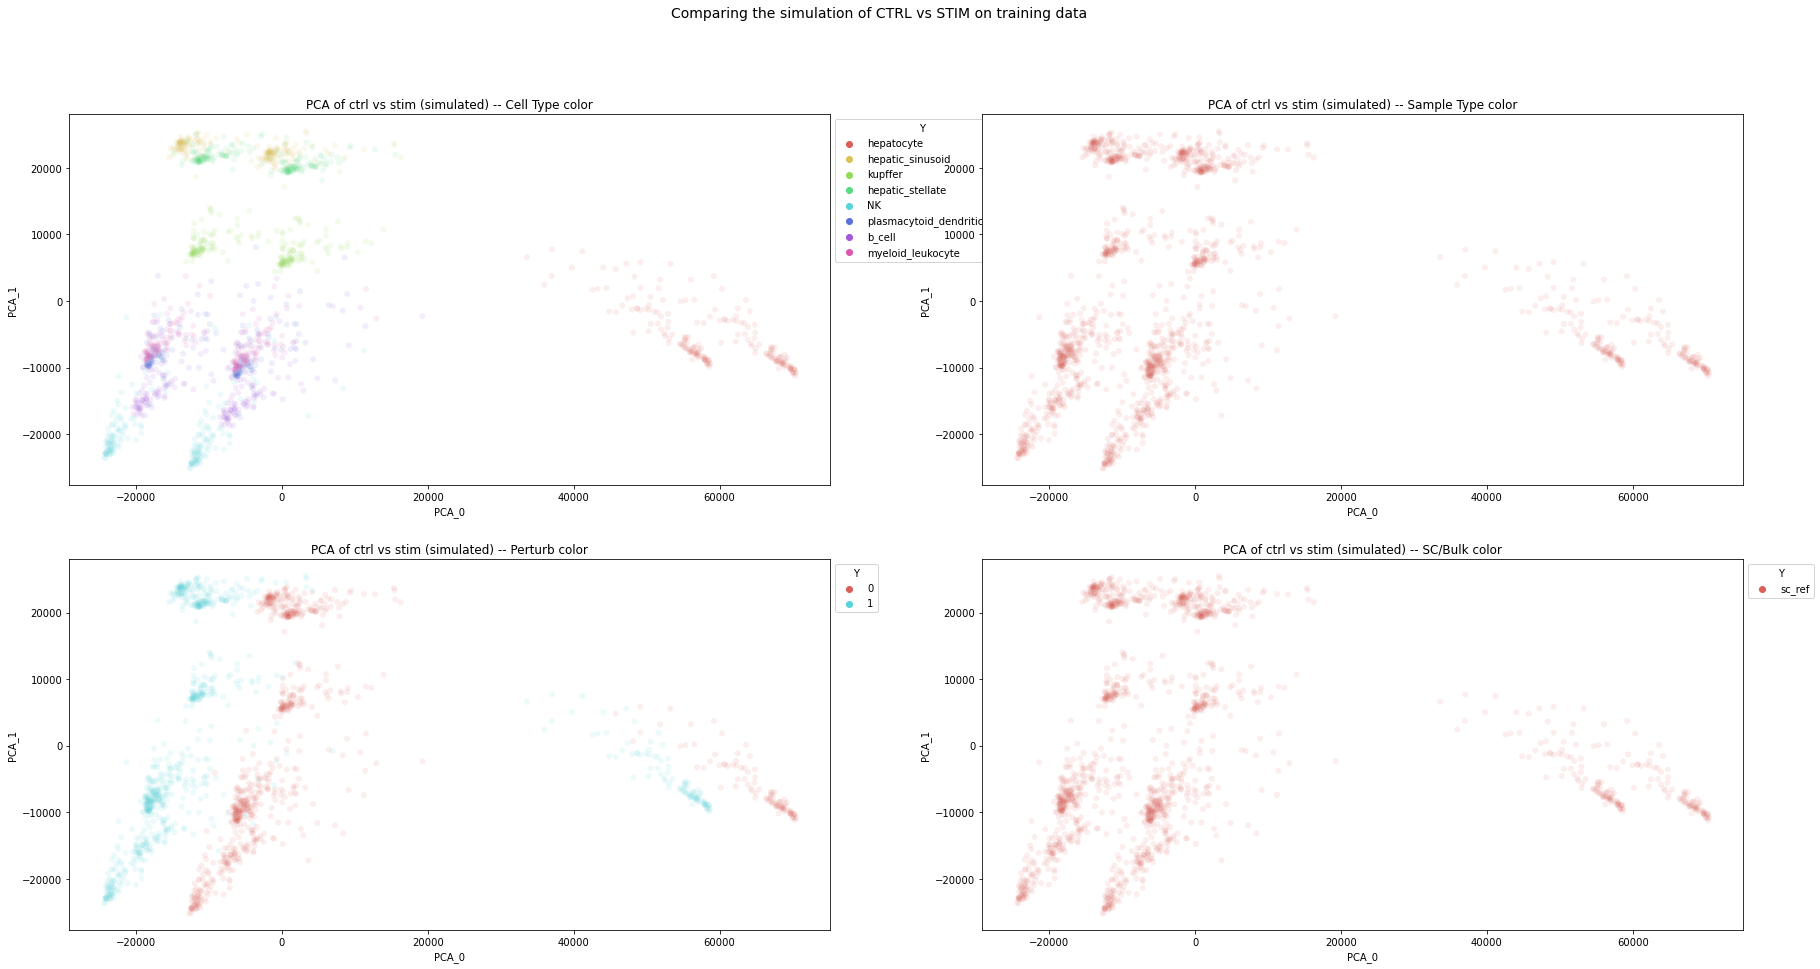

In [62]:
# make duplicated
X_dup = np.vstack([decoded_0_0, decoded_0_1])


Y_dup = np.append(ctrl_test_meta_df.Y_max, ctrl_test_meta_df.Y_max)


label_dup = np.append(ctrl_test_meta_df.sample_id, ctrl_test_meta_df.sample_id)

n_row_temp = ctrl_test_meta_df.shape[0]
perturb_dup = np.asarray(np.append([0]*n_row_temp, [1]*n_row_temp))
source_dup = np.append(ctrl_test_meta_df.samp_type, ctrl_test_meta_df.samp_type)

fig, axs = plt.subplots(2, 2, figsize=(30,15))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0,0], title="PCA of ctrl vs stim (simulated) -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[0,1], title="PCA of ctrl vs stim (simulated) -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_dup, ax=axs[1,0], title="PCA of ctrl vs stim (simulated) -- Perturb color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[1,1], title="PCA of ctrl vs stim (simulated) -- SC/Bulk color")



fig.suptitle("Comparing the simulation of CTRL vs STIM on training data", fontsize=14)
axs[0,1].legend([],[], frameon=False)

fig.show()

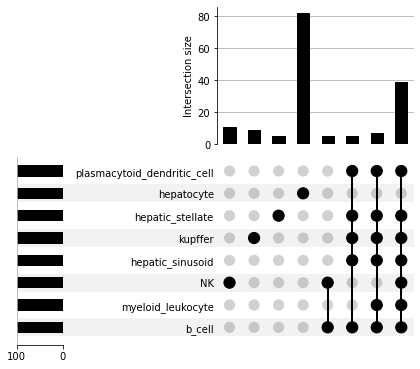

In [63]:
from scipy.stats import rankdata


top_lim = 100

top_genes = {}
de_genes_all = None
for curr_cell_type in Y_full.columns:


    # this is for the "projected" expression
    curr_idx = np.where(ctrl_test_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization

    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    #proj_ctrl = np.median(proj_ctrl, axis=0)
    #proj_stim = np.median(proj_stim, axis=0)
    proj_log2FC = np.abs(proj_stim-proj_ctrl)

    # make into DF
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes)

    intersect_proj = proj_log2FC_df.loc[union_genes][0]
    top_proj_genes = intersect_proj.index[np.argsort(np.abs(intersect_proj))].tolist()[::-1][0:top_lim]

    top_genes[curr_cell_type] = top_proj_genes


cell_diff = from_contents(top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

#venn2([set(top_pub_genes), set(top_proj_genes)], set_labels = ('Top Pub Genes', 'Top Proj Genes'))
#plt.show()


In [65]:
top_genes["hepatocyte"]

['Slc1a5',
 'Lipe',
 'Cav1',
 'Prkar2b',
 'Adrb3',
 'Anxa2',
 'Ckb',
 'Atp2a1',
 'Ahnak',
 'Acta2',
 'Slc1a3',
 'Lpl',
 'Acta1',
 'Slc27a1',
 'Col6a1',
 'Cav2',
 'Timp2',
 'Lamb2',
 'Ltbp3',
 'Prnp',
 'Fabp4',
 'Lamc1',
 'Myl9',
 'Pygm',
 'Tpm2',
 'Col6a2',
 'Prss2',
 'Cela2a',
 'Ckm',
 'Ttn',
 'Zeb2',
 'Sycn',
 'Ctrl',
 'Ano6',
 'Slc27a4',
 '2210010C04Rik',
 'Try4',
 'Ctrb1',
 'Mxd1',
 'Kif5a',
 'Rasd1',
 'Cpb1',
 'Prss23',
 'Syn1',
 'Rasgrf1',
 'Npdc1',
 'Col4a1',
 'Celf4',
 'Sept3',
 'Vdr',
 'Ins2',
 'Slc22a17',
 'Nsg1',
 'Tubb3',
 'Pcsk1n',
 'Prkar1b',
 'Gpm6a',
 'Hspg2',
 'Syp',
 'Ins1',
 'Aplp1',
 'Ryr1',
 'Lgals4',
 'Enpp2',
 'Tmod2',
 'Plp1',
 'Klhl2',
 'Ezr',
 'Plcb3',
 'Nos3',
 'Sh3tc1',
 'Phactr1',
 'Slc12a5',
 'Adam15',
 'Pnpla3',
 'Slc28a2',
 'Ppp2r2c',
 'Tgfbr3',
 'Ptprs',
 'Gnb5',
 'Fabp2',
 'Myzap',
 'Col4a2',
 'Cdk14',
 'Tnnt3',
 'Sparcl1',
 'Pea15a',
 'Rtn1',
 'Crmp1',
 'Igfbp5',
 'Kctd17',
 'Try5',
 'Tmem38a',
 'Zcchc18',
 'Lgals1',
 'Sept8',
 'Tnni2',
 'Actn2',
 'Se

In [64]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

def plot_effect_size_corr(xval, yval, ax, title, xlab, ylab, class_id, style_id, alpha=0.5):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id,
        alpha= alpha,
        style=style_id
    )
    #g.set(ylim=(min_val, max_val))
    #g.set(xlim=(min_val, max_val))
    #g.plot([min_val, max_val], [min_val, max_val], transform=g.transAxes)
    sns.set_palette("Set2")

    ax.set_title(title)
    return g


In [66]:

union_genes_cap = [x.upper() for x in union_genes]

Pub_male_DE = ["CSMD1", "GALNT15", "NC_INTER_C14_25214", "NC_INTER_C19_31822", "NC_INTER_C6_41991", "NC_INTRA_C4_39314", "TRPC3", "APOE", "CLEC4A3", "HSD17B13", "ITIH4", "PIM3", "2310040G07RIK", "5330417C22RIK", "ACYP1", "ADAM11", "ADAMTS7", "AK4", "AMDHD2", "ANKRD31", "ARRDC3", "ASNS", "ATG16L2", "ATP8B4", "BMP7", "CAPN8", "CCDC146", "CDH2", "CIDEC", "CLN6", "CLSTN3", "CNNM1", "CRIM1", "CTSZ", "CYP1A2", "CYP2A5", "CYP2C55", "CYP2D12", "CYP2F2", "CYP2J9", "CYP3A59", "DDIT3", "DMAC2", "EPHB4", "ESCO2", "ESRRA", "ETNPPL", "EVA1A", "EXTL1", "F2RL2", "FBXO31", "FKBP11", "FST", "FTCD", "GAS2", "GBE1", "GDF15", "GM13238", "GM17090", "GM17276", "GM28172", "GM29650", "GM32250", "GM39325", "GM44623", "GM45051", "GM5930", "GSE1", "GSTA3", "GUCY2C", "GYS2", "HMOX1", "HNMT", "KCNK5", "KLHDC7A", "LMOD2", "LRP4", "MAB21L3", "MARCKSL1-PS4", "MEIG1", "MTNR1A", "MUP10", "MUP14", "MUP2", "MUP7", "NAT8", "NAT8F5", "NAT8F6", "NC_AS_C10_19571", "NC_AS_C10_8460", "NC_AS_C10_8856", "NC_AS_C10_9138", "NC_AS_C11_10136", "NC_AS_C11_21133", "NC_AS_C11_9866", "NC_AS_C12_10529", "NC_AS_C12_10778", "NC_AS_C13_11022", "NC_AS_C13_11425", "NC_AS_C13_23293", "NC_AS_C14_25013", "NC_AS_C15_12697", "NC_AS_C15_12848", "NC_AS_C15_12874", "NC_AS_C16_28194", "NC_AS_C17_13820", "NC_AS_C17_14024", "NC_AS_C17_29673", "NC_AS_C19_14844", "NC_AS_C19_15130", "NC_AS_C2_1233", "NC_AS_C2_1543", "NC_AS_C2_1778", "NC_AS_C2_1965", "NC_AS_C2_35105", "NC_AS_C3_2800", "NC_AS_C4_3532", "NC_AS_C4_3897", "NC_AS_C5_4051", "NC_AS_C5_41104", "NC_AS_C5_41479", "NC_AS_C5_41482", "NC_AS_C5_41483", "NC_AS_C5_4237", "NC_AS_C5_4257", "NC_AS_C5_4613", "NC_AS_C5_4719", "NC_AS_C6_43055", "NC_AS_C6_43544", "NC_AS_C6_4824", "NC_AS_C6_5604", "NC_AS_C6_5718", "NC_AS_C7_44087", "NC_AS_C7_45051", "NC_AS_C7_5921", "NC_AS_C7_5965", "NC_AS_C7_6065", "NC_AS_C7_6204", "NC_AS_C7_6377", "NC_AS_C8_46875", "NC_AS_C8_47354", "NC_AS_C8_7337", "NC_INTER_C1_1001", "NC_INTER_C1_166", "NC_INTER_C1_17618", "NC_INTER_C1_196", "NC_INTER_C1_274", "NC_INTER_C1_366", "NC_INTER_C1_406", "NC_INTER_C1_526", "NC_INTER_C1_588", "NC_INTER_C1_924", "NC_INTER_C1_931", "NC_INTER_C1_976", "NC_INTER_C10_17923", "NC_INTER_C10_19012", "NC_INTER_C10_19427", "NC_INTER_C10_19433", "NC_INTER_C10_19436", "NC_INTER_C10_19600", "NC_INTER_C10_8690", "NC_INTER_C10_8881", "NC_INTER_C10_9302", "NC_INTER_C10_9350", "NC_INTER_C11_10078", "NC_INTER_C11_10159", "NC_INTER_C11_10162", "NC_INTER_C11_10218", "NC_INTER_C11_19811", "NC_INTER_C11_20045", "NC_INTER_C11_20750", "NC_INTER_C11_20754", "NC_INTER_C11_21059", "NC_INTER_C11_21271", "NC_INTER_C11_21634", "NC_INTER_C12_10243", "NC_INTER_C12_10273", "NC_INTER_C12_10276", "NC_INTER_C12_10445", "NC_INTER_C12_10644", "NC_INTER_C12_10925", "NC_INTER_C12_21741", "NC_INTER_C12_21747", "NC_INTER_C12_21907", "NC_INTER_C12_22126", "NC_INTER_C13_11141", "NC_INTER_C13_11226", "NC_INTER_C13_11236", "NC_INTER_C13_11562", "NC_INTER_C13_23241", "NC_INTER_C13_23567", "NC_INTER_C14_12201", "NC_INTER_C14_25326", "NC_INTER_C14_25422", "NC_INTER_C14_25970", "NC_INTER_C15_12341", "NC_INTER_C15_26385", "NC_INTER_C15_26545", "NC_INTER_C15_26737", "NC_INTER_C15_27072", "NC_INTER_C15_27197", "NC_INTER_C15_27246", "NC_INTER_C15_27604", "NC_INTER_C15_27605", "NC_INTER_C16_13168", "NC_INTER_C16_13481", "NC_INTER_C16_28109", "NC_INTER_C16_28214", "NC_INTER_C16_28305", "NC_INTER_C16_28503", "NC_INTER_C17_13938", "NC_INTER_C17_14087", "NC_INTER_C17_14113", "NC_INTER_C17_29151", "NC_INTER_C17_29437", "NC_INTER_C17_29461", "NC_INTER_C18_30929", "NC_INTER_C18_31338", "NC_INTER_C18_31396", "NC_INTER_C19_14758", "NC_INTER_C19_14967", "NC_INTER_C19_15004", "NC_INTER_C19_15182", "NC_INTER_C19_31671", "NC_INTER_C19_32377", "NC_INTER_C19_32381", "NC_INTER_C19_32383", "NC_INTER_C19_32539", "NC_INTER_C2_1121", "NC_INTER_C2_1161", "NC_INTER_C2_2000", "NC_INTER_C2_33152", "NC_INTER_C2_33876", "NC_INTER_C3_2168", "NC_INTER_C3_2630", "NC_INTER_C3_2797", "NC_INTER_C3_2922", "NC_INTER_C3_2942", "NC_INTER_C3_35342", "NC_INTER_C3_35348", "NC_INTER_C3_35349", "NC_INTER_C3_35359", "NC_INTER_C3_35556", "NC_INTER_C3_36231", "NC_INTER_C3_36265", "NC_INTER_C3_37079", "NC_INTER_C3_37178", "NC_INTER_C4_3086", "NC_INTER_C4_3533", "NC_INTER_C4_3549", "NC_INTER_C4_3579", "NC_INTER_C4_3775", "NC_INTER_C4_37854", "NC_INTER_C4_38023", "NC_INTER_C4_38403", "NC_INTER_C4_38427", "NC_INTER_C4_38509", "NC_INTER_C4_39163", "NC_INTER_C5_39934", "NC_INTER_C5_40222", "NC_INTER_C5_4048", "NC_INTER_C5_4055", "NC_INTER_C5_40800", "NC_INTER_C5_41123", "NC_INTER_C5_41259", "NC_INTER_C5_41621", "NC_INTER_C5_4379", "NC_INTER_C5_4474", "NC_INTER_C5_4651", "NC_INTER_C5_4788", "NC_INTER_C5_4819", "NC_INTER_C6_41969", "NC_INTER_C6_41970", "NC_INTER_C6_5193", "NC_INTER_C6_5309", "NC_INTER_C6_5310", "NC_INTER_C6_5316", "NC_INTER_C6_5846", "NC_INTER_C6_5862", "NC_INTER_C7_43801", "NC_INTER_C7_43842", "NC_INTER_C7_43873", "NC_INTER_C7_44280", "NC_INTER_C7_45606", "NC_INTER_C7_45613", "NC_INTER_C7_45614", "NC_INTER_C7_6068", "NC_INTER_C7_6094", "NC_INTER_C7_6294", "NC_INTER_C7_6392", "NC_INTER_C7_6508", "NC_INTER_C7_6509", "NC_INTER_C7_6595", "NC_INTER_C8_45937", "NC_INTER_C8_47239", "NC_INTER_C8_47251", "NC_INTER_C8_6944", "NC_INTER_C8_7176", "NC_INTER_C8_7350", "NC_INTER_C8_7605", "NC_INTER_C8_7610", "NC_INTER_C9_48130", "NC_INTER_C9_48783", "NC_INTER_C9_49383", "NC_INTER_C9_7885", "NC_INTER_C9_7892", "NC_INTER_C9_8122", "NC_INTER_CX_49514", "NC_INTER_CX_50093", "NC_INTER_CX_50188", "NC_INTER_CY_50499", "NC_INTRA_C1_16454", "NC_INTRA_C16_28090", "NC_INTRA_C4_38600", "NHEJ1", "NRG4", "PAK6", "PAX8", "PCGF2", "PDGFA", "PELI3", "PFKFB3", "PKDREJ", "PKNOX2", "PLD6", "PPARGC1B", "PREX2", "PROCA1", "PTCH2", "PXYLP1", "R3HDML", "RAB3D", "RANBP17", "Ranbp3l", "RAP2A", "RBMS2", "RENBP", "RIBC1", "RIPOR2", "RPS6KA1", "RUNDC3B", "SCARB1", "SCN1B", "SEC22C", "SERPINA12", "SERPINE2", "SH3BGRL2", "SH3RF1", "SIPA1L2", "SLC18A2", "SLC22A22", "SLC22A4", "SLC24A5", "SLC2A5", "SLC35E3", "SPAG16", "SULT2A8", "SUSD4", "TAFA2", "TC2N", "THRSP", "TIMM9", "TOMM40L", "TRIB3", "TXNDC5", "VCL", "VEGFD", "WNK4", "ZBTB12", "ZFR2", "ABCB1B", "ANK1", "APBA2", "BDH2", "BDNF", "BID", "BIRC5", "BMP4", "BRINP3", "CCDC151", "CCDC152", "CCDC158", "CERS5", "COL4A2", "CRYM", "DAB1", "DNAH8", "ENPP3", "EPB41L1", "EPHB6", "EZR", "GAL3ST1", "GM10701", "GM14146", "GRM7", "GTSE1", "HS1BP3", "HSD3B2", "IHH", "KEG1", "LRRC14B", "METTL7A1", "MUP1", "MUP11", "NC_AS_C1_16117", "NC_AS_C1_221", "NC_AS_C10_9290", "NC_AS_C10_9351", "NC_AS_C11_10168", "NC_AS_C11_10193", "NC_AS_C11_10227", "NC_AS_C13_11185", "NC_AS_C14_11991", "NC_AS_C14_12074", "NC_AS_C14_12111", "NC_AS_C2_33533", "NC_AS_C4_3824", "NC_AS_C7_6162", "NC_INTER_C1_1038", "NC_INTER_C1_15751", "NC_INTER_C1_17121", "NC_INTER_C10_18779", "NC_INTER_C10_8745", "NC_INTER_C10_8846", "NC_INTER_C11_10211", "NC_INTER_C11_10213", "NC_INTER_C11_19797", "NC_INTER_C11_9434", "NC_INTER_C12_10431", "NC_INTER_C13_11090", "NC_INTER_C13_23303", "NC_INTER_C13_24436", "NC_INTER_C14_11858", "NC_INTER_C14_11989", "NC_INTER_C14_24999", "NC_INTER_C15_12954", "NC_INTER_C15_27082", "NC_INTER_C16_13185", "NC_INTER_C16_13421", "NC_INTER_C16_28146", "NC_INTER_C17_13568", "NC_INTER_C17_14025", "NC_INTER_C18_14330", "NC_INTER_C19_14874", "NC_INTER_C3_2413", "NC_INTER_C3_2733", "NC_INTER_C3_2895", "NC_INTER_C3_35370", "NC_INTER_C3_35424", "NC_INTER_C4_3471", "NC_INTER_C4_3794", "NC_INTER_C4_38029", "NC_INTER_C4_38331", "NC_INTER_C4_38853", "NC_INTER_C5_39709", "NC_INTER_C5_41620", "NC_INTER_C6_42157", "NC_INTER_C6_42580", "NC_INTER_C6_43331", "NC_INTER_C6_43700", "NC_INTER_C6_4868", "NC_INTER_C7_43894", "NC_INTER_C7_43994", "NC_INTER_C7_44119", "NC_INTER_C7_44889", "NC_INTER_C7_5922", "NC_INTER_C7_6558", "NC_INTER_C8_46126", "NC_INTER_C8_47237", "NC_INTER_C8_47241", "NC_INTER_C8_7259", "NC_INTER_C8_7273", "NC_INTER_C9_47875", "NC_INTER_C9_49372", "NC_INTER_CX_50211", "NC_INTRA_C12_22588", "NC_INTRA_C3_2640", "NC_INTRA_C3_35408", "NC_INTRA_C5_4750", "NCAM2", "P2RX4", "PDE6A", "PER3", "PGP", "PIP5K1B", "PLCB4", "PLEKHF1", "POGK", "PPFIA3", "PPP1R42", "PRDM16", "RNF227", "SEL1L3", "SELENBP2", "SLC12A3", "SLC39A11", "SLC8A3", "SPACA6", "STEAP4", "TLE3", "TMEM19", "TNFSF15", "TRHDE", "TTC7B", "UGT2B36", "UNC119", "VMN2R22", "XLR3A", "ZFP37", "ZYG11A", "ADAMTSL2", "NC_INTER_C2_33847", "OLFR39", "OLFR872", "PLXDC2", "MYO5A", "NC_INTER_C11_10188", "1600014C10RIK", "1810064F22RIK", "2610507I01RIK", "A930033H14RIK", "AA986860", "ABCG2", "ABCG8", "ADGRV1", "ADORA1", "AKR1C19", "ALAS2", "ALPL", "ANG4", "AOX1", "AOX3", "ARL3", "ARSA", "BCL6", "BHLHE41", "C6", "C8A", "C8B", "C9", "CABYR", "CAMK2B", "CAR3", "CDC42EP1", "CES1F", "CFAP53", "CHPT1", "CHRM3", "CIART", "CIB3", "CLEC2H", "COL27A1", "COL5A3", "CREG1", "CRYL1", "CSAD", "CSPG5", "CTSE", "CXCL1", "CYP2C23", "CYP2D9", "CYP2U1", "CYP3A25", "CYP4A12A", "CYP4A12B", "DBP", "DDX3Y", "DIO1", "DSG1C", "EIF2S3Y", "ELOVL3", "ENPP6", "EPHX1", "FAM171B", "FHITOS", "FITM1", "FMO5", "FTL1", "GCK", "GCLC", "GM11967", "GM19951", "Gm21064", "GM34408", "GM38102", "GM39469", "GM47551", "GNA14", "GPR155", "GSTA2", "GSTM1", "GSTP1", "HAMP", "HERPUD1", "HES6", "HSD3B5", "IL1R1", "IL1RAP", "KDM5D", "KLF13", "LAMA3", "LNC-LFAR1", "LOC102631993", "LPL", "MAP2K6", "MAPK4", "MBD1", "MBNL2", "MCM10", "MN1", "MT1", "MTHFD1L", "MUP12", "MUP13", "MUP16", "MUP17", "MUP20", "MUP21", "Mup22", "MUP3", "MUP9", "NAT8F2", "NC_AS_C1_103", "NC_AS_C1_16455", "NC_AS_C1_222", "NC_AS_C1_252", "NC_AS_C1_367", "NC_AS_C1_419", "NC_AS_C1_645", "NC_AS_C10_18831", "NC_AS_C11_10090", "NC_AS_C11_20789", "NC_AS_C12_10800", "NC_AS_C13_23641", "NC_AS_C15_12340", "NC_AS_C15_12817", "NC_AS_C15_12818", "NC_AS_C17_13708", "NC_AS_C17_13924", "NC_AS_C17_29511", "NC_AS_C18_14287", "NC_AS_C18_14596", "NC_AS_C19_14823", "NC_AS_C2_1101", "NC_AS_C2_1339", "NC_AS_C3_2474", "NC_AS_C3_2633", "NC_AS_C3_2894", "NC_AS_C4_3288", "NC_AS_C4_3297", "NC_AS_C4_3300", "NC_AS_C4_3559", "NC_AS_C4_38502", "NC_AS_C5_41477", "NC_AS_C5_41478", "NC_AS_C5_41480", "NC_AS_C6_5601", "NC_AS_C7_6100", "NC_AS_C7_6302", "NC_AS_C8_7331", "NC_AS_C8_7359", "NC_AS_C9_48159", "NC_AS_CX_15436", "NC_INTER_C1_15752", "NC_INTER_C1_17117", "NC_INTER_C1_17119", "NC_INTER_C1_365", "NC_INTER_C1_630", "NC_INTER_C1_636", "NC_INTER_C10_18780", "NC_INTER_C10_18890", "NC_INTER_C10_19650", "NC_INTER_C10_8999", "NC_INTER_C10_9000", "NC_INTER_C10_9349", "NC_INTER_C11_10109", "NC_INTER_C11_10215", "NC_INTER_C11_20471", "NC_INTER_C11_21358", "NC_INTER_C11_21411", "NC_INTER_C11_9924", "NC_INTER_C11_9926", "NC_INTER_C12_10419", "NC_INTER_C12_10423", "NC_INTER_C12_10462", "NC_INTER_C12_10973", "NC_INTER_C13_11221", "NC_INTER_C13_11665", "NC_INTER_C13_11669", "NC_INTER_C13_11670", "NC_INTER_C13_11769", "NC_INTER_C13_23227", "NC_INTER_C13_24759", "NC_INTER_C14_11820", "NC_INTER_C14_12199", "NC_INTER_C14_25003", "NC_INTER_C14_25517", "NC_INTER_C15_12324", "NC_INTER_C15_12436", "NC_INTER_C15_26512", "NC_INTER_C15_27100", "NC_INTER_C15_27619", "NC_INTER_C16_13211", "NC_INTER_C16_27915", "NC_INTER_C17_13939", "NC_INTER_C17_13983", "NC_INTER_C17_13987", "NC_INTER_C17_14010", "NC_INTER_C17_30317", "NC_INTER_C17_30318", "NC_INTER_C18_14328", "NC_INTER_C18_14341", "NC_INTER_C18_30753", "NC_INTER_C18_30760", "NC_INTER_C18_30872", "NC_INTER_C18_31487", "NC_INTER_C19_14746", "NC_INTER_C19_14822", "NC_INTER_C19_14873", "NC_INTER_C19_31686", "NC_INTER_C19_31755", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C2_33955", "NC_INTER_C2_34787", "NC_INTER_C2_35077", "NC_INTER_C3_2156", "NC_INTER_C3_2410", "NC_INTER_C3_2411", "NC_INTER_C3_2504", "NC_INTER_C3_2988", "NC_INTER_C3_35415", "NC_INTER_C3_36176", "NC_INTER_C3_36400", "NC_INTER_C3_36463", "NC_INTER_C3_36914", "NC_INTER_C3_37077", "NC_INTER_C3_37078", "NC_INTER_C4_3468", "NC_INTER_C4_37486", "NC_INTER_C4_38016", "NC_INTER_C4_38021", "NC_INTER_C4_38024", "NC_INTER_C4_38026", "NC_INTER_C4_38027", "NC_INTER_C4_38028", "NC_INTER_C4_38488", "NC_INTER_C4_38503", "NC_INTER_C4_38506", "NC_INTER_C4_39237", "NC_INTER_C5_40535", "NC_INTER_C5_40777", "NC_INTER_C5_40778", "NC_INTER_C5_41212", "NC_INTER_C5_41624", "NC_INTER_C5_4376", "NC_INTER_C5_4405", "NC_INTER_C5_4464", "NC_INTER_C5_4467", "NC_INTER_C5_4616", "NC_INTER_C5_4639", "NC_INTER_C6_41966", "NC_INTER_C6_43708", "NC_INTER_C6_4887", "NC_INTER_C6_5025", "NC_INTER_C6_5277", "NC_INTER_C6_5551", "NC_INTER_C6_5711", "NC_INTER_C6_5864", "NC_INTER_C7_43892", "NC_INTER_C7_44316", "NC_INTER_C7_44356", "NC_INTER_C7_44357", "NC_INTER_C7_45335", "NC_INTER_C7_6073", "NC_INTER_C7_6074", "NC_INTER_C7_6076", "NC_INTER_C8_46989", "NC_INTER_C8_46996", "NC_INTER_C8_47253", "NC_INTER_C8_6876", "NC_INTER_C8_6981", "NC_INTER_C8_6984", "NC_INTER_C8_6985", "NC_INTER_C8_6990", "NC_INTER_C8_7178", "NC_INTER_C8_7179", "NC_INTER_C8_7180", "NC_INTER_C8_7423", "NC_INTER_C9_48844", "NC_INTER_C9_49223", "NC_INTER_CX_15266", "NC_INTER_CX_15297", "NC_INTER_CX_15444", "NC_INTER_CX_15445", "NC_INTER_CX_15448", "NC_INTER_CX_15450", "NC_INTER_CX_50094", "NC_INTER_CX_50215", "NC_INTER_CX_50216", "NC_INTER_CX_50217", "NC_INTER_CY_15553", "NC_INTER_CY_50477", "NC_INTER_CY_50479", "NC_INTER_CY_50484", "NC_INTER_CY_50485", "NC_INTRA_C15_27471", "NC_INTRA_C17_13875", "NC_INTRA_C18_30761", "NC_INTRA_C2_34452", "NC_INTRA_C3_2638", "NC_INTRA_C4_37977", "NC_INTRA_CX_15428", "NC_INTRA_CX_15430", "NOX4", "NR1D1", "NUDT7", "NUGGC", "NYAP2", "OLFM2", "OSBPL3", "OSBPL5", "PARD3B", "PARD3BOS1", "PDGFRL", "PER1", "PIM1", "POLR3H", "PRSS22", "RABAC1", "RASSF3", "RGS16", "SAA4", "SCARA5", "SCP2", "SGIP1", "SLC15A5", "SLC17A8", "SLC22A28", "SNHG3", "SNTB2", "SORBS2OS", "SPATC1L", "SRD5A1", "STBD1", "STON2", "SYCP3", "TDO2", "TMC7", "TMEM181A", "TRAF5", "TRPM3", "TSKU", "TTC39C", "UGDH", "UGT1A9", "UGT2B35", "UGT2B38", "UGT2B5", "UPP2", "USP2", "UTY", "WDR86", "WEE1", "XDH", "XLR3B", "ZFP951", "NC_INTER_C12_22790"]

Pub_female_DE = ["CYP26B1", "KITL", "LSAMP", "NC_INTER_C10_19273", "NC_INTER_C10_8794", "NC_INTER_C5_4220", "2510009E07RIK", "9330182L06RIK", "ACAT2", "ACLY", "ACSL3", "ACSL5", "ADAMTS12", "ADAMTS14", "ADGRF1", "AIG1", "ALB", "ALPK1", "ANKRD55", "ARAP2", "ARHGAP24", "ASB2", "ATP2B2", "BTBD19", "CAMKK2", "CAMKMT", "CAPRIN2", "CCND1", "CD83", "CERKL", "CISH", "CLCN6", "COBL", "CYP39A1", "CYP3A57", "DDX59", "DDX60", "DHCR7", "DIPK1C", "DLGAP1", "DNMT3B", "DOCK10", "E130311K13RIK", "ECT2", "EGR1", "EHHADH", "EIF2S3X", "ENTPD8", "EVC2", "FABP5", "FAM110B", "FAM126A", "FAM3C", "FAP", "FDFT1", "FHL3", "GABRG3", "GM15611", "GM15818", "Gm32856", "GM41225", "GM4952", "GM609", "GNGT1", "H2-K1", "HSPA4L", "HSPH1", "IGSF23", "ILDR2", "INHBA", "INSIG1", "IRF5", "KLHL13", "LIPC", "LMO3", "MFSD2A", "MLLT3", "MMAB", "MSMO1", "MTMR11", "MVK", "NAIP2", "NC_AS_C1_92", "NC_AS_C11_19879", "NC_AS_C12_10697", "NC_AS_C13_11784", "NC_AS_C16_13515", "NC_AS_C17_29799", "NC_AS_C19_14977", "NC_AS_C19_31812", "NC_AS_C2_1343", "NC_AS_C2_1899", "NC_AS_C2_32850", "NC_AS_C5_40250", "NC_AS_C7_43867", "NC_AS_C8_47096", "NC_AS_C9_48148", "NC_AS_C9_7776", "NC_AS_C9_8100", "NC_INTER_C1_17338", "NC_INTER_C1_17496", "NC_INTER_C1_17500", "NC_INTER_C1_325", "NC_INTER_C1_444", "NC_INTER_C1_454", "NC_INTER_C1_48", "NC_INTER_C1_53", "NC_INTER_C1_591", "NC_INTER_C10_18315", "NC_INTER_C10_18327", "NC_INTER_C10_19387", "NC_INTER_C10_8711", "NC_INTER_C10_8776", "NC_INTER_C10_9199", "NC_INTER_C10_9202", "NC_INTER_C10_9203", "NC_INTER_C10_9224", "NC_INTER_C10_9422", "NC_INTER_C11_9555", "NC_INTER_C11_9734", "NC_INTER_C11_9999", "NC_INTER_C12_10312", "NC_INTER_C12_10335", "NC_INTER_C12_10347", "NC_INTER_C12_10367", "NC_INTER_C12_10931", "NC_INTER_C12_22068", "NC_INTER_C13_11030", "NC_INTER_C13_11070", "NC_INTER_C13_11074", "NC_INTER_C13_23471", "NC_INTER_C13_23472", "NC_INTER_C13_23473", "NC_INTER_C13_23474", "NC_INTER_C13_24552", "NC_INTER_C13_24647", "NC_INTER_C14_11945", "NC_INTER_C14_12281", "NC_INTER_C14_25241", "NC_INTER_C15_12564", "NC_INTER_C15_12565", "NC_INTER_C15_12589", "NC_INTER_C15_12609", "NC_INTER_C15_12630", "NC_INTER_C15_12632", "NC_INTER_C15_12956", "NC_INTER_C15_26283", "NC_INTER_C15_27540", "NC_INTER_C16_27879", "NC_INTER_C17_29578", "NC_INTER_C18_14398", "NC_INTER_C18_30857", "NC_INTER_C19_15067", "NC_INTER_C19_31735", "NC_INTER_C2_1421", "NC_INTER_C2_1422", "NC_INTER_C2_1423", "NC_INTER_C2_1426", "NC_INTER_C2_1502", "NC_INTER_C2_1781", "NC_INTER_C2_1933", "NC_INTER_C2_1938", "NC_INTER_C2_1958", "NC_INTER_C2_33603", "NC_INTER_C2_34512", "NC_INTER_C3_2140", "NC_INTER_C3_2161", "NC_INTER_C3_2162", "NC_INTER_C3_2165", "NC_INTER_C3_2166", "NC_INTER_C3_35361", "NC_INTER_C4_3119", "NC_INTER_C4_3120", "NC_INTER_C4_3138", "NC_INTER_C4_3291", "NC_INTER_C4_3651", "NC_INTER_C4_37561", "NC_INTER_C4_38003", "NC_INTER_C4_3935", "NC_INTER_C4_3936", "NC_INTER_C5_39578", "NC_INTER_C5_4008", "NC_INTER_C5_4065", "NC_INTER_C5_41475", "NC_INTER_C5_4336", "NC_INTER_C5_4367", "NC_INTER_C5_4681", "NC_INTER_C6_41674", "NC_INTER_C6_43593", "NC_INTER_C6_43599", "NC_INTER_C6_5023", "NC_INTER_C6_5626", "NC_INTER_C6_5687", "NC_INTER_C6_5744", "NC_INTER_C6_5751", "NC_INTER_C6_5782", "NC_INTER_C6_5794", "NC_INTER_C6_5799", "NC_INTER_C6_5803", "NC_INTER_C6_5805", "NC_INTER_C6_5808", "NC_INTER_C6_5810", "NC_INTER_C7_43881", "NC_INTER_C7_43883", "NC_INTER_C7_43999", "NC_INTER_C7_6011", "NC_INTER_C7_6118", "NC_INTER_C7_6269", "NC_INTER_C8_46098", "NC_INTER_C8_6826", "NC_INTER_C8_7286", "NC_INTER_C9_48997", "NC_INTER_C9_7992", "NC_INTER_C9_8044", "NC_INTER_C9_8104", "NC_INTER_C9_8147", "NC_INTER_CX_15245", "NC_INTER_CX_49475", "NC_INTER_CX_49493", "NC_INTER_CX_50203", "NC_INTRA_C10_18641", "NC_INTRA_C11_21509", "NC_INTRA_C17_13887", "NC_INTRA_C17_14049", "NC_INTRA_C17_14052", "NC_INTRA_C17_14059", "NC_INTRA_C8_7686", "NC_INTRA_C9_48616", "NEB", "NHS", "NODAL", "NREP", "NXN", "OPHN1", "P2RY4", "PAK7", "PCK1", "PIGR", "PLCE1", "PLD1", "PLPP1", "PPARGC1A", "PTPRM", "PYGB", "RASSF4", "RBP1", "RECK", "REEP1", "RRAGB", "RTN4", "SC5D", "SCAP", "SHANK2", "SKI", "SLC22A7", "SLC24A3", "SLC25A27", "SLC9A9", "SPRED1", "SRL", "ST6GALNAC3", "SULT2A6", "TEAD1", "TET2", "TGM1", "TGTP1", "TM7SF2", "Tmem267", "TOB1", "TRPM6", "TSC22D4", "TSPAN15", "Ulbp1", "USH2A", "XAF1", "ZBTB7C", "ZFP292", "ZFP583", "ZFP641", "ZFP933", "ZFP982", "ABLIM3", "ADAMTS17", "ADAMTSL1", "ALDH3A2", "AOC1", "AR", "ARRB1", "AVPR1A", "BHMT", "BTG2", "CC2D2A", "CENPH", "CTH", "CYP17A1", "CYP2A22", "CYP2B10", "CYP7A1", "DCDC2A", "DCT", "DUSP1", "EGFL7", "ENOX1", "FBXL7", "GM15622", "GPCPD1", "GPX7", "GSTT3", "HEXB", "HSD3B1", "IGFBP2", "IGFBP3", "IQCG", "KCNB2", "KLB", "LDB2", "LECT2", "LGALS9", "LGR5", "LPIN1", "LRATD2", "MAS1", "MKX", "NC_AS_C1_18", "NC_AS_C11_21353", "NC_AS_C12_10922", "NC_AS_C14_26179", "NC_AS_C17_30442", "NC_AS_C19_32266", "NC_AS_C4_3033", "NC_AS_C4_3841", "NC_AS_C5_4370", "NC_AS_C6_5340", "NC_AS_C7_44810", "NC_AS_C7_6288", "NC_AS_C9_7752", "NC_INTER_C1_15603", "NC_INTER_C1_16178", "NC_INTER_C1_16243", "NC_INTER_C10_19563", "NC_INTER_C10_9362", "NC_INTER_C11_19823", "NC_INTER_C11_19975", "NC_INTER_C11_19981", "NC_INTER_C11_20507", "NC_INTER_C11_20981", "NC_INTER_C11_21019", "NC_INTER_C11_9624", "NC_INTER_C11_9778", "NC_INTER_C12_10621", "NC_INTER_C12_22906", "NC_INTER_C13_11189", "NC_INTER_C13_11200", "NC_INTER_C13_23469", "NC_INTER_C13_23766", "NC_INTER_C13_24734", "NC_INTER_C14_12181", "NC_INTER_C14_26121", "NC_INTER_C15_12600", "NC_INTER_C15_12685", "NC_INTER_C15_26840", "NC_INTER_C15_26848", "NC_INTER_C15_27404", "NC_INTER_C16_13232", "NC_INTER_C16_13329", "NC_INTER_C16_27725", "NC_INTER_C18_14356", "NC_INTER_C18_14373", "NC_INTER_C18_31434", "NC_INTER_C19_14947", "NC_INTER_C19_15023", "NC_INTER_C19_32418", "NC_INTER_C19_32427", "NC_INTER_C2_1042", "NC_INTER_C2_1099", "NC_INTER_C2_1316", "NC_INTER_C2_1430", "NC_INTER_C2_1522", "NC_INTER_C2_2089", "NC_INTER_C2_34674", "NC_INTER_C4_3294", "NC_INTER_C4_3344", "NC_INTER_C4_3641", "NC_INTER_C4_37571", "NC_INTER_C4_37971", "NC_INTER_C4_38130", "NC_INTER_C4_38548", "NC_INTER_C4_38720", "NC_INTER_C5_3986", "NC_INTER_C5_40867", "NC_INTER_C6_43596", "NC_INTER_C6_4853", "NC_INTER_C6_5736", "NC_INTER_C6_5774", "NC_INTER_C6_5798", "NC_INTER_C7_43803", "NC_INTER_C7_44065", "NC_INTER_C7_44068", "NC_INTER_C7_44514", "NC_INTER_C7_6044", "NC_INTER_C8_6946", "NC_INTER_C8_7685", "NC_INTER_C9_7878", "NC_INTER_C9_8301", "NC_INTER_C9_8371", "NC_INTER_CX_50068", "NC_INTRA_C17_14048", "NC_INTRA_C18_14434", "NC_INTRA_C4_3293", "NEDD9", "NR1I3", "NRP2", "NRXN1", "PAQR9", "PDGFC", "PKLR", "PLS1", "PPARG", "PTGDS", "RAB27A", "RAP1GAP2", "RAPGEF4", "SLC16A11", "SLC16A5", "SLC22A15", "SLC25A47", "SLC38A2", "SLC45A3", "SORT1", "SRC", "STK32A", "TAGAP1", "TBC1D1", "TBX3", "TCIM", "TENM3", "TGFBR3", "TKFC", "TRP53INP1", "UBE4BOS1", "ZGRF1", "CCN1", "CDH12", "NC_AS_C3_2968", "NPR3", "TPM1", "CIT", "MIS18BP1", "NC_INTRA_C4_3825", "A1BG", "A930002C04RIK", "AACS", "ABCD2", "ABHD2", "ACACB", "ACNAT2", "ACOT3", "ACSS2", "ACSS3", "ACTG1", "ADAMTS6", "ADCY1", "ADRB3", "ALDH3B3", "ANGPT1", "ARHGAP6", "ARNTL", "ARRDC4", "ASAP2", "ATP6V0D2", "BMPER", "CABLES1", "CAP2", "CATSPERE1", "CATSPERE2", "CCDC68", "CD274", "CDCP1", "CDH4", "CENPM", "CES3B", "CHIC1", "CLPX", "COL4A5", "CORIN", "CROT", "CTSC", "CUX2", "CYP2A4", "CYP2B13", "CYP2B9", "CYP2C37", "CYP2C38", "CYP2C39", "CYP2C40", "CYP2C50", "CYP2C54", "CYP2C68", "CYP2C69", "CYP3A16", "CYP3A41A", "CYP3A44", "CYP4A10", "CYP4A14", "CYP51", "DAPK1", "DMBT1", "DNAH7A", "DNTT", "DPF3", "ECI3", "EDNRB", "EGFR", "EGFROS", "ELMO1", "ELOVL5", "ELOVL6", "Erdr1", "ESR1", "ESRRG", "FABP12", "FASN", "FBXO44", "FDPS", "FGL1", "FMN1", "FMO1", "FMO2", "FMO3", "FMO4", "FUT8", "G6PC", "GASK1A", "GBP11", "GBP7", "GM11541", "GM32036", "GM48342", "GOT1", "GPC6", "GRB10", "GREB1L", "GRID1", "GSTP3", "H2-Q1", "H2-Q4", "H2-Q6", "H2-T22", "H2-T23", "HACL1", "HAMP2", "HAO2", "HMGCR", "HMGCS1", "HMGCS2", "HNF4G", "HORMAD2", "HSD17B7", "HSP90AA1", "HSPA8", "IDI1", "IGFBP1", "IL7", "IRS2", "ITGA6", "ITIH5", "JAZF1", "KCNIP3", "KCNT2", "LEKR1", "LEPR", "LIFR", "LNX1", "LRMDA", "LRP2BP", "LRTM1", "LSS", "MAMDC2", "MEIOB", "MIIP", "MROH9", "MVD", "NC_AS_C1_746", "NC_AS_C1_752", "NC_AS_C1_757", "NC_AS_C1_782", "NC_AS_C11_10075", "NC_AS_C11_9512", "NC_AS_C17_13865", "NC_AS_C18_14297", "NC_AS_C19_14740", "NC_AS_C19_14882", "NC_AS_C19_14883", "NC_AS_C19_14976", "NC_AS_C19_15007", "NC_AS_C19_32392", "NC_AS_C19_32393", "NC_AS_C2_1457", "NC_AS_C2_34310", "NC_AS_C3_2128", "NC_AS_C4_3281", "NC_AS_C4_3292", "NC_AS_C5_40248", "NC_AS_C5_4727", "NC_AS_C7_43865", "NC_AS_C7_43866", "NC_AS_C7_5999", "NC_AS_C7_6007", "NC_AS_C7_6192", "NC_AS_C7_6194", "NC_AS_C8_46905", "NC_AS_C9_47947", "NC_AS_CX_49461", "NC_INTER_C1_15689", "NC_INTER_C1_15897", "NC_INTER_C1_17289", "NC_INTER_C1_17811", "NC_INTER_C1_290", "NC_INTER_C1_292", "NC_INTER_C1_47", "NC_INTER_C1_51", "NC_INTER_C1_55", "NC_INTER_C1_595", "NC_INTER_C1_848", "NC_INTER_C1_852", "NC_INTER_C1_853", "NC_INTER_C1_983", "NC_INTER_C1_987", "NC_INTER_C10_17890", "NC_INTER_C10_18051", "NC_INTER_C10_18326", "NC_INTER_C10_18328", "NC_INTER_C10_19192", "NC_INTER_C10_8468", "NC_INTER_C10_8696", "NC_INTER_C10_9178", "NC_INTER_C10_9181", "NC_INTER_C10_9183", "NC_INTER_C10_9288", "NC_INTER_C10_9418", "NC_INTER_C11_19982", "NC_INTER_C11_20837", "NC_INTER_C11_20839", "NC_INTER_C11_21076", "NC_INTER_C11_21077", "NC_INTER_C11_21246", "NC_INTER_C11_9631", "NC_INTER_C11_9967", "NC_INTER_C11_9995", "NC_INTER_C11_9998", "NC_INTER_C12_10421", "NC_INTER_C12_10476", "NC_INTER_C12_10699", "NC_INTER_C12_22352", "NC_INTER_C13_11028", "NC_INTER_C13_11031", "NC_INTER_C13_11437", "NC_INTER_C13_11438", "NC_INTER_C13_11602", "NC_INTER_C13_23278", "NC_INTER_C13_23280", "NC_INTER_C13_23281", "NC_INTER_C13_23664", "NC_INTER_C13_24247", "NC_INTER_C13_24603", "NC_INTER_C14_11847", "NC_INTER_C14_11911", "NC_INTER_C14_12191", "NC_INTER_C14_12192", "NC_INTER_C14_12193", "NC_INTER_C14_25235", "NC_INTER_C14_25263", "NC_INTER_C14_25943", "NC_INTER_C14_25944", "NC_INTER_C14_26126", "NC_INTER_C15_12560", "NC_INTER_C15_12562", "NC_INTER_C15_12563", "NC_INTER_C15_12566", "NC_INTER_C15_12585", "NC_INTER_C15_12588", "NC_INTER_C15_12590", "NC_INTER_C15_12591", "NC_INTER_C15_12592", "NC_INTER_C15_12595", "NC_INTER_C15_12633", "NC_INTER_C15_12824", "NC_INTER_C15_26305", "NC_INTER_C15_26833", "NC_INTER_C15_26835", "NC_INTER_C15_26838", "NC_INTER_C15_26844", "NC_INTER_C16_12998", "NC_INTER_C16_13407", "NC_INTER_C16_28664", "NC_INTER_C17_13692", "NC_INTER_C17_13743", "NC_INTER_C17_13843", "NC_INTER_C17_13857", "NC_INTER_C17_29278", "NC_INTER_C19_14769", "NC_INTER_C19_14770", "NC_INTER_C19_14771", "NC_INTER_C19_32041", "NC_INTER_C19_32421", "NC_INTER_C2_1077", "NC_INTER_C2_1097", "NC_INTER_C2_1156", "NC_INTER_C2_1451", "NC_INTER_C2_1827", "NC_INTER_C2_1936", "NC_INTER_C2_2084", "NC_INTER_C2_33443", "NC_INTER_C2_33444", "NC_INTER_C2_33606", "NC_INTER_C2_35083", "NC_INTER_C3_2351", "NC_INTER_C3_2369", "NC_INTER_C3_2736", "NC_INTER_C3_2915", "NC_INTER_C3_2937", "NC_INTER_C3_36953", "NC_INTER_C4_37582", "NC_INTER_C4_37970", "NC_INTER_C4_37972", "NC_INTER_C4_37973", "NC_INTER_C4_38000", "NC_INTER_C4_38002", "NC_INTER_C4_3819", "NC_INTER_C4_38269", "NC_INTER_C4_38547", "NC_INTER_C5_39581", "NC_INTER_C5_3972", "NC_INTER_C5_40676", "NC_INTER_C5_4114", "NC_INTER_C5_4115", "NC_INTER_C5_4335", "NC_INTER_C5_4421", "NC_INTER_C5_4593", "NC_INTER_C5_4763", "NC_INTER_C6_42004", "NC_INTER_C6_42056", "NC_INTER_C6_43600", "NC_INTER_C6_43602", "NC_INTER_C6_43604", "NC_INTER_C6_43605", "NC_INTER_C6_5137", "NC_INTER_C6_5138", "NC_INTER_C6_5253", "NC_INTER_C6_5651", "NC_INTER_C6_5738", "NC_INTER_C6_5746", "NC_INTER_C6_5748", "NC_INTER_C6_5750", "NC_INTER_C6_5753", "NC_INTER_C6_5754", "NC_INTER_C6_5755", "NC_INTER_C6_5756", "NC_INTER_C6_5757", "NC_INTER_C6_5759", "NC_INTER_C6_5762", "NC_INTER_C6_5763", "NC_INTER_C6_5764", "NC_INTER_C6_5765", "NC_INTER_C6_5766", "NC_INTER_C6_5768", "NC_INTER_C6_5769", "NC_INTER_C6_5770", "NC_INTER_C6_5771", "NC_INTER_C6_5772", "NC_INTER_C6_5775", "NC_INTER_C6_5778", "NC_INTER_C6_5779", "NC_INTER_C6_5783", "NC_INTER_C6_5784", "NC_INTER_C6_5785", "NC_INTER_C6_5792", "NC_INTER_C6_5817", "NC_INTER_C7_43869", "NC_INTER_C7_44067", "NC_INTER_C7_44507", "NC_INTER_C7_6110", "NC_INTER_C7_6114", "NC_INTER_C7_6117", "NC_INTER_C7_6189", "NC_INTER_C7_6190", "NC_INTER_C7_6708", "NC_INTER_C8_7105", "NC_INTER_C8_7512", "NC_INTER_C8_7682", "NC_INTER_C9_48147", "NC_INTER_C9_48872", "NC_INTER_C9_7989", "NC_INTER_C9_8097", "NC_INTER_C9_8249", "NC_INTER_CX_15240", "NC_INTER_CX_15242", "NC_INTER_CX_15243", "NC_INTER_CX_15244", "NC_INTER_CX_15246", "NC_INTER_CX_15247", "NC_INTER_CX_15248", "NC_INTER_CX_15249", "NC_INTER_CX_15256", "NC_INTER_CX_15394", "NC_INTER_CX_15547", "NC_INTER_CX_15550", "NC_INTER_CX_49470", "NC_INTER_CX_49472", "NC_INTER_CX_49474", "NC_INTER_CX_49477", "NC_INTER_CX_49549", "NC_INTER_CX_50075", "NC_INTER_CX_50183", "NC_INTRA_C1_397", "NC_INTRA_C10_8970", "NC_INTRA_C11_19880", "NC_INTRA_C11_19881", "NC_INTRA_C11_19882", "NC_INTRA_C11_19883", "NC_INTRA_C11_19884", "NC_INTRA_C13_23971", "NC_INTRA_C15_12684", "NC_INTRA_C19_15006", "NC_INTRA_C19_15011", "NC_INTRA_C19_15012", "NC_INTRA_C4_38721", "NC_INTRA_C5_4726", "NC_INTRA_C7_5919", "NC_INTRA_C7_5920", "NC_INTRA_C7_6001", "NCALD", "NCEH1", "NCKAP5", "NCMAP", "NDRG1", "NIPAL1", "NNMT", "NPAS2", "NRP1", "NSDHL", "NT5E", "NTM", "ONECUT1", "ORM3", "PADI4", "PBX1", "PCLO", "PDE4B", "PDK4", "PDZRN3", "PEG3", "PKHD1", "PLEKHM3", "PLPPR1", "PLTP", "PMVK", "PNP2", "PNPLA3", "PRKG1", "PRLR", "PROK1", "PROM1", "PROM2", "PTGER3", "PYGO1", "RAB30", "RAPGEF5", "RARB", "RBFOX1", "RCAN2", "RCAN3", "RDH11", "RDH16F2", "RFX4", "RNF144B", "RSPH4A", "SALL1", "SAMD9L", "SETBP1", "SGSM1", "SH2D4A", "SIK1", "SLC22A26", "SLC22A27", "SLC25A25", "SLC34A2", "SLCO1A4", "SOCS2", "SORL1", "SQLE", "STAMBPL1", "STK39", "SULT1D1", "SULT2A1", "SULT2A2", "SULT2A3", "SULT2A4", "SULT2A5", "SULT3A1", "SULT3A2", "SYBU", "SYTL5", "TAT", "TNIK", "TOX", "TRIM24", "TRIM68", "TTC28", "TTLL10", "UBE2E2", "UBE2U", "UGT2B37", "VEPH1", "VNN1", "WDR63", "ZBP1", "ZC2HC1A"]



Pub_DE = ["CSMD1", "CYP26B1", "GALNT15", "KITL", "LSAMP", "NC_INTER_C10_19273", "NC_INTER_C10_8794", "NC_INTER_C14_25214", "NC_INTER_C19_31822", "NC_INTER_C5_4220", "NC_INTER_C6_41991", "NC_INTRA_C4_39314", "TRPC3", "APOE", "CLEC4A3", "HSD17B13", "ITIH4", "PIM3", "2310040G07RIK", "2510009E07RIK", "5330417C22RIK", "9330182L06RIK", "ACAT2", "ACLY", "ACSL3", "ACSL5", "ACYP1", "ADAM11", "ADAMTS12", "ADAMTS14", "ADAMTS7", "ADGRF1", "AIG1", "AK4", "ALB", "ALPK1", "AMDHD2", "ANKRD31", "ANKRD55", "ARAP2", "ARHGAP24", "ARRDC3", "ASB2", "ASNS", "ATG16L2", "ATP2B2", "ATP8B4", "BMP7", "BTBD19", "CAMKK2", "CAMKMT", "CAPN8", "CAPRIN2", "CCDC146", "CCND1", "CD83", "CDH2", "CERKL", "CIDEC", "CISH", "CLCN6", "CLN6", "CLSTN3", "CNNM1", "COBL", "CRIM1", "CTSZ", "CYP1A2", "CYP2A5", "CYP2C55", "CYP2D12", "CYP2F2", "CYP2J9", "CYP39A1", "CYP3A57", "CYP3A59", "DDIT3", "DDX59", "DDX60", "DHCR7", "DIPK1C", "DLGAP1", "DMAC2", "DNMT3B", "DOCK10", "E130311K13RIK", "ECT2", "EGR1", "EHHADH", "EIF2S3X", "ENTPD8", "EPHB4", "ESCO2", "ESRRA", "ETNPPL", "EVA1A", "EVC2", "EXTL1", "F2RL2", "FABP5", "FAM110B", "FAM126A", "FAM3C", "FAP", "FBXO31", "FDFT1", "FHL3", "FKBP11", "FST", "FTCD", "GABRG3", "GAS2", "GBE1", "GDF15", "GM13238", "GM15611", "GM15818", "GM17090", "GM17276", "GM28172", "GM29650", "GM32250", "Gm32856", "GM39325", "GM41225", "GM44623", "GM45051", "GM4952", "GM5930", "GM609", "GNGT1", "GSE1", "GSTA3", "GUCY2C", "GYS2", "H2-K1", "HMOX1", "HNMT", "HSPA4L", "HSPH1", "IGSF23", "ILDR2", "INHBA", "INSIG1", "IRF5", "KCNK5", "KLHDC7A", "KLHL13", "LIPC", "LMO3", "LMOD2", "LRP4", "MAB21L3", "MARCKSL1-PS4", "MEIG1", "MFSD2A", "MLLT3", "MMAB", "MSMO1", "MTMR11", "MTNR1A", "MUP10", "MUP14", "MUP2", "MUP7", "MVK", "NAIP2", "NAT8", "NAT8F5", "NAT8F6", "NC_AS_C1_92", "NC_AS_C10_19571", "NC_AS_C10_8460", "NC_AS_C10_8856", "NC_AS_C10_9138", "NC_AS_C11_10136", "NC_AS_C11_19879", "NC_AS_C11_21133", "NC_AS_C11_9866", "NC_AS_C12_10529", "NC_AS_C12_10697", "NC_AS_C12_10778", "NC_AS_C13_11022", "NC_AS_C13_11425", "NC_AS_C13_11784", "NC_AS_C13_23293", "NC_AS_C14_25013", "NC_AS_C15_12697", "NC_AS_C15_12848", "NC_AS_C15_12874", "NC_AS_C16_13515", "NC_AS_C16_28194", "NC_AS_C17_13820", "NC_AS_C17_14024", "NC_AS_C17_29673", "NC_AS_C17_29799", "NC_AS_C19_14844", "NC_AS_C19_14977", "NC_AS_C19_15130", "NC_AS_C19_31812", "NC_AS_C2_1233", "NC_AS_C2_1343", "NC_AS_C2_1543", "NC_AS_C2_1778", "NC_AS_C2_1899", "NC_AS_C2_1965", "NC_AS_C2_32850", "NC_AS_C2_35105", "NC_AS_C3_2800", "NC_AS_C4_3532", "NC_AS_C4_3897", "NC_AS_C5_40250", "NC_AS_C5_4051", "NC_AS_C5_41104", "NC_AS_C5_41479", "NC_AS_C5_41482", "NC_AS_C5_41483", "NC_AS_C5_4237", "NC_AS_C5_4257", "NC_AS_C5_4613", "NC_AS_C5_4719", "NC_AS_C6_43055", "NC_AS_C6_43544", "NC_AS_C6_4824", "NC_AS_C6_5604", "NC_AS_C6_5718", "NC_AS_C7_43867", "NC_AS_C7_44087", "NC_AS_C7_45051", "NC_AS_C7_5921", "NC_AS_C7_5965", "NC_AS_C7_6065", "NC_AS_C7_6204", "NC_AS_C7_6377", "NC_AS_C8_46875", "NC_AS_C8_47096", "NC_AS_C8_47354", "NC_AS_C8_7337", "NC_AS_C9_48148", "NC_AS_C9_7776", "NC_AS_C9_8100", "NC_INTER_C1_1001", "NC_INTER_C1_166", "NC_INTER_C1_17338", "NC_INTER_C1_17496", "NC_INTER_C1_17500", "NC_INTER_C1_17618", "NC_INTER_C1_196", "NC_INTER_C1_274", "NC_INTER_C1_325", "NC_INTER_C1_366", "NC_INTER_C1_406", "NC_INTER_C1_444", "NC_INTER_C1_454", "NC_INTER_C1_48", "NC_INTER_C1_526", "NC_INTER_C1_53", "NC_INTER_C1_588", "NC_INTER_C1_591", "NC_INTER_C1_924", "NC_INTER_C1_931", "NC_INTER_C1_976", "NC_INTER_C10_17923", "NC_INTER_C10_18315", "NC_INTER_C10_18327", "NC_INTER_C10_19012", "NC_INTER_C10_19387", "NC_INTER_C10_19427", "NC_INTER_C10_19433", "NC_INTER_C10_19436", "NC_INTER_C10_19600", "NC_INTER_C10_8690", "NC_INTER_C10_8711", "NC_INTER_C10_8776", "NC_INTER_C10_8881", "NC_INTER_C10_9199", "NC_INTER_C10_9202", "NC_INTER_C10_9203", "NC_INTER_C10_9224", "NC_INTER_C10_9302", "NC_INTER_C10_9350", "NC_INTER_C10_9422", "NC_INTER_C11_10078", "NC_INTER_C11_10159", "NC_INTER_C11_10162", "NC_INTER_C11_10218", "NC_INTER_C11_19811", "NC_INTER_C11_20045", "NC_INTER_C11_20750", "NC_INTER_C11_20754", "NC_INTER_C11_21059", "NC_INTER_C11_21271", "NC_INTER_C11_21634", "NC_INTER_C11_9555", "NC_INTER_C11_9734", "NC_INTER_C11_9999", "NC_INTER_C12_10243", "NC_INTER_C12_10273", "NC_INTER_C12_10276", "NC_INTER_C12_10312", "NC_INTER_C12_10335", "NC_INTER_C12_10347", "NC_INTER_C12_10367", "NC_INTER_C12_10445", "NC_INTER_C12_10644", "NC_INTER_C12_10925", "NC_INTER_C12_10931", "NC_INTER_C12_21741", "NC_INTER_C12_21747", "NC_INTER_C12_21907", "NC_INTER_C12_22068", "NC_INTER_C12_22126", "NC_INTER_C13_11030", "NC_INTER_C13_11070", "NC_INTER_C13_11074", "NC_INTER_C13_11141", "NC_INTER_C13_11226", "NC_INTER_C13_11236", "NC_INTER_C13_11562", "NC_INTER_C13_23241", "NC_INTER_C13_23471", "NC_INTER_C13_23472", "NC_INTER_C13_23473", "NC_INTER_C13_23474", "NC_INTER_C13_23567", "NC_INTER_C13_24552", "NC_INTER_C13_24647", "NC_INTER_C14_11945", "NC_INTER_C14_12201", "NC_INTER_C14_12281", "NC_INTER_C14_25241", "NC_INTER_C14_25326", "NC_INTER_C14_25422", "NC_INTER_C14_25970", "NC_INTER_C15_12341", "NC_INTER_C15_12564", "NC_INTER_C15_12565", "NC_INTER_C15_12589", "NC_INTER_C15_12609", "NC_INTER_C15_12630", "NC_INTER_C15_12632", "NC_INTER_C15_12956", "NC_INTER_C15_26283", "NC_INTER_C15_26385", "NC_INTER_C15_26545", "NC_INTER_C15_26737", "NC_INTER_C15_27072", "NC_INTER_C15_27197", "NC_INTER_C15_27246", "NC_INTER_C15_27540", "NC_INTER_C15_27604", "NC_INTER_C15_27605", "NC_INTER_C16_13168", "NC_INTER_C16_13481", "NC_INTER_C16_27879", "NC_INTER_C16_28109", "NC_INTER_C16_28214", "NC_INTER_C16_28305", "NC_INTER_C16_28503", "NC_INTER_C17_13938", "NC_INTER_C17_14087", "NC_INTER_C17_14113", "NC_INTER_C17_29151", "NC_INTER_C17_29437", "NC_INTER_C17_29461", "NC_INTER_C17_29578", "NC_INTER_C18_14398", "NC_INTER_C18_30857", "NC_INTER_C18_30929", "NC_INTER_C18_31338", "NC_INTER_C18_31396", "NC_INTER_C19_14758", "NC_INTER_C19_14967", "NC_INTER_C19_15004", "NC_INTER_C19_15067", "NC_INTER_C19_15182", "NC_INTER_C19_31671", "NC_INTER_C19_31735", "NC_INTER_C19_32377", "NC_INTER_C19_32381", "NC_INTER_C19_32383", "NC_INTER_C19_32539", "NC_INTER_C2_1121", "NC_INTER_C2_1161", "NC_INTER_C2_1421", "NC_INTER_C2_1422", "NC_INTER_C2_1423", "NC_INTER_C2_1426", "NC_INTER_C2_1502", "NC_INTER_C2_1781", "NC_INTER_C2_1933", "NC_INTER_C2_1938", "NC_INTER_C2_1958", "NC_INTER_C2_2000", "NC_INTER_C2_33152", "NC_INTER_C2_33603", "NC_INTER_C2_33876", "NC_INTER_C2_34512", "NC_INTER_C3_2140", "NC_INTER_C3_2161", "NC_INTER_C3_2162", "NC_INTER_C3_2165", "NC_INTER_C3_2166", "NC_INTER_C3_2168", "NC_INTER_C3_2630", "NC_INTER_C3_2797", "NC_INTER_C3_2922", "NC_INTER_C3_2942", "NC_INTER_C3_35342", "NC_INTER_C3_35348", "NC_INTER_C3_35349", "NC_INTER_C3_35359", "NC_INTER_C3_35361", "NC_INTER_C3_35556", "NC_INTER_C3_36231", "NC_INTER_C3_36265", "NC_INTER_C3_37079", "NC_INTER_C3_37178", "NC_INTER_C4_3086", "NC_INTER_C4_3119", "NC_INTER_C4_3120", "NC_INTER_C4_3138", "NC_INTER_C4_3291", "NC_INTER_C4_3533", "NC_INTER_C4_3549", "NC_INTER_C4_3579", "NC_INTER_C4_3651", "NC_INTER_C4_37561", "NC_INTER_C4_3775", "NC_INTER_C4_37854", "NC_INTER_C4_38003", "NC_INTER_C4_38023", "NC_INTER_C4_38403", "NC_INTER_C4_38427", "NC_INTER_C4_38509", "NC_INTER_C4_39163", "NC_INTER_C4_3935", "NC_INTER_C4_3936", "NC_INTER_C5_39578", "NC_INTER_C5_39934", "NC_INTER_C5_4008", "NC_INTER_C5_40222", "NC_INTER_C5_4048", "NC_INTER_C5_4055", "NC_INTER_C5_4065", "NC_INTER_C5_40800", "NC_INTER_C5_41123", "NC_INTER_C5_41259", "NC_INTER_C5_41475", "NC_INTER_C5_41621", "NC_INTER_C5_4336", "NC_INTER_C5_4367", "NC_INTER_C5_4379", "NC_INTER_C5_4474", "NC_INTER_C5_4651", "NC_INTER_C5_4681", "NC_INTER_C5_4788", "NC_INTER_C5_4819", "NC_INTER_C6_41674", "NC_INTER_C6_41969", "NC_INTER_C6_41970", "NC_INTER_C6_43593", "NC_INTER_C6_43599", "NC_INTER_C6_5023", "NC_INTER_C6_5193", "NC_INTER_C6_5309", "NC_INTER_C6_5310", "NC_INTER_C6_5316", "NC_INTER_C6_5626", "NC_INTER_C6_5687", "NC_INTER_C6_5744", "NC_INTER_C6_5751", "NC_INTER_C6_5782", "NC_INTER_C6_5794", "NC_INTER_C6_5799", "NC_INTER_C6_5803", "NC_INTER_C6_5805", "NC_INTER_C6_5808", "NC_INTER_C6_5810", "NC_INTER_C6_5846", "NC_INTER_C6_5862", "NC_INTER_C7_43801", "NC_INTER_C7_43842", "NC_INTER_C7_43873", "NC_INTER_C7_43881", "NC_INTER_C7_43883", "NC_INTER_C7_43999", "NC_INTER_C7_44280", "NC_INTER_C7_45606", "NC_INTER_C7_45613", "NC_INTER_C7_45614", "NC_INTER_C7_6011", "NC_INTER_C7_6068", "NC_INTER_C7_6094", "NC_INTER_C7_6118", "NC_INTER_C7_6269", "NC_INTER_C7_6294", "NC_INTER_C7_6392", "NC_INTER_C7_6508", "NC_INTER_C7_6509", "NC_INTER_C7_6595", "NC_INTER_C8_45937", "NC_INTER_C8_46098", "NC_INTER_C8_47239", "NC_INTER_C8_47251", "NC_INTER_C8_6826", "NC_INTER_C8_6944", "NC_INTER_C8_7176", "NC_INTER_C8_7286", "NC_INTER_C8_7350", "NC_INTER_C8_7605", "NC_INTER_C8_7610", "NC_INTER_C9_48130", "NC_INTER_C9_48783", "NC_INTER_C9_48997", "NC_INTER_C9_49383", "NC_INTER_C9_7885", "NC_INTER_C9_7892", "NC_INTER_C9_7992", "NC_INTER_C9_8044", "NC_INTER_C9_8104", "NC_INTER_C9_8122", "NC_INTER_C9_8147", "NC_INTER_CX_15245", "NC_INTER_CX_49475", "NC_INTER_CX_49493", "NC_INTER_CX_49514", "NC_INTER_CX_50093", "NC_INTER_CX_50188", "NC_INTER_CX_50203", "NC_INTER_CY_50499", "NC_INTRA_C1_16454", "NC_INTRA_C10_18641", "NC_INTRA_C11_21509", "NC_INTRA_C16_28090", "NC_INTRA_C17_13887", "NC_INTRA_C17_14049", "NC_INTRA_C17_14052", "NC_INTRA_C17_14059", "NC_INTRA_C4_38600", "NC_INTRA_C8_7686", "NC_INTRA_C9_48616", "NEB", "NHEJ1", "NHS", "NODAL", "NREP", "NRG4", "NXN", "OPHN1", "P2RY4", "PAK6", "PAK7", "PAX8", "PCGF2", "PCK1", "PDGFA", "PELI3", "PFKFB3", "PIGR", "PKDREJ", "PKNOX2", "PLCE1", "PLD1", "PLD6", "PLPP1", "PPARGC1A", "PPARGC1B", "PREX2", "PROCA1", "PTCH2", "PTPRM", "PXYLP1", "PYGB", "R3HDML", "RAB3D", "RANBP17", "Ranbp3l", "RAP2A", "RASSF4", "RBMS2", "RBP1", "RECK", "REEP1", "RENBP", "RIBC1", "RIPOR2", "RPS6KA1", "RRAGB", "RTN4", "RUNDC3B", "SC5D", "SCAP", "SCARB1", "SCN1B", "SEC22C", "SERPINA12", "SERPINE2", "SH3BGRL2", "SH3RF1", "SHANK2", "SIPA1L2", "SKI", "SLC18A2", "SLC22A22", "SLC22A4", "SLC22A7", "SLC24A3", "SLC24A5", "SLC25A27", "SLC2A5", "SLC35E3", "SLC9A9", "SPAG16", "SPRED1", "SRL", "ST6GALNAC3", "SULT2A6", "SULT2A8", "SUSD4", "TAFA2", "TC2N", "TEAD1", "TET2", "TGM1", "TGTP1", "THRSP", "TIMM9", "TM7SF2", "Tmem267", "TOB1", "TOMM40L", "TRIB3", "TRPM6", "TSC22D4", "TSPAN15", "TXNDC5", "Ulbp1", "USH2A", "VCL", "VEGFD", "WNK4", "XAF1", "ZBTB12", "ZBTB7C", "ZFP292", "ZFP583", "ZFP641", "ZFP933", "ZFP982", "ZFR2", "ABCB1B", "ABLIM3", "ADAMTS17", "ADAMTSL1", "ALDH3A2", "ANK1", "AOC1", "APBA2", "AR", "ARRB1", "AVPR1A", "BDH2", "BDNF", "BHMT", "BID", "BIRC5", "BMP4", "BRINP3", "BTG2", "CC2D2A", "CCDC151", "CCDC152", "CCDC158", "CENPH", "CERS5", "COL4A2", "CRYM", "CTH", "CYP17A1", "CYP2A22", "CYP2B10", "CYP7A1", "DAB1", "DCDC2A", "DCT", "DNAH8", "DUSP1", "EGFL7", "ENOX1", "ENPP3", "EPB41L1", "EPHB6", "EZR", "FBXL7", "GAL3ST1", "GM10701", "GM14146", "GM15622", "GPCPD1", "GPX7", "GRM7", "GSTT3", "GTSE1", "HEXB", "HS1BP3", "HSD3B1", "HSD3B2", "IGFBP2", "IGFBP3", "IHH", "IQCG", "KCNB2", "KEG1", "KLB", "LDB2", "LECT2", "LGALS9", "LGR5", "LPIN1", "LRATD2", "LRRC14B", "MAS1", "METTL7A1", "MKX", "MUP1", "MUP11", "NC_AS_C1_16117", "NC_AS_C1_18", "NC_AS_C1_221", "NC_AS_C10_9290", "NC_AS_C10_9351", "NC_AS_C11_10168", "NC_AS_C11_10193", "NC_AS_C11_10227", "NC_AS_C11_21353", "NC_AS_C12_10922", "NC_AS_C13_11185", "NC_AS_C14_11991", "NC_AS_C14_12074", "NC_AS_C14_12111", "NC_AS_C14_26179", "NC_AS_C17_30442", "NC_AS_C19_32266", "NC_AS_C2_33533", "NC_AS_C4_3033", "NC_AS_C4_3824", "NC_AS_C4_3841", "NC_AS_C5_4370", "NC_AS_C6_5340", "NC_AS_C7_44810", "NC_AS_C7_6162", "NC_AS_C7_6288", "NC_AS_C9_7752", "NC_INTER_C1_1038", "NC_INTER_C1_15603", "NC_INTER_C1_15751", "NC_INTER_C1_16178", "NC_INTER_C1_16243", "NC_INTER_C1_17121", "NC_INTER_C10_18779", "NC_INTER_C10_19563", "NC_INTER_C10_8745", "NC_INTER_C10_8846", "NC_INTER_C10_9362", "NC_INTER_C11_10211", "NC_INTER_C11_10213", "NC_INTER_C11_19797", "NC_INTER_C11_19823", "NC_INTER_C11_19975", "NC_INTER_C11_19981", "NC_INTER_C11_20507", "NC_INTER_C11_20981", "NC_INTER_C11_21019", "NC_INTER_C11_9434", "NC_INTER_C11_9624", "NC_INTER_C11_9778", "NC_INTER_C12_10431", "NC_INTER_C12_10621", "NC_INTER_C12_22906", "NC_INTER_C13_11090", "NC_INTER_C13_11189", "NC_INTER_C13_11200", "NC_INTER_C13_23303", "NC_INTER_C13_23469", "NC_INTER_C13_23766", "NC_INTER_C13_24436", "NC_INTER_C13_24734", "NC_INTER_C14_11858", "NC_INTER_C14_11989", "NC_INTER_C14_12181", "NC_INTER_C14_24999", "NC_INTER_C14_26121", "NC_INTER_C15_12600", "NC_INTER_C15_12685", "NC_INTER_C15_12954", "NC_INTER_C15_26840", "NC_INTER_C15_26848", "NC_INTER_C15_27082", "NC_INTER_C15_27404", "NC_INTER_C16_13185", "NC_INTER_C16_13232", "NC_INTER_C16_13329", "NC_INTER_C16_13421", "NC_INTER_C16_27725", "NC_INTER_C16_28146", "NC_INTER_C17_13568", "NC_INTER_C17_14025", "NC_INTER_C18_14330", "NC_INTER_C18_14356", "NC_INTER_C18_14373", "NC_INTER_C18_31434", "NC_INTER_C19_14874", "NC_INTER_C19_14947", "NC_INTER_C19_15023", "NC_INTER_C19_32418", "NC_INTER_C19_32427", "NC_INTER_C2_1042", "NC_INTER_C2_1099", "NC_INTER_C2_1316", "NC_INTER_C2_1430", "NC_INTER_C2_1522", "NC_INTER_C2_2089", "NC_INTER_C2_34674", "NC_INTER_C3_2413", "NC_INTER_C3_2733", "NC_INTER_C3_2895", "NC_INTER_C3_35370", "NC_INTER_C3_35424", "NC_INTER_C4_3294", "NC_INTER_C4_3344", "NC_INTER_C4_3471", "NC_INTER_C4_3641", "NC_INTER_C4_37571", "NC_INTER_C4_3794", "NC_INTER_C4_37971", "NC_INTER_C4_38029", "NC_INTER_C4_38130", "NC_INTER_C4_38331", "NC_INTER_C4_38548", "NC_INTER_C4_38720", "NC_INTER_C4_38853", "NC_INTER_C5_39709", "NC_INTER_C5_3986", "NC_INTER_C5_40867", "NC_INTER_C5_41620", "NC_INTER_C6_42157", "NC_INTER_C6_42580", "NC_INTER_C6_43331", "NC_INTER_C6_43596", "NC_INTER_C6_43700", "NC_INTER_C6_4853", "NC_INTER_C6_4868", "NC_INTER_C6_5736", "NC_INTER_C6_5774", "NC_INTER_C6_5798", "NC_INTER_C7_43803", "NC_INTER_C7_43894", "NC_INTER_C7_43994", "NC_INTER_C7_44065", "NC_INTER_C7_44068", "NC_INTER_C7_44119", "NC_INTER_C7_44514", "NC_INTER_C7_44889", "NC_INTER_C7_5922", "NC_INTER_C7_6044", "NC_INTER_C7_6558", "NC_INTER_C8_46126", "NC_INTER_C8_47237", "NC_INTER_C8_47241", "NC_INTER_C8_6946", "NC_INTER_C8_7259", "NC_INTER_C8_7273", "NC_INTER_C8_7685", "NC_INTER_C9_47875", "NC_INTER_C9_49372", "NC_INTER_C9_7878", "NC_INTER_C9_8301", "NC_INTER_C9_8371", "NC_INTER_CX_50068", "NC_INTER_CX_50211", "NC_INTRA_C12_22588", "NC_INTRA_C17_14048", "NC_INTRA_C18_14434", "NC_INTRA_C3_2640", "NC_INTRA_C3_35408", "NC_INTRA_C4_3293", "NC_INTRA_C5_4750", "NCAM2", "NEDD9", "NR1I3", "NRP2", "NRXN1", "P2RX4", "PAQR9", "PDE6A", "PDGFC", "PER3", "PGP", "PIP5K1B", "PKLR", "PLCB4", "PLEKHF1", "PLS1", "POGK", "PPARG", "PPFIA3", "PPP1R42", "PRDM16", "PTGDS", "RAB27A", "RAP1GAP2", "RAPGEF4", "RNF227", "SEL1L3", "SELENBP2", "SLC12A3", "SLC16A11", "SLC16A5", "SLC22A15", "SLC25A47", "SLC38A2", "SLC39A11", "SLC45A3", "SLC8A3", "SORT1", "SPACA6", "SRC", "STEAP4", "STK32A", "TAGAP1", "TBC1D1", "TBX3", "TCIM", "TENM3", "TGFBR3", "TKFC", "TLE3", "TMEM19", "TNFSF15", "TRHDE", "TRP53INP1", "TTC7B", "UBE4BOS1", "UGT2B36", "UNC119", "VMN2R22", "XLR3A", "ZFP37", "ZGRF1", "ZYG11A", "ADAMTSL2", "CCN1", "CDH12", "NC_AS_C3_2968", "NC_INTER_C2_33847", "NPR3", "OLFR39", "OLFR872", "PLXDC2", "TPM1", "CIT", "MIS18BP1", "MYO5A", "NC_INTER_C11_10188", "NC_INTRA_C4_3825", "1600014C10RIK", "1810064F22RIK", "2610507I01RIK", "A1BG", "A930002C04RIK", "A930033H14RIK", "AA986860", "AACS", "ABCD2", "ABCG2", "ABCG8", "ABHD2", "ACACB", "ACNAT2", "ACOT3", "ACSS2", "ACSS3", "ACTG1", "ADAMTS6", "ADCY1", "ADGRV1", "ADORA1", "ADRB3", "AKR1C19", "ALAS2", "ALDH3B3", "ALPL", "ANG4", "ANGPT1", "AOX1", "AOX3", "ARHGAP6", "ARL3", "ARNTL", "ARRDC4", "ARSA", "ASAP2", "ATP6V0D2", "BCL6", "BHLHE41", "BMPER", "C6", "C8A", "C8B", "C9", "CABLES1", "CABYR", "CAMK2B", "CAP2", "CAR3", "CATSPERE1", "CATSPERE2", "CCDC68", "CD274", "CDC42EP1", "CDCP1", "CDH4", "CENPM", "CES1F", "CES3B", "CFAP53", "CHIC1", "CHPT1", "CHRM3", "CIART", "CIB3", "CLEC2H", "CLPX", "COL27A1", "COL4A5", "COL5A3", "CORIN", "CREG1", "CROT", "CRYL1", "CSAD", "CSPG5", "CTSC", "CTSE", "CUX2", "CXCL1", "CYP2A4", "CYP2B13", "CYP2B9", "CYP2C23", "CYP2C29", "CYP2C37", "CYP2C38", "CYP2C39", "CYP2C40", "CYP2C50", "CYP2C54", "CYP2C68", "CYP2C69", "CYP2D9", "CYP2U1", "CYP3A16", "CYP3A25", "CYP3A41A", "CYP3A44", "CYP4A10", "CYP4A12A", "CYP4A12B", "CYP4A14", "CYP51", "DAPK1", "DBP", "DDX3Y", "DIO1", "DMBT1", "DNAH7A", "DNTT", "DPF3", "DSG1C", "ECI3", "EDNRB", "EGFR", "EGFROS", "EIF2S3Y", "ELMO1", "ELOVL3", "ELOVL5", "ELOVL6", "ENPP6", "EPHX1", "Erdr1", "ESR1", "ESRRG", "FABP12", "FAM171B", "FASN", "FBXO44", "FDPS", "FGL1", "FHITOS", "FITM1", "FMN1", "FMO1", "FMO2", "FMO3", "FMO4", "FMO5", "FTL1", "FUT8", "G6PC", "GASK1A", "GBP11", "GBP7", "GCK", "GCLC", "GM11541", "GM11967", "GM19951", "Gm21064", "GM32036", "GM34408", "GM38102", "GM39469", "GM47551", "GM48342", "GNA14", "GOT1", "GPC6", "GPR155", "GRB10", "GREB1L", "GRID1", "GSTA2", "GSTM1", "GSTP1", "GSTP3", "H2-Q1", "H2-Q4", "H2-Q6", "H2-T22", "H2-T23", "HACL1", "HAMP", "HAMP2", "HAO2", "HERPUD1", "HES6", "HMGCR", "HMGCS1", "HMGCS2", "HNF4G", "HORMAD2", "HSD17B7", "HSD3B5", "HSP90AA1", "HSPA8", "IDI1", "IGFBP1", "IL1R1", "IL1RAP", "IL7", "IRS2", "ITGA6", "ITIH5", "JAZF1", "KCNIP3", "KCNT2", "KDM5D", "KLF13", "LAMA3", "LEKR1", "LEPR", "LIFR", "LNC-LFAR1", "LNX1", "LOC102631993", "LPL", "LRMDA", "LRP2BP", "LRTM1", "LSS", "MAMDC2", "MAP2K6", "MAPK4", "MBD1", "MBNL2", "MCM10", "MEIOB", "MIIP", "MN1", "MROH9", "MT1", "MTHFD1L", "MUP12", "MUP13", "MUP16", "MUP17", "MUP20", "MUP21", "Mup22", "MUP3", "MUP9", "MVD", "NAT8F2", "NC_AS_C1_103", "NC_AS_C1_16455", "NC_AS_C1_222", "NC_AS_C1_252", "NC_AS_C1_367", "NC_AS_C1_419", "NC_AS_C1_645", "NC_AS_C1_746", "NC_AS_C1_752", "NC_AS_C1_757", "NC_AS_C1_782", "NC_AS_C10_18831", "NC_AS_C11_10075", "NC_AS_C11_10090", "NC_AS_C11_20789", "NC_AS_C11_9512", "NC_AS_C12_10800", "NC_AS_C13_23641", "NC_AS_C15_12340", "NC_AS_C15_12817", "NC_AS_C15_12818", "NC_AS_C17_13708", "NC_AS_C17_13865", "NC_AS_C17_13924", "NC_AS_C17_29511", "NC_AS_C18_14287", "NC_AS_C18_14297", "NC_AS_C18_14596", "NC_AS_C19_14740", "NC_AS_C19_14823", "NC_AS_C19_14882", "NC_AS_C19_14883", "NC_AS_C19_14976", "NC_AS_C19_15007", "NC_AS_C19_32392", "NC_AS_C19_32393", "NC_AS_C2_1101", "NC_AS_C2_1339", "NC_AS_C2_1457", "NC_AS_C2_34310", "NC_AS_C3_2128", "NC_AS_C3_2474", "NC_AS_C3_2633", "NC_AS_C3_2894", "NC_AS_C4_3281", "NC_AS_C4_3288", "NC_AS_C4_3292", "NC_AS_C4_3297", "NC_AS_C4_3300", "NC_AS_C4_3559", "NC_AS_C4_38502", "NC_AS_C5_40248", "NC_AS_C5_41477", "NC_AS_C5_41478", "NC_AS_C5_41480", "NC_AS_C5_4727", "NC_AS_C6_5601", "NC_AS_C7_43865", "NC_AS_C7_43866", "NC_AS_C7_5999", "NC_AS_C7_6007", "NC_AS_C7_6100", "NC_AS_C7_6192", "NC_AS_C7_6194", "NC_AS_C7_6302", "NC_AS_C8_46905", "NC_AS_C8_7331", "NC_AS_C8_7359", "NC_AS_C9_47947", "NC_AS_C9_48159", "NC_AS_CX_15436", "NC_AS_CX_49461", "NC_INTER_C1_15689", "NC_INTER_C1_15752", "NC_INTER_C1_15897", "NC_INTER_C1_17117", "NC_INTER_C1_17119", "NC_INTER_C1_17289", "NC_INTER_C1_17811", "NC_INTER_C1_290", "NC_INTER_C1_292", "NC_INTER_C1_365", "NC_INTER_C1_47", "NC_INTER_C1_51", "NC_INTER_C1_55", "NC_INTER_C1_595", "NC_INTER_C1_630", "NC_INTER_C1_636", "NC_INTER_C1_848", "NC_INTER_C1_852", "NC_INTER_C1_853", "NC_INTER_C1_983", "NC_INTER_C1_987", "NC_INTER_C10_17890", "NC_INTER_C10_18051", "NC_INTER_C10_18326", "NC_INTER_C10_18328", "NC_INTER_C10_18780", "NC_INTER_C10_18890", "NC_INTER_C10_19192", "NC_INTER_C10_19650", "NC_INTER_C10_8468", "NC_INTER_C10_8696", "NC_INTER_C10_8999", "NC_INTER_C10_9000", "NC_INTER_C10_9178", "NC_INTER_C10_9181", "NC_INTER_C10_9183", "NC_INTER_C10_9288", "NC_INTER_C10_9349", "NC_INTER_C10_9418", "NC_INTER_C11_10109", "NC_INTER_C11_10215", "NC_INTER_C11_19982", "NC_INTER_C11_20471", "NC_INTER_C11_20837", "NC_INTER_C11_20839", "NC_INTER_C11_21076", "NC_INTER_C11_21077", "NC_INTER_C11_21246", "NC_INTER_C11_21358", "NC_INTER_C11_21411", "NC_INTER_C11_9631", "NC_INTER_C11_9924", "NC_INTER_C11_9926", "NC_INTER_C11_9967", "NC_INTER_C11_9995", "NC_INTER_C11_9998", "NC_INTER_C12_10419", "NC_INTER_C12_10421", "NC_INTER_C12_10423", "NC_INTER_C12_10462", "NC_INTER_C12_10476", "NC_INTER_C12_10699", "NC_INTER_C12_10973", "NC_INTER_C12_22352", "NC_INTER_C13_11028", "NC_INTER_C13_11031", "NC_INTER_C13_11221", "NC_INTER_C13_11437", "NC_INTER_C13_11438", "NC_INTER_C13_11602", "NC_INTER_C13_11665", "NC_INTER_C13_11669", "NC_INTER_C13_11670", "NC_INTER_C13_11769", "NC_INTER_C13_23227", "NC_INTER_C13_23278", "NC_INTER_C13_23280", "NC_INTER_C13_23281", "NC_INTER_C13_23664", "NC_INTER_C13_24247", "NC_INTER_C13_24603", "NC_INTER_C13_24759", "NC_INTER_C14_11820", "NC_INTER_C14_11847", "NC_INTER_C14_11911", "NC_INTER_C14_12191", "NC_INTER_C14_12192", "NC_INTER_C14_12193", "NC_INTER_C14_12199", "NC_INTER_C14_25003", "NC_INTER_C14_25235", "NC_INTER_C14_25263", "NC_INTER_C14_25517", "NC_INTER_C14_25943", "NC_INTER_C14_25944", "NC_INTER_C14_26126", "NC_INTER_C15_12324", "NC_INTER_C15_12436", "NC_INTER_C15_12560", "NC_INTER_C15_12562", "NC_INTER_C15_12563", "NC_INTER_C15_12566", "NC_INTER_C15_12585", "NC_INTER_C15_12588", "NC_INTER_C15_12590", "NC_INTER_C15_12591", "NC_INTER_C15_12592", "NC_INTER_C15_12595", "NC_INTER_C15_12633", "NC_INTER_C15_12824", "NC_INTER_C15_26305", "NC_INTER_C15_26512", "NC_INTER_C15_26833", "NC_INTER_C15_26835", "NC_INTER_C15_26838", "NC_INTER_C15_26844", "NC_INTER_C15_27100", "NC_INTER_C15_27619", "NC_INTER_C16_12998", "NC_INTER_C16_13211", "NC_INTER_C16_13407", "NC_INTER_C16_27915", "NC_INTER_C16_28664", "NC_INTER_C17_13692", "NC_INTER_C17_13743", "NC_INTER_C17_13843", "NC_INTER_C17_13857", "NC_INTER_C17_13939", "NC_INTER_C17_13983", "NC_INTER_C17_13987", "NC_INTER_C17_14010", "NC_INTER_C17_29278", "NC_INTER_C17_30317", "NC_INTER_C17_30318", "NC_INTER_C18_14328", "NC_INTER_C18_14341", "NC_INTER_C18_30753", "NC_INTER_C18_30760", "NC_INTER_C18_30872", "NC_INTER_C18_31487", "NC_INTER_C19_14746", "NC_INTER_C19_14769", "NC_INTER_C19_14770", "NC_INTER_C19_14771", "NC_INTER_C19_14822", "NC_INTER_C19_14873", "NC_INTER_C19_31686", "NC_INTER_C19_31755", "NC_INTER_C19_32041", "NC_INTER_C19_32421", "NC_INTER_C2_1077", "NC_INTER_C2_1097", "NC_INTER_C2_1156", "NC_INTER_C2_1451", "NC_INTER_C2_1827", "NC_INTER_C2_1936", "NC_INTER_C2_2084", "NC_INTER_C2_33077", "NC_INTER_C2_33443", "NC_INTER_C2_33444", "NC_INTER_C2_33519", "NC_INTER_C2_33606", "NC_INTER_C2_33955", "NC_INTER_C2_34787", "NC_INTER_C2_35077", "NC_INTER_C2_35083", "NC_INTER_C3_2156", "NC_INTER_C3_2351", "NC_INTER_C3_2369", "NC_INTER_C3_2410", "NC_INTER_C3_2411", "NC_INTER_C3_2504", "NC_INTER_C3_2736", "NC_INTER_C3_2915", "NC_INTER_C3_2937", "NC_INTER_C3_2988", "NC_INTER_C3_35415", "NC_INTER_C3_36176", "NC_INTER_C3_36400", "NC_INTER_C3_36463", "NC_INTER_C3_36914", "NC_INTER_C3_36953", "NC_INTER_C3_37077", "NC_INTER_C3_37078", "NC_INTER_C4_3468", "NC_INTER_C4_37486", "NC_INTER_C4_37582", "NC_INTER_C4_37970", "NC_INTER_C4_37972", "NC_INTER_C4_37973", "NC_INTER_C4_38000", "NC_INTER_C4_38002", "NC_INTER_C4_38016", "NC_INTER_C4_38021", "NC_INTER_C4_38024", "NC_INTER_C4_38026", "NC_INTER_C4_38027", "NC_INTER_C4_38028", "NC_INTER_C4_3819", "NC_INTER_C4_38269", "NC_INTER_C4_38488", "NC_INTER_C4_38503", "NC_INTER_C4_38506", "NC_INTER_C4_38547", "NC_INTER_C4_39237", "NC_INTER_C5_39581", "NC_INTER_C5_3972", "NC_INTER_C5_40535", "NC_INTER_C5_40676", "NC_INTER_C5_40777", "NC_INTER_C5_40778", "NC_INTER_C5_4114", "NC_INTER_C5_4115", "NC_INTER_C5_41212", "NC_INTER_C5_41624", "NC_INTER_C5_4335", "NC_INTER_C5_4376", "NC_INTER_C5_4405", "NC_INTER_C5_4421", "NC_INTER_C5_4464", "NC_INTER_C5_4467", "NC_INTER_C5_4593", "NC_INTER_C5_4616", "NC_INTER_C5_4639", "NC_INTER_C5_4763", "NC_INTER_C6_41966", "NC_INTER_C6_42004", "NC_INTER_C6_42056", "NC_INTER_C6_43600", "NC_INTER_C6_43602", "NC_INTER_C6_43604", "NC_INTER_C6_43605", "NC_INTER_C6_43708", "NC_INTER_C6_4887", "NC_INTER_C6_5025", "NC_INTER_C6_5137", "NC_INTER_C6_5138", "NC_INTER_C6_5253", "NC_INTER_C6_5277", "NC_INTER_C6_5551", "NC_INTER_C6_5651", "NC_INTER_C6_5711", "NC_INTER_C6_5738", "NC_INTER_C6_5746", "NC_INTER_C6_5748", "NC_INTER_C6_5750", "NC_INTER_C6_5753", "NC_INTER_C6_5754", "NC_INTER_C6_5755", "NC_INTER_C6_5756", "NC_INTER_C6_5757", "NC_INTER_C6_5759", "NC_INTER_C6_5762", "NC_INTER_C6_5763", "NC_INTER_C6_5764", "NC_INTER_C6_5765", "NC_INTER_C6_5766", "NC_INTER_C6_5768", "NC_INTER_C6_5769", "NC_INTER_C6_5770", "NC_INTER_C6_5771", "NC_INTER_C6_5772", "NC_INTER_C6_5775", "NC_INTER_C6_5778", "NC_INTER_C6_5779", "NC_INTER_C6_5783", "NC_INTER_C6_5784", "NC_INTER_C6_5785", "NC_INTER_C6_5792", "NC_INTER_C6_5817", "NC_INTER_C6_5864", "NC_INTER_C7_43869", "NC_INTER_C7_43892", "NC_INTER_C7_44067", "NC_INTER_C7_44316", "NC_INTER_C7_44356", "NC_INTER_C7_44357", "NC_INTER_C7_44507", "NC_INTER_C7_45335", "NC_INTER_C7_6073", "NC_INTER_C7_6074", "NC_INTER_C7_6076", "NC_INTER_C7_6110", "NC_INTER_C7_6114", "NC_INTER_C7_6117", "NC_INTER_C7_6189", "NC_INTER_C7_6190", "NC_INTER_C7_6708", "NC_INTER_C8_46989", "NC_INTER_C8_46996", "NC_INTER_C8_47253", "NC_INTER_C8_6876", "NC_INTER_C8_6981", "NC_INTER_C8_6984", "NC_INTER_C8_6985", "NC_INTER_C8_6990", "NC_INTER_C8_7105", "NC_INTER_C8_7178", "NC_INTER_C8_7179", "NC_INTER_C8_7180", "NC_INTER_C8_7423", "NC_INTER_C8_7512", "NC_INTER_C8_7682", "NC_INTER_C9_48147", "NC_INTER_C9_48844", "NC_INTER_C9_48872", "NC_INTER_C9_49223", "NC_INTER_C9_7989", "NC_INTER_C9_8097", "NC_INTER_C9_8249", "NC_INTER_CX_15240", "NC_INTER_CX_15242", "NC_INTER_CX_15243", "NC_INTER_CX_15244", "NC_INTER_CX_15246", "NC_INTER_CX_15247", "NC_INTER_CX_15248", "NC_INTER_CX_15249", "NC_INTER_CX_15256", "NC_INTER_CX_15266", "NC_INTER_CX_15297", "NC_INTER_CX_15394", "NC_INTER_CX_15444", "NC_INTER_CX_15445", "NC_INTER_CX_15448", "NC_INTER_CX_15450", "NC_INTER_CX_15547", "NC_INTER_CX_15550", "NC_INTER_CX_49470", "NC_INTER_CX_49472", "NC_INTER_CX_49474", "NC_INTER_CX_49477", "NC_INTER_CX_49549", "NC_INTER_CX_50075", "NC_INTER_CX_50094", "NC_INTER_CX_50183", "NC_INTER_CX_50215", "NC_INTER_CX_50216", "NC_INTER_CX_50217", "NC_INTER_CY_15553", "NC_INTER_CY_50477", "NC_INTER_CY_50479", "NC_INTER_CY_50484", "NC_INTER_CY_50485", "NC_INTRA_C1_397", "NC_INTRA_C10_8970", "NC_INTRA_C11_19880", "NC_INTRA_C11_19881", "NC_INTRA_C11_19882", "NC_INTRA_C11_19883", "NC_INTRA_C11_19884", "NC_INTRA_C13_23971", "NC_INTRA_C15_12684", "NC_INTRA_C15_27471", "NC_INTRA_C17_13875", "NC_INTRA_C18_30761", "NC_INTRA_C19_15006", "NC_INTRA_C19_15011", "NC_INTRA_C19_15012", "NC_INTRA_C2_34452", "NC_INTRA_C3_2638", "NC_INTRA_C4_37977", "NC_INTRA_C4_38721", "NC_INTRA_C5_4726", "NC_INTRA_C7_5919", "NC_INTRA_C7_5920", "NC_INTRA_C7_6001", "NC_INTRA_CX_15428", "NC_INTRA_CX_15430", "NCALD", "NCEH1", "NCKAP5", "NCMAP", "NDRG1", "NIPAL1", "NNMT", "NOX4", "NPAS2", "NR1D1", "NRP1", "NSDHL", "NT5E", "NTM", "NUDT7", "NUGGC", "NYAP2", "OLFM2", "ONECUT1", "ORM3", "OSBPL3", "OSBPL5", "PADI4", "PARD3B", "PARD3BOS1", "PBX1", "PCLO", "PDE4B", "PDGFRL", "PDK4", "PDZRN3", "PEG3", "PER1", "PIM1", "PKHD1", "PLEKHM3", "PLPPR1", "PLTP", "PMVK", "PNP2", "PNPLA3", "POLR3H", "PRKG1", "PRLR", "PROK1", "PROM1", "PROM2", "PRSS22", "PTGER3", "PYGO1", "RAB30", "RABAC1", "RAPGEF5", "RARB", "RASSF3", "RBFOX1", "RCAN2", "RCAN3", "RDH11", "RDH16F2", "RFX4", "RGS16", "RNF144B", "RSPH4A", "SAA4", "SALL1", "SAMD9L", "SCARA5", "SCP2", "SETBP1", "SGIP1", "SGSM1", "SH2D4A", "SIK1", "SLC15A5", "SLC17A8", "SLC22A26", "SLC22A27", "SLC22A28", "SLC25A25", "SLC34A2", "SLCO1A4", "SNHG3", "SNTB2", "SOCS2", "SORBS2OS", "SORL1", "SPATC1L", "SQLE", "SRD5A1", "STAMBPL1", "STBD1", "STK39", "STON2", "SULT1D1", "SULT2A1", "SULT2A2", "SULT2A3", "SULT2A4", "SULT2A5", "SULT3A1", "SULT3A2", "SYBU", "SYCP3", "SYTL5", "TAT", "TDO2", "TMC7", "TMEM181A", "TNIK", "TOX", "TRAF5", "TRIM24", "TRIM68", "TRPM3", "TSKU", "TTC28", "TTC39C", "TTLL10", "UBE2E2", "UBE2U", "UGDH", "UGT1A9", "UGT2B35", "UGT2B37", "UGT2B38", "UGT2B5", "UPP2", "USP2", "UTY", "VEPH1", "VNN1", "WDR63", "WDR86", "WEE1", "XDH", "XLR3B", "ZBP1", "ZC2HC1A", "ZFP951", "NC_INTER_C12_22790"]

kupffer_DE = ["CIT", "MIS18BP1", "NC_INTRA_C4_3825", "A1BG", "CYP2B9", "CYP2C39", "CYP2C69", "CYP3A44", "EGFR", "ESRRG", "FMO3", "HAMP2", "NC_AS_C5_4727", "NC_AS_C7_5999", "NC_INTER_C10_8696", "NC_INTER_C16_13407", "NC_INTER_CX_15394", "NC_INTER_CX_50075", "NC_INTRA_C11_19883", "NC_INTRA_C19_15006", "NC_INTRA_C5_4726", "PRLR", "SULT3A1", "TOX", "MYO5A", "NC_INTER_C11_10188", "CYP2D9", "CYP4A12A", "DDX3Y", "EIF2S3Y", "HSD3B5", "KDM5D", "MUP12", "MUP20", "MUP3", "NC_INTER_C19_14873", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C4_38016", "NC_INTER_CX_15445", "NC_INTER_CY_50484", "NOX4", "TRAF5", "UTY", "NC_INTER_C12_22790"]

hsc_DE = ["A1BG", "CCN1", "CDH12", "CYP2B9", "CYP2C39", "CYP2C40", "CYP2C50", "CYP2C69", "CYP3A44", "EGFR", "ESRRG", "FMO3", "G6PC", "HACL1", "HAMP2", "NC_AS_C2_1457", "NC_AS_C3_2968", "NC_AS_C5_4727", "NC_AS_C7_5999", "NC_AS_C7_6194", "NC_INTER_C2_1077", "NC_INTER_C5_4421", "NC_INTER_CX_15394", "NC_INTER_CX_50075", "NC_INTRA_C11_19881", "NC_INTRA_C11_19883", "NC_INTRA_C15_12684", "NC_INTRA_C19_15006", "NC_INTRA_C19_15011", "NC_INTRA_C5_4726", "NPR3", "PRLR", "RDH16F2", "SULT3A1", "TPM1", "ADAMTSL2", "CYP2D9", "CYP4A12A", "DDX3Y", "EIF2S3Y", "KDM5D", "MUP12", "MUP17", "MUP20", "MUP3", "MUP9", "NC_INTER_C10_18890", "NC_INTER_C19_14873", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C2_33847", "NC_INTER_C4_38016", "NC_INTER_CY_50484", "OLFR39", "OLFR872", "PLXDC2", "STON2", "TTC39C", "UGT2B5", "UTY"]

Pub_hepatic_DE = ["ABLIM3", "ADAMTS17", "ADAMTSL1", "ALDH3A2", "AOC1", "AR", "ARRB1", "AVPR1A", "BHMT", "BTG2", "CC2D2A", "CENPH", "CTH", "CYP17A1", "CYP2A22", "CYP2B10", "CYP7A1", "DCDC2A", "DCT", "DUSP1", "EGFL7", "ENOX1", "FBXL7", "GM15622", "GPCPD1", "GPX7", "GSTT3", "HEXB", "HSD3B1", "IGFBP2", "IGFBP3", "IQCG", "KCNB2", "KLB", "LDB2", "LECT2", "LGALS9", "LGR5", "LPIN1", "LRATD2", "MAS1", "MKX", "NC_AS_C1_18", "NC_AS_C11_21353", "NC_AS_C12_10922", "NC_AS_C14_26179", "NC_AS_C17_30442", "NC_AS_C19_32266", "NC_AS_C4_3033", "NC_AS_C4_3841", "NC_AS_C5_4370", "NC_AS_C6_5340", "NC_AS_C7_44810", "NC_AS_C7_6288", "NC_AS_C9_7752", "NC_INTER_C1_15603", "NC_INTER_C1_16178", "NC_INTER_C1_16243", "NC_INTER_C10_19563", "NC_INTER_C10_9362", "NC_INTER_C11_19823", "NC_INTER_C11_19975", "NC_INTER_C11_19981", "NC_INTER_C11_20507", "NC_INTER_C11_20981", "NC_INTER_C11_21019", "NC_INTER_C11_9624", "NC_INTER_C11_9778", "NC_INTER_C12_10621", "NC_INTER_C12_22906", "NC_INTER_C13_11189", "NC_INTER_C13_11200", "NC_INTER_C13_23469", "NC_INTER_C13_23766", "NC_INTER_C13_24734", "NC_INTER_C14_12181", "NC_INTER_C14_26121", "NC_INTER_C15_12600", "NC_INTER_C15_12685", "NC_INTER_C15_26840", "NC_INTER_C15_26848", "NC_INTER_C15_27404", "NC_INTER_C16_13232", "NC_INTER_C16_13329", "NC_INTER_C16_27725", "NC_INTER_C18_14356", "NC_INTER_C18_14373", "NC_INTER_C18_31434", "NC_INTER_C19_14947", "NC_INTER_C19_15023", "NC_INTER_C19_32418", "NC_INTER_C19_32427", "NC_INTER_C2_1042", "NC_INTER_C2_1099", "NC_INTER_C2_1316", "NC_INTER_C2_1430", "NC_INTER_C2_1522", "NC_INTER_C2_2089", "NC_INTER_C2_34674", "NC_INTER_C4_3294", "NC_INTER_C4_3344", "NC_INTER_C4_3641", "NC_INTER_C4_37571", "NC_INTER_C4_37971", "NC_INTER_C4_38130", "NC_INTER_C4_38548", "NC_INTER_C4_38720", "NC_INTER_C5_3986", "NC_INTER_C5_40867", "NC_INTER_C6_43596", "NC_INTER_C6_4853", "NC_INTER_C6_5736", "NC_INTER_C6_5774", "NC_INTER_C6_5798", "NC_INTER_C7_43803", "NC_INTER_C7_44065", "NC_INTER_C7_44068", "NC_INTER_C7_44514", "NC_INTER_C7_6044", "NC_INTER_C8_6946", "NC_INTER_C8_7685", "NC_INTER_C9_7878", "NC_INTER_C9_8301", "NC_INTER_C9_8371", "NC_INTER_CX_50068", "NC_INTRA_C17_14048", "NC_INTRA_C18_14434", "NC_INTRA_C4_3293", "NEDD9", "NR1I3", "NRP2", "NRXN1", "PAQR9", "PDGFC", "PKLR", "PLS1", "PPARG", "PTGDS", "RAB27A", "RAP1GAP2", "RAPGEF4", "SLC16A11", "SLC16A5", "SLC22A15", "SLC25A47", "SLC38A2", "SLC45A3", "SORT1", "SRC", "STK32A", "TAGAP1", "TBC1D1", "TBX3", "TCIM", "TENM3", "TGFBR3", "TKFC", "TRP53INP1", "UBE4BOS1", "ZGRF1", "A1BG", "CYP2B9", "CYP2C39", "CYP2C69", "CYP3A44", "EGFR", "ESRRG", "FMO3", "HAMP2", "NC_AS_C5_4727", "NC_AS_C7_5999", "NC_INTER_C10_8696", "NC_INTER_C16_13407", "NC_INTER_CX_15394", "NC_INTER_CX_50075", "NC_INTRA_C11_19883", "NC_INTRA_C19_15006", "NC_INTRA_C5_4726", "PRLR", "SULT3A1", "TOX", "A930002C04RIK", "AACS", "ABCD2", "ABHD2", "ACACB", "ACNAT2", "ACOT3", "ACSS2", "ACSS3", "ACTG1", "ADAMTS6", "ADCY1", "ADRB3", "ALDH3B3", "ANGPT1", "ARNTL", "ARRDC4", "ASAP2", "ATP6V0D2", "BMPER", "CABLES1", "CAP2", "CATSPERE1", "CATSPERE2", "CCDC68", "CD274", "CDCP1", "CDH4", "CENPM", "CES3B", "CHIC1", "CLPX", "COL4A5", "CORIN", "CROT", "CTSC", "CUX2", "CYP2A4", "CYP2B13", "CYP2C37", "CYP2C38", "CYP2C40", "CYP2C50", "CYP2C54", "CYP2C68", "CYP3A16", "CYP3A41A", "CYP4A10", "CYP4A14", "CYP51", "DAPK1", "DMBT1", "DNAH7A", "DNTT", "DPF3", "ECI3", "EGFROS", "ELMO1", "ELOVL5", "ELOVL6", "Erdr1", "ESR1", "FABP12", "FASN", "FBXO44", "FDPS", "FGL1", "FMN1", "FMO1", "FMO2", "FMO4", "FUT8", "G6PC", "GASK1A", "GBP11", "GBP7", "GM11541", "GM32036", "GM48342", "GOT1", "GPC6", "GRB10", "GREB1L", "GRID1", "GSTP3", "H2-Q1", "H2-Q4", "H2-Q6", "H2-T22", "H2-T23", "HACL1", "HAO2", "HMGCR", "HMGCS1", "HMGCS2", "HNF4G", "HORMAD2", "HSD17B7", "HSP90AA1", "HSPA8", "IDI1", "IGFBP1", "IL7", "IRS2", "ITGA6", "ITIH5", "JAZF1", "KCNIP3", "KCNT2", "LEKR1", "LEPR", "LIFR", "LNX1", "LRMDA", "LRP2BP", "LRTM1", "LSS", "MAMDC2", "MEIOB", "MIIP", "MROH9", "MVD", "NC_AS_C1_746", "NC_AS_C1_752", "NC_AS_C1_757", "NC_AS_C1_782", "NC_AS_C11_10075", "NC_AS_C11_9512", "NC_AS_C17_13865", "NC_AS_C18_14297", "NC_AS_C19_14740", "NC_AS_C19_14882", "NC_AS_C19_14883", "NC_AS_C19_14976", "NC_AS_C19_15007", "NC_AS_C19_32392", "NC_AS_C19_32393", "NC_AS_C2_1457", "NC_AS_C2_34310", "NC_AS_C3_2128", "NC_AS_C4_3281", "NC_AS_C4_3292", "NC_AS_C5_40248", "NC_AS_C7_43865", "NC_AS_C7_43866", "NC_AS_C7_6007", "NC_AS_C7_6192", "NC_AS_C7_6194", "NC_AS_C8_46905", "NC_AS_C9_47947", "NC_AS_CX_49461", "NC_INTER_C1_15689", "NC_INTER_C1_15897", "NC_INTER_C1_17289", "NC_INTER_C1_17811", "NC_INTER_C1_290", "NC_INTER_C1_292", "NC_INTER_C1_47", "NC_INTER_C1_51", "NC_INTER_C1_55", "NC_INTER_C1_595", "NC_INTER_C1_848", "NC_INTER_C1_852", "NC_INTER_C1_853", "NC_INTER_C1_983", "NC_INTER_C1_987", "NC_INTER_C10_17890", "NC_INTER_C10_18051", "NC_INTER_C10_18326", "NC_INTER_C10_18328", "NC_INTER_C10_19192", "NC_INTER_C10_8468", "NC_INTER_C10_9178", "NC_INTER_C10_9181", "NC_INTER_C10_9183", "NC_INTER_C10_9288", "NC_INTER_C10_9418", "NC_INTER_C11_19982", "NC_INTER_C11_20837", "NC_INTER_C11_20839", "NC_INTER_C11_21076", "NC_INTER_C11_21077", "NC_INTER_C11_21246", "NC_INTER_C11_9631", "NC_INTER_C11_9967", "NC_INTER_C11_9995", "NC_INTER_C11_9998", "NC_INTER_C12_10421", "NC_INTER_C12_10476", "NC_INTER_C12_10699", "NC_INTER_C12_22352", "NC_INTER_C13_11028", "NC_INTER_C13_11031", "NC_INTER_C13_11437", "NC_INTER_C13_11438", "NC_INTER_C13_11602", "NC_INTER_C13_23278", "NC_INTER_C13_23280", "NC_INTER_C13_23281", "NC_INTER_C13_23664", "NC_INTER_C13_24247", "NC_INTER_C13_24603", "NC_INTER_C14_11847", "NC_INTER_C14_11911", "NC_INTER_C14_12191", "NC_INTER_C14_12192", "NC_INTER_C14_12193", "NC_INTER_C14_25235", "NC_INTER_C14_25263", "NC_INTER_C14_25943", "NC_INTER_C14_25944", "NC_INTER_C14_26126", "NC_INTER_C15_12560", "NC_INTER_C15_12562", "NC_INTER_C15_12563", "NC_INTER_C15_12566", "NC_INTER_C15_12585", "NC_INTER_C15_12588", "NC_INTER_C15_12590", "NC_INTER_C15_12591", "NC_INTER_C15_12592", "NC_INTER_C15_12595", "NC_INTER_C15_12633", "NC_INTER_C15_12824", "NC_INTER_C15_26305", "NC_INTER_C15_26833", "NC_INTER_C15_26835", "NC_INTER_C15_26838", "NC_INTER_C15_26844", "NC_INTER_C16_12998", "NC_INTER_C16_28664", "NC_INTER_C17_13692", "NC_INTER_C17_13743", "NC_INTER_C17_13843", "NC_INTER_C17_13857", "NC_INTER_C17_29278", "NC_INTER_C19_14769", "NC_INTER_C19_14770", "NC_INTER_C19_14771", "NC_INTER_C19_32041", "NC_INTER_C19_32421", "NC_INTER_C2_1077", "NC_INTER_C2_1097", "NC_INTER_C2_1156", "NC_INTER_C2_1451", "NC_INTER_C2_1827", "NC_INTER_C2_1936", "NC_INTER_C2_2084", "NC_INTER_C2_33443", "NC_INTER_C2_33444", "NC_INTER_C2_33606", "NC_INTER_C2_35083", "NC_INTER_C3_2369", "NC_INTER_C3_2736", "NC_INTER_C3_2915", "NC_INTER_C3_2937", "NC_INTER_C3_36953", "NC_INTER_C4_37582", "NC_INTER_C4_37970", "NC_INTER_C4_37972", "NC_INTER_C4_37973", "NC_INTER_C4_38000", "NC_INTER_C4_38002", "NC_INTER_C4_3819", "NC_INTER_C4_38269", "NC_INTER_C4_38547", "NC_INTER_C5_39581", "NC_INTER_C5_3972", "NC_INTER_C5_40676", "NC_INTER_C5_4114", "NC_INTER_C5_4115", "NC_INTER_C5_4335", "NC_INTER_C5_4593", "NC_INTER_C5_4763", "NC_INTER_C6_42004", "NC_INTER_C6_42056", "NC_INTER_C6_43600", "NC_INTER_C6_43602", "NC_INTER_C6_43604", "NC_INTER_C6_43605", "NC_INTER_C6_5137", "NC_INTER_C6_5138", "NC_INTER_C6_5253", "NC_INTER_C6_5651", "NC_INTER_C6_5738", "NC_INTER_C6_5746", "NC_INTER_C6_5748", "NC_INTER_C6_5750", "NC_INTER_C6_5753", "NC_INTER_C6_5754", "NC_INTER_C6_5755", "NC_INTER_C6_5756", "NC_INTER_C6_5757", "NC_INTER_C6_5759", "NC_INTER_C6_5762", "NC_INTER_C6_5763", "NC_INTER_C6_5764", "NC_INTER_C6_5765", "NC_INTER_C6_5766", "NC_INTER_C6_5768", "NC_INTER_C6_5769", "NC_INTER_C6_5770", "NC_INTER_C6_5771", "NC_INTER_C6_5772", "NC_INTER_C6_5775", "NC_INTER_C6_5778", "NC_INTER_C6_5779", "NC_INTER_C6_5783", "NC_INTER_C6_5784", "NC_INTER_C6_5785", "NC_INTER_C6_5792", "NC_INTER_C6_5817", "NC_INTER_C7_43869", "NC_INTER_C7_44067", "NC_INTER_C7_44507", "NC_INTER_C7_6110", "NC_INTER_C7_6114", "NC_INTER_C7_6117", "NC_INTER_C7_6189", "NC_INTER_C7_6190", "NC_INTER_C7_6708", "NC_INTER_C8_7105", "NC_INTER_C8_7512", "NC_INTER_C8_7682", "NC_INTER_C9_48147", "NC_INTER_C9_48872", "NC_INTER_C9_7989", "NC_INTER_C9_8249", "NC_INTER_CX_15240", "NC_INTER_CX_15242", "NC_INTER_CX_15243", "NC_INTER_CX_15244", "NC_INTER_CX_15246", "NC_INTER_CX_15247", "NC_INTER_CX_15248", "NC_INTER_CX_15249", "NC_INTER_CX_15256", "NC_INTER_CX_15547", "NC_INTER_CX_15550", "NC_INTER_CX_49470", "NC_INTER_CX_49472", "NC_INTER_CX_49474", "NC_INTER_CX_49477", "NC_INTER_CX_49549", "NC_INTER_CX_50183", "NC_INTRA_C1_397", "NC_INTRA_C10_8970", "NC_INTRA_C11_19880", "NC_INTRA_C11_19881", "NC_INTRA_C11_19882", "NC_INTRA_C11_19884", "NC_INTRA_C13_23971", "NC_INTRA_C15_12684", "NC_INTRA_C19_15011", "NC_INTRA_C19_15012", "NC_INTRA_C4_38721", "NC_INTRA_C7_5919", "NC_INTRA_C7_5920", "NC_INTRA_C7_6001", "NCALD", "NCEH1", "NCKAP5", "NCMAP", "NDRG1", "NIPAL1", "NNMT", "NPAS2", "NRP1", "NSDHL", "NT5E", "NTM", "ORM3", "PADI4", "PBX1", "PCLO", "PDE4B", "PDK4", "PEG3", "PKHD1", "PLEKHM3", "PLPPR1", "PLTP", "PMVK", "PNP2", "PNPLA3", "PRKG1", "PROK1", "PROM1", "PROM2", "PTGER3", "PYGO1", "RAB30", "RAPGEF5", "RARB", "RBFOX1", "RCAN3", "RDH11", "RDH16F2", "RFX4", "RNF144B", "RSPH4A", "SALL1", "SAMD9L", "SETBP1", "SGSM1", "SH2D4A", "SIK1", "SLC22A26", "SLC22A27", "SLC25A25", "SLC34A2", "SLCO1A4", "SOCS2", "SORL1", "SQLE", "STAMBPL1", "STK39", "SULT1D1", "SULT2A1", "SULT2A2", "SULT2A3", "SULT2A4", "SULT2A5", "SULT3A2", "SYBU", "SYTL5", "TAT", "TNIK", "TRIM24", "TRIM68", "TTC28", "TTLL10", "UBE2E2", "UBE2U", "UGT2B37", "VEPH1", "VNN1", "WDR63", "ZBP1", "ZC2HC1A", "CYP2C29", "ABCB1B", "ANK1", "APBA2", "BDH2", "BDNF", "BID", "BIRC5", "BMP4", "BRINP3", "CCDC151", "CCDC152", "CCDC158", "CERS5", "COL4A2", "CRYM", "DAB1", "DNAH8", "ENPP3", "EPB41L1", "EPHB6", "EZR", "GAL3ST1", "GM10701", "GM14146", "GRM7", "GTSE1", "HS1BP3", "HSD3B2", "IHH", "KEG1", "LRRC14B", "METTL7A1", "MUP1", "MUP11", "NC_AS_C1_16117", "NC_AS_C1_221", "NC_AS_C10_9290", "NC_AS_C10_9351", "NC_AS_C11_10168", "NC_AS_C11_10193", "NC_AS_C11_10227", "NC_AS_C13_11185", "NC_AS_C14_11991", "NC_AS_C14_12074", "NC_AS_C14_12111", "NC_AS_C2_33533", "NC_AS_C4_3824", "NC_AS_C7_6162", "NC_INTER_C1_1038", "NC_INTER_C1_15751", "NC_INTER_C1_17121", "NC_INTER_C10_18779", "NC_INTER_C10_8745", "NC_INTER_C10_8846", "NC_INTER_C11_10211", "NC_INTER_C11_10213", "NC_INTER_C11_19797", "NC_INTER_C11_9434", "NC_INTER_C12_10431", "NC_INTER_C13_11090", "NC_INTER_C13_23303", "NC_INTER_C13_24436", "NC_INTER_C14_11858", "NC_INTER_C14_11989", "NC_INTER_C14_24999", "NC_INTER_C15_12954", "NC_INTER_C15_27082", "NC_INTER_C16_13185", "NC_INTER_C16_13421", "NC_INTER_C16_28146", "NC_INTER_C17_13568", "NC_INTER_C17_14025", "NC_INTER_C18_14330", "NC_INTER_C19_14874", "NC_INTER_C3_2413", "NC_INTER_C3_2733", "NC_INTER_C3_2895", "NC_INTER_C3_35370", "NC_INTER_C3_35424", "NC_INTER_C4_3471", "NC_INTER_C4_3794", "NC_INTER_C4_38029", "NC_INTER_C4_38331", "NC_INTER_C4_38853", "NC_INTER_C5_39709", "NC_INTER_C5_41620", "NC_INTER_C6_42157", "NC_INTER_C6_42580", "NC_INTER_C6_43331", "NC_INTER_C6_43700", "NC_INTER_C6_4868", "NC_INTER_C7_43894", "NC_INTER_C7_43994", "NC_INTER_C7_44119", "NC_INTER_C7_44889", "NC_INTER_C7_5922", "NC_INTER_C7_6558", "NC_INTER_C8_46126", "NC_INTER_C8_47237", "NC_INTER_C8_47241", "NC_INTER_C8_7259", "NC_INTER_C8_7273", "NC_INTER_C9_47875", "NC_INTER_C9_49372", "NC_INTER_CX_50211", "NC_INTRA_C12_22588", "NC_INTRA_C3_2640", "NC_INTRA_C3_35408", "NC_INTRA_C5_4750", "NCAM2", "P2RX4", "PDE6A", "PER3", "PGP", "PIP5K1B", "PLCB4", "PLEKHF1", "POGK", "PPFIA3", "PPP1R42", "PRDM16", "RNF227", "SEL1L3", "SELENBP2", "SLC12A3", "SLC39A11", "SLC8A3", "SPACA6", "STEAP4", "TLE3", "TMEM19", "TNFSF15", "TRHDE", "TTC7B", "UGT2B36", "UNC119", "VMN2R22", "XLR3A", "ZFP37", "ZYG11A", "CYP2D9", "CYP4A12A", "DDX3Y", "EIF2S3Y", "HSD3B5", "KDM5D", "MUP12", "MUP20", "MUP3", "NC_INTER_C19_14873", "NC_INTER_C2_33077", "NC_INTER_C2_33519", "NC_INTER_C4_38016", "NC_INTER_CX_15445", "NC_INTER_CY_50484", "NOX4", "TRAF5", "UTY", "1600014C10RIK", "1810064F22RIK", "2610507I01RIK", "A930033H14RIK", "AA986860", "ABCG2", "ABCG8", "ADGRV1", "ADORA1", "AKR1C19", "ALAS2", "ALPL", "ANG4", "AOX1", "AOX3", "ARL3", "ARSA", "BCL6", "BHLHE41", "C6", "C8A", "C8B", "C9", "CABYR", "CAMK2B", "CAR3", "CDC42EP1", "CES1F", "CFAP53", "CHPT1", "CHRM3", "CIART", "CIB3", "CLEC2H", "COL27A1", "COL5A3", "CREG1", "CRYL1", "CSAD", "CSPG5", "CTSE", "CXCL1", "CYP2C23", "CYP2U1", "CYP3A25", "CYP4A12B", "DBP", "DIO1", "DSG1C", "ELOVL3", "ENPP6", "EPHX1", "FAM171B", "FHITOS", "FITM1", "FMO5", "GCK", "GCLC", "GM11967", "GM19951", "Gm21064", "GM34408", "GM38102", "GM39469", "GM47551", "GNA14", "GPR155", "GSTA2", "GSTM1", "GSTP1", "HAMP", "HES6", "IL1R1", "IL1RAP", "LAMA3", "LNC-LFAR1", "LOC102631993", "LPL", "MAP2K6", "MAPK4", "MBD1", "MBNL2", "MCM10", "MN1", "MT1", "MTHFD1L", "MUP13", "MUP16", "MUP17", "MUP21", "Mup22", "MUP9", "NAT8F2", "NC_AS_C1_103", "NC_AS_C1_16455", "NC_AS_C1_222", "NC_AS_C1_252", "NC_AS_C1_367", "NC_AS_C1_419", "NC_AS_C1_645", "NC_AS_C10_18831", "NC_AS_C11_10090", "NC_AS_C11_20789", "NC_AS_C12_10800", "NC_AS_C13_23641", "NC_AS_C15_12340", "NC_AS_C15_12817", "NC_AS_C15_12818", "NC_AS_C17_13708", "NC_AS_C17_13924", "NC_AS_C17_29511", "NC_AS_C18_14287", "NC_AS_C18_14596", "NC_AS_C19_14823", "NC_AS_C2_1101", "NC_AS_C2_1339", "NC_AS_C3_2474", "NC_AS_C3_2633", "NC_AS_C3_2894", "NC_AS_C4_3288", "NC_AS_C4_3297", "NC_AS_C4_3300", "NC_AS_C4_3559", "NC_AS_C4_38502", "NC_AS_C5_41477", "NC_AS_C5_41478", "NC_AS_C5_41480", "NC_AS_C6_5601", "NC_AS_C7_6100", "NC_AS_C7_6302", "NC_AS_C8_7331", "NC_AS_C8_7359", "NC_AS_C9_48159", "NC_AS_CX_15436", "NC_INTER_C1_15752", "NC_INTER_C1_17117", "NC_INTER_C1_17119", "NC_INTER_C1_365", "NC_INTER_C1_630", "NC_INTER_C1_636", "NC_INTER_C10_18780", "NC_INTER_C10_19650", "NC_INTER_C10_8999", "NC_INTER_C10_9000", "NC_INTER_C10_9349", "NC_INTER_C11_10109", "NC_INTER_C11_10215", "NC_INTER_C11_20471", "NC_INTER_C11_21358", "NC_INTER_C11_21411", "NC_INTER_C11_9924", "NC_INTER_C11_9926", "NC_INTER_C12_10419", "NC_INTER_C12_10423", "NC_INTER_C12_10462", "NC_INTER_C12_10973", "NC_INTER_C13_11221", "NC_INTER_C13_11665", "NC_INTER_C13_11669", "NC_INTER_C13_11670", "NC_INTER_C13_11769", "NC_INTER_C13_23227", "NC_INTER_C13_24759", "NC_INTER_C14_11820", "NC_INTER_C14_12199", "NC_INTER_C14_25003", "NC_INTER_C14_25517", "NC_INTER_C15_12324", "NC_INTER_C15_12436", "NC_INTER_C15_26512", "NC_INTER_C15_27100", "NC_INTER_C15_27619", "NC_INTER_C16_13211", "NC_INTER_C16_27915", "NC_INTER_C17_13939", "NC_INTER_C17_13983", "NC_INTER_C17_13987", "NC_INTER_C17_14010", "NC_INTER_C17_30317", "NC_INTER_C17_30318", "NC_INTER_C18_14328", "NC_INTER_C18_14341", "NC_INTER_C18_30753", "NC_INTER_C18_30760", "NC_INTER_C18_30872", "NC_INTER_C18_31487", "NC_INTER_C19_14746", "NC_INTER_C19_14822", "NC_INTER_C19_31686", "NC_INTER_C19_31755", "NC_INTER_C2_33955", "NC_INTER_C2_34787", "NC_INTER_C2_35077", "NC_INTER_C3_2156", "NC_INTER_C3_2410", "NC_INTER_C3_2411", "NC_INTER_C3_2504", "NC_INTER_C3_2988", "NC_INTER_C3_35415", "NC_INTER_C3_36176", "NC_INTER_C3_36400", "NC_INTER_C3_36463", "NC_INTER_C3_36914", "NC_INTER_C3_37077", "NC_INTER_C3_37078", "NC_INTER_C4_3468", "NC_INTER_C4_37486", "NC_INTER_C4_38021", "NC_INTER_C4_38024", "NC_INTER_C4_38026", "NC_INTER_C4_38027", "NC_INTER_C4_38028", "NC_INTER_C4_38488", "NC_INTER_C4_38503", "NC_INTER_C4_38506", "NC_INTER_C4_39237", "NC_INTER_C5_40535", "NC_INTER_C5_40777", "NC_INTER_C5_40778", "NC_INTER_C5_41212", "NC_INTER_C5_41624", "NC_INTER_C5_4376", "NC_INTER_C5_4405", "NC_INTER_C5_4464", "NC_INTER_C5_4467", "NC_INTER_C5_4616", "NC_INTER_C5_4639", "NC_INTER_C6_41966", "NC_INTER_C6_43708", "NC_INTER_C6_4887", "NC_INTER_C6_5025", "NC_INTER_C6_5277", "NC_INTER_C6_5551", "NC_INTER_C6_5711", "NC_INTER_C6_5864", "NC_INTER_C7_43892", "NC_INTER_C7_44316", "NC_INTER_C7_44356", "NC_INTER_C7_44357", "NC_INTER_C7_45335", "NC_INTER_C7_6073", "NC_INTER_C7_6074", "NC_INTER_C7_6076", "NC_INTER_C8_46989", "NC_INTER_C8_46996", "NC_INTER_C8_47253", "NC_INTER_C8_6876", "NC_INTER_C8_6981", "NC_INTER_C8_6984", "NC_INTER_C8_6985", "NC_INTER_C8_6990", "NC_INTER_C8_7178", "NC_INTER_C8_7179", "NC_INTER_C8_7180", "NC_INTER_C8_7423", "NC_INTER_C9_48844", "NC_INTER_C9_49223", "NC_INTER_CX_15266", "NC_INTER_CX_15297", "NC_INTER_CX_15444", "NC_INTER_CX_15448", "NC_INTER_CX_15450", "NC_INTER_CX_50094", "NC_INTER_CX_50215", "NC_INTER_CX_50216", "NC_INTER_CX_50217", "NC_INTER_CY_15553", "NC_INTER_CY_50477", "NC_INTER_CY_50479", "NC_INTER_CY_50485", "NC_INTRA_C15_27471", "NC_INTRA_C17_13875", "NC_INTRA_C18_30761", "NC_INTRA_C2_34452", "NC_INTRA_C3_2638", "NC_INTRA_C4_37977", "NC_INTRA_CX_15428", "NC_INTRA_CX_15430", "NR1D1", "NUDT7", "NUGGC", "NYAP2", "OLFM2", "OSBPL3", "OSBPL5", "PARD3B", "PARD3BOS1", "PDGFRL", "PER1", "PIM1", "POLR3H", "PRSS22", "RABAC1", "RASSF3", "RGS16", "SAA4", "SCARA5", "SCP2", "SGIP1", "SLC15A5", "SLC17A8", "SLC22A28", "SNHG3", "SNTB2", "SORBS2OS", "SPATC1L", "SRD5A1", "STBD1", "STON2", "SYCP3", "TDO2", "TMC7", "TMEM181A", "TRPM3", "TSKU", "TTC39C", "UGDH", "UGT1A9", "UGT2B35", "UGT2B38", "UGT2B5", "UPP2", "USP2", "WDR86", "WEE1", "XDH", "XLR3B", "ZFP951", "2510009E07RIK", "9330182L06RIK", "ACAT2", "ACLY", "ACSL3", "ACSL5", "ADAMTS12", "ADAMTS14", "ADGRF1", "AIG1", "ALB", "ALPK1", "ANKRD55", "ARAP2", "ARHGAP24", "ASB2", "ATP2B2", "BTBD19", "CAMKK2", "CAMKMT", "CAPRIN2", "CCND1", "CD83", "CERKL", "CISH", "CLCN6", "COBL", "CYP39A1", "CYP3A57", "DDX59", "DDX60", "DHCR7", "DIPK1C", "DLGAP1", "DNMT3B", "DOCK10", "E130311K13RIK", "ECT2", "EGR1", "EHHADH", "EIF2S3X", "ENTPD8", "EVC2", "FABP5", "FAM110B", "FAM126A", "FAM3C", "FAP", "FDFT1", "FHL3", "GABRG3", "GM15611", "GM15818", "Gm32856", "GM41225", "GM4952", "GM609", "GNGT1", "H2-K1", "HSPA4L", "HSPH1", "IGSF23", "ILDR2", "INHBA", "INSIG1", "IRF5", "KLHL13", "LIPC", "LMO3", "MFSD2A", "MLLT3", "MMAB", "MSMO1", "MTMR11", "MVK", "NAIP2", "NC_AS_C1_92", "NC_AS_C11_19879", "NC_AS_C12_10697", "NC_AS_C13_11784", "NC_AS_C16_13515", "NC_AS_C17_29799", "NC_AS_C19_14977", "NC_AS_C19_31812", "NC_AS_C2_1343", "NC_AS_C2_1899", "NC_AS_C2_32850", "NC_AS_C5_40250", "NC_AS_C7_43867", "NC_AS_C8_47096", "NC_AS_C9_48148", "NC_AS_C9_7776", "NC_AS_C9_8100", "NC_INTER_C1_17338", "NC_INTER_C1_17496", "NC_INTER_C1_17500", "NC_INTER_C1_325", "NC_INTER_C1_444", "NC_INTER_C1_454", "NC_INTER_C1_48", "NC_INTER_C1_53", "NC_INTER_C1_591", "NC_INTER_C10_18315", "NC_INTER_C10_18327", "NC_INTER_C10_19387", "NC_INTER_C10_8711", "NC_INTER_C10_8776", "NC_INTER_C10_9199", "NC_INTER_C10_9202", "NC_INTER_C10_9203", "NC_INTER_C10_9224", "NC_INTER_C10_9422", "NC_INTER_C11_9555", "NC_INTER_C11_9734", "NC_INTER_C11_9999", "NC_INTER_C12_10312", "NC_INTER_C12_10335", "NC_INTER_C12_10347", "NC_INTER_C12_10367", "NC_INTER_C12_10931", "NC_INTER_C12_22068", "NC_INTER_C13_11030", "NC_INTER_C13_11070", "NC_INTER_C13_11074", "NC_INTER_C13_23471", "NC_INTER_C13_23472", "NC_INTER_C13_23473", "NC_INTER_C13_23474", "NC_INTER_C13_24552", "NC_INTER_C13_24647", "NC_INTER_C14_11945", "NC_INTER_C14_12281", "NC_INTER_C14_25241", "NC_INTER_C15_12564", "NC_INTER_C15_12565", "NC_INTER_C15_12589", "NC_INTER_C15_12609", "NC_INTER_C15_12630", "NC_INTER_C15_12632", "NC_INTER_C15_12956", "NC_INTER_C15_26283", "NC_INTER_C15_27540", "NC_INTER_C16_27879", "NC_INTER_C17_29578", "NC_INTER_C18_14398", "NC_INTER_C18_30857", "NC_INTER_C19_15067", "NC_INTER_C19_31735", "NC_INTER_C2_1421", "NC_INTER_C2_1422", "NC_INTER_C2_1423", "NC_INTER_C2_1426", "NC_INTER_C2_1502", "NC_INTER_C2_1781", "NC_INTER_C2_1933", "NC_INTER_C2_1938", "NC_INTER_C2_1958", "NC_INTER_C2_33603", "NC_INTER_C2_34512", "NC_INTER_C3_2140", "NC_INTER_C3_2161", "NC_INTER_C3_2162", "NC_INTER_C3_2165", "NC_INTER_C3_2166", "NC_INTER_C3_35361", "NC_INTER_C4_3119", "NC_INTER_C4_3120", "NC_INTER_C4_3138", "NC_INTER_C4_3291", "NC_INTER_C4_3651", "NC_INTER_C4_37561", "NC_INTER_C4_38003", "NC_INTER_C4_3935", "NC_INTER_C4_3936", "NC_INTER_C5_39578", "NC_INTER_C5_4008", "NC_INTER_C5_4065", "NC_INTER_C5_41475", "NC_INTER_C5_4336", "NC_INTER_C5_4367", "NC_INTER_C5_4681", "NC_INTER_C6_41674", "NC_INTER_C6_43593", "NC_INTER_C6_43599", "NC_INTER_C6_5023", "NC_INTER_C6_5626", "NC_INTER_C6_5687", "NC_INTER_C6_5744", "NC_INTER_C6_5751", "NC_INTER_C6_5782", "NC_INTER_C6_5794", "NC_INTER_C6_5799", "NC_INTER_C6_5803", "NC_INTER_C6_5805", "NC_INTER_C6_5808", "NC_INTER_C6_5810", "NC_INTER_C7_43881", "NC_INTER_C7_43883", "NC_INTER_C7_43999", "NC_INTER_C7_6011", "NC_INTER_C7_6118", "NC_INTER_C7_6269", "NC_INTER_C8_46098", "NC_INTER_C8_6826", "NC_INTER_C8_7286", "NC_INTER_C9_48997", "NC_INTER_C9_7992", "NC_INTER_C9_8044", "NC_INTER_C9_8104", "NC_INTER_C9_8147", "NC_INTER_CX_15245", "NC_INTER_CX_49475", "NC_INTER_CX_49493", "NC_INTER_CX_50203", "NC_INTRA_C10_18641", "NC_INTRA_C11_21509", "NC_INTRA_C17_13887", "NC_INTRA_C17_14049", "NC_INTRA_C17_14052", "NC_INTRA_C17_14059", "NC_INTRA_C8_7686", "NC_INTRA_C9_48616", "NEB", "NHS", "NODAL", "NREP", "NXN", "OPHN1", "P2RY4", "PAK7", "PCK1", "PIGR", "PLCE1", "PLD1", "PLPP1", "PPARGC1A", "PTPRM", "PYGB", "RASSF4", "RBP1", "RECK", "REEP1", "RRAGB", "RTN4", "SC5D", "SCAP", "SHANK2", "SKI", "SLC22A7", "SLC24A3", "SLC25A27", "SLC9A9", "SPRED1", "SRL", "ST6GALNAC3", "SULT2A6", "TEAD1", "TET2", "TGM1", "TGTP1", "TM7SF2", "Tmem267", "TOB1", "TRPM6", "TSC22D4", "TSPAN15", "Ulbp1", "USH2A", "XAF1", "ZBTB7C", "ZFP292", "ZFP583", "ZFP641", "ZFP933", "ZFP982", "2310040G07RIK", "5330417C22RIK", "ACYP1", "ADAM11", "ADAMTS7", "AK4", "AMDHD2", "ANKRD31", "ARRDC3", "ASNS", "ATG16L2", "ATP8B4", "BMP7", "CAPN8", "CCDC146", "CDH2", "CIDEC", "CLN6", "CLSTN3", "CNNM1", "CRIM1", "CTSZ", "CYP1A2", "CYP2A5", "CYP2C55", "CYP2D12", "CYP2F2", "CYP2J9", "CYP3A59", "DDIT3", "DMAC2", "EPHB4", "ESCO2", "ESRRA", "ETNPPL", "EVA1A", "EXTL1", "F2RL2", "FBXO31", "FKBP11", "FST", "FTCD", "GAS2", "GBE1", "GDF15", "GM13238", "GM17090", "GM17276", "GM28172", "GM29650", "GM32250", "GM39325", "GM44623", "GM45051", "GM5930", "GSE1", "GSTA3", "GUCY2C", "GYS2", "HMOX1", "HNMT", "KCNK5", "KLHDC7A", "LMOD2", "LRP4", "MAB21L3", "MARCKSL1-PS4", "MEIG1", "MTNR1A", "MUP10", "MUP14", "MUP2", "MUP7", "NAT8", "NAT8F5", "NAT8F6", "NC_AS_C10_19571", "NC_AS_C10_8460", "NC_AS_C10_8856", "NC_AS_C10_9138", "NC_AS_C11_10136", "NC_AS_C11_21133", "NC_AS_C11_9866", "NC_AS_C12_10529", "NC_AS_C12_10778", "NC_AS_C13_11022", "NC_AS_C13_11425", "NC_AS_C13_23293", "NC_AS_C14_25013", "NC_AS_C15_12697", "NC_AS_C15_12848", "NC_AS_C15_12874", "NC_AS_C16_28194", "NC_AS_C17_13820", "NC_AS_C17_14024", "NC_AS_C17_29673", "NC_AS_C19_14844", "NC_AS_C19_15130", "NC_AS_C2_1233", "NC_AS_C2_1543", "NC_AS_C2_1778", "NC_AS_C2_1965", "NC_AS_C2_35105", "NC_AS_C3_2800", "NC_AS_C4_3532", "NC_AS_C4_3897", "NC_AS_C5_4051", "NC_AS_C5_41104", "NC_AS_C5_41479", "NC_AS_C5_41482", "NC_AS_C5_41483", "NC_AS_C5_4237", "NC_AS_C5_4257", "NC_AS_C5_4613", "NC_AS_C5_4719", "NC_AS_C6_43055", "NC_AS_C6_43544", "NC_AS_C6_4824", "NC_AS_C6_5604", "NC_AS_C6_5718", "NC_AS_C7_44087", "NC_AS_C7_45051", "NC_AS_C7_5921", "NC_AS_C7_5965", "NC_AS_C7_6065", "NC_AS_C7_6204", "NC_AS_C7_6377", "NC_AS_C8_46875", "NC_AS_C8_47354", "NC_AS_C8_7337", "NC_INTER_C1_1001", "NC_INTER_C1_166", "NC_INTER_C1_17618", "NC_INTER_C1_196", "NC_INTER_C1_274", "NC_INTER_C1_366", "NC_INTER_C1_406", "NC_INTER_C1_526", "NC_INTER_C1_588", "NC_INTER_C1_924", "NC_INTER_C1_931", "NC_INTER_C1_976", "NC_INTER_C10_17923", "NC_INTER_C10_19012", "NC_INTER_C10_19427", "NC_INTER_C10_19433", "NC_INTER_C10_19436", "NC_INTER_C10_19600", "NC_INTER_C10_8690", "NC_INTER_C10_8881", "NC_INTER_C10_9302", "NC_INTER_C10_9350", "NC_INTER_C11_10078", "NC_INTER_C11_10159", "NC_INTER_C11_10162", "NC_INTER_C11_10218", "NC_INTER_C11_19811", "NC_INTER_C11_20045", "NC_INTER_C11_20750", "NC_INTER_C11_20754", "NC_INTER_C11_21059", "NC_INTER_C11_21271", "NC_INTER_C11_21634", "NC_INTER_C12_10243", "NC_INTER_C12_10273", "NC_INTER_C12_10276", "NC_INTER_C12_10445", "NC_INTER_C12_10644", "NC_INTER_C12_10925", "NC_INTER_C12_21741", "NC_INTER_C12_21747", "NC_INTER_C12_21907", "NC_INTER_C12_22126", "NC_INTER_C13_11141", "NC_INTER_C13_11226", "NC_INTER_C13_11236", "NC_INTER_C13_11562", "NC_INTER_C13_23241", "NC_INTER_C13_23567", "NC_INTER_C14_12201", "NC_INTER_C14_25326", "NC_INTER_C14_25422", "NC_INTER_C14_25970", "NC_INTER_C15_12341", "NC_INTER_C15_26385", "NC_INTER_C15_26545", "NC_INTER_C15_26737", "NC_INTER_C15_27072", "NC_INTER_C15_27197", "NC_INTER_C15_27246", "NC_INTER_C15_27604", "NC_INTER_C15_27605", "NC_INTER_C16_13168", "NC_INTER_C16_13481", "NC_INTER_C16_28109", "NC_INTER_C16_28214", "NC_INTER_C16_28305", "NC_INTER_C16_28503", "NC_INTER_C17_13938", "NC_INTER_C17_14087", "NC_INTER_C17_14113", "NC_INTER_C17_29151", "NC_INTER_C17_29437", "NC_INTER_C17_29461", "NC_INTER_C18_30929", "NC_INTER_C18_31338", "NC_INTER_C18_31396", "NC_INTER_C19_14758", "NC_INTER_C19_14967", "NC_INTER_C19_15004", "NC_INTER_C19_15182", "NC_INTER_C19_31671", "NC_INTER_C19_32377", "NC_INTER_C19_32381", "NC_INTER_C19_32383", "NC_INTER_C19_32539", "NC_INTER_C2_1121", "NC_INTER_C2_1161", "NC_INTER_C2_2000", "NC_INTER_C2_33152", "NC_INTER_C2_33876", "NC_INTER_C3_2168", "NC_INTER_C3_2630", "NC_INTER_C3_2797", "NC_INTER_C3_2922", "NC_INTER_C3_2942", "NC_INTER_C3_35342", "NC_INTER_C3_35348", "NC_INTER_C3_35349", "NC_INTER_C3_35359", "NC_INTER_C3_35556", "NC_INTER_C3_36231", "NC_INTER_C3_36265", "NC_INTER_C3_37079", "NC_INTER_C3_37178", "NC_INTER_C4_3086", "NC_INTER_C4_3533", "NC_INTER_C4_3549", "NC_INTER_C4_3579", "NC_INTER_C4_3775", "NC_INTER_C4_37854", "NC_INTER_C4_38023", "NC_INTER_C4_38403", "NC_INTER_C4_38427", "NC_INTER_C4_38509", "NC_INTER_C4_39163", "NC_INTER_C5_39934", "NC_INTER_C5_40222", "NC_INTER_C5_4048", "NC_INTER_C5_4055", "NC_INTER_C5_40800", "NC_INTER_C5_41123", "NC_INTER_C5_41259", "NC_INTER_C5_41621", "NC_INTER_C5_4379", "NC_INTER_C5_4474", "NC_INTER_C5_4651", "NC_INTER_C5_4788", "NC_INTER_C5_4819", "NC_INTER_C6_41969", "NC_INTER_C6_41970", "NC_INTER_C6_5193", "NC_INTER_C6_5309", "NC_INTER_C6_5310", "NC_INTER_C6_5316", "NC_INTER_C6_5846", "NC_INTER_C6_5862", "NC_INTER_C7_43801", "NC_INTER_C7_43842", "NC_INTER_C7_43873", "NC_INTER_C7_44280", "NC_INTER_C7_45606", "NC_INTER_C7_45613", "NC_INTER_C7_45614", "NC_INTER_C7_6068", "NC_INTER_C7_6094", "NC_INTER_C7_6294", "NC_INTER_C7_6392", "NC_INTER_C7_6508", "NC_INTER_C7_6509", "NC_INTER_C7_6595", "NC_INTER_C8_45937", "NC_INTER_C8_47239", "NC_INTER_C8_47251", "NC_INTER_C8_6944", "NC_INTER_C8_7176", "NC_INTER_C8_7350", "NC_INTER_C8_7605", "NC_INTER_C8_7610", "NC_INTER_C9_48130", "NC_INTER_C9_48783", "NC_INTER_C9_49383", "NC_INTER_C9_7885", "NC_INTER_C9_7892", "NC_INTER_C9_8122", "NC_INTER_CX_49514", "NC_INTER_CX_50093", "NC_INTER_CX_50188", "NC_INTER_CY_50499", "NC_INTRA_C1_16454", "NC_INTRA_C16_28090", "NC_INTRA_C4_38600", "NHEJ1", "NRG4", "PAK6", "PAX8", "PCGF2", "PDGFA", "PELI3", "PFKFB3", "PKDREJ", "PKNOX2", "PLD6", "PPARGC1B", "PREX2", "PROCA1", "PTCH2", "PXYLP1", "R3HDML", "RAB3D", "RANBP17", "Ranbp3l", "RAP2A", "RBMS2", "RENBP", "RIBC1", "RIPOR2", "RPS6KA1", "RUNDC3B", "SCARB1", "SCN1B", "SEC22C", "SERPINA12", "SERPINE2", "SH3BGRL2", "SH3RF1", "SIPA1L2", "SLC18A2", "SLC22A22", "SLC22A4", "SLC24A5", "SLC2A5", "SLC35E3", "SPAG16", "SULT2A8", "SUSD4", "TAFA2", "TC2N", "THRSP", "TIMM9", "TOMM40L", "TRIB3", "TXNDC5", "VCL", "VEGFD", "WNK4", "ZBTB12", "ZFR2", "ARHGAP6", "EDNRB", "NC_INTER_C3_2351", "NC_INTER_C5_4421", "NC_INTER_C9_8097", "ONECUT1", "PDZRN3", "RCAN2", "FTL1", "HERPUD1", "KLF13", "NC_INTER_C10_18890"]

GTEX_liver_sex = ["XIST", "KDM6A", "KDM5C", "PNPLA4", "PUDP", "ZFX", "EIF1AX", "ARSD", "RPS4X", "GYG2", "DDX3X", "SMC1A", "STS", "CLRN1-AS1", "ZRSR2", "TXLNG", "TRAPPC2", "JPX", "UBA1", "CD99", "FRG1BP", "DDX43", "VWCE", "USP9X", "OFD1", "PZP", "COL4A5", "NAA10", "LRP4", "EIF2S3", "FRG1CP", "TPT1P12", "ENPP2", "XG", "CUX2", "ILDR2", "ASCL1", "LINC00470", "TSPAN13", "SLC23A3", "C5AR2", "OOEP", "TLN2", "MED14", "IRF4", "CA5BP1", "CDK16", "PLEK2", "RPS4XP11", "KIAA0556", "RIBC1", "FRG1JP", "RPSAP47", "INE1", "PFN2", "NEBL", "MAST1", "FAM117B", "PCP4L1", "ARSE", "FRG1DP", "SIAE", "MIR4458HG", "FAM210B", "LINC02432", "FUNDC1", "PPP4R4", "TSPAN8", "RPS4XP6", "SGCE", "CD99P1", "SLC49A3", "POF1B", "NPY6R", "CDHR2", "EVC", "PPFIA3", "CXorf38", "FRG1EP", "EIF4E3", "AGMAT", "EVC2", "PCDH20", "CCDC9B", "WNK3", "GEMIN8", "H2AFY2", "CMAHP", "TENM3", "GLB1L", "PIN4", "LINC01554", "IL3RA", "B3GNT5", "LINC00987", "LTBP3", "CNTN3", "ZNF544", "SPESP1", "HKDC1", "RAB3B", "ABO", "RBBP9", "SLC41A1", "CYP4X1", "LINC01482", "LGALS1", "ARPC5", "TNFRSF14", "SMO", "CYP1A2", "AP1S2", "ZBED3", "HMOX2", "TRAPPC2L", "PLG", "IGF1", "DYNC1LI2", "APRT", "PCDHA13", "HENMT1", "GJB1", "PBX1", "CARD6", "RANBP17", "GPR15", "ADAMTS10", "SYAP1", "PHYHD1", "FAM19A5", "SSBP1", "VPS54", "CRMP1", "PAX8", "SERTM2", "PIP4P2", "R3HDM4", "GCGR", "LRP1", "ACER1", "NLRP2", "TCF7L1", "P2RY8", "KCNAB2", "H19", "ZNF135", "ABHD17C", "KLHL29", "PEX10", "FIGN", "CNTFR", "ZBED3-AS1", "RPP25L", "PXMP4", "ZNF256", "SRGAP1", "FHL3", "REEP6", "NKAPL", "TRPV4", "ZNF776", "FZD3", "OPHN1", "TM4SF5", "ALPK2", "LINC02575", "FAM24B", "NALCN", "SUN1", "WDR13", "MUM1L1", "CRLF1", "ZNF549", "CDH15", "PRKX", "SULF2", "COL5A2", "AURKC", "BLMH", "SLC25A12", "ITPKA", "MRC1", "COL8A2", "SLC46A3", "CUZD1", "PIR", "NEU3", "C5orf49", "BMS1P10", "CEP57", "SLC39A12", "HMGXB4", "FLG-AS1", "GLRX", "AGPAT5", "ZNF542P", "CLEC3B", "LAYN", "FAM228A", "STAG3", "ZMYM5", "MRPS36", "GDAP1", "ROBO1", "PRDX1", "CD40", "EFCAB13", "FN1", "RCBTB2", "PARP6", "RPSAP64", "CTBP2P8", "UTP4", "FAM217B", "ZNF75A", "ULBP2", "LINC01370", "SNHG6", "MAP7D2", "NDUFB4", "EXOSC5", "NID1", "ASMTL", "PTPN20", "KHDRBS3", "CYGB", "ANP32E", "LRRC37A7P", "CXCL16", "FMC1", "SYN1", "ZBTB33", "EHBP1L1", "NMNAT3", "RASSF6", "CSF2RA", "AKR1B1", "COX5A", "ANKRD22", "FAM84A", "CNPPD1", "FAM98A", "FBL", "ASTN1", "RAB40B", "ACP6", "GHRHR", "ZNF449", "TMEM243", "FAM83A-AS1", "PDLIM7", "SUSD4", "MFSD6", "ARL10", "NIPAL2", "GTF2A1L", "ARHGAP44", "SVIL-AS1", "GATA4", "TADA3", "CHCHD10", "SEM1", "PRRG2", "ZNF606", "ZNF274", "RAB9A", "CLBA1", "AURKAIP1", "CAMKMT", "PHTF1", "CIPC", "AXIN2", "PARG", "NPEPL1", "KRTCAP2", "ANO3", "SYCP2", "STAT3", "DOCK8", "ZNF671", "ZMYND15", "PSMB1", "RNF212", "IGHGP", "RBM19", "PRSS30P", "RPGRIP1L", "GFRA1", "GLRX2", "EEFSEC", "ZNF513", "NRAV", "BCL7C", "VPS11", "NUDT12", "PKDCC", "CCDC158", "TTC28", "ACVR1", "PRXL2A", "UPP1", "COX5B", "TEPSIN", "ZNF833P", "ATP5MPL", "TPSAB1", "FBLN7", "SHF", "ALOX15P1", "GNA12", "VIL1", "ALKBH2", "ZNF277", "CD24", "DUSP4", "WFDC2", "LRRC45", "ACSL4", "DZIP1", "ZNF433", "AS3MT", "ISM1", "TMPRSS3", "DLK1", "DGCR5", "ANKRD65", "FAM98C", "TP63", "ATP6V1F", "BCO2", "SPIRE2", "PURPL", "NCAM2", "SLC2A13", "EFEMP2", "ZNF772", "PNKP", "SRPK2", "ADGRD1", "UBFD1", "PPFIA4", "FAM189A2", "PADI1", "CMAS", "ADH4", "LSM2", "FN3K", "BBS1", "TREX1", "BBS5", "PSMB7", "KLHDC8B", "ZNF391", "NET1", "ZNF582", "HCG4", "OSCP1", "RASSF4", "SND1", "NPC2", "ASRGL1", "ALDH6A1", "CCNO", "C1QL1", "UGT2B7", "ZNF773", "PNMA6B", "CCNJ", "ETV1", "CDK5", "PIGB", "MYL5", "CPE", "IL20RA", "SLC39A13", "IGKV3-20", "CHST9", "THBD", "EIF2S3B", "COX7B", "HMGA1", "SEPT6", "ZNF8", "STX1A", "MICALL2", "S100A1", "RAP2A", "CLN3", "CNNM2", "ZNF419", "COX7C", "CPD", "TCEANC", "DELE1", "TTC28-AS1", "SLC16A4", "ANKRD40", "SLC16A12", "LRRC20", "NHEJ1", "PITPNB", "EPN1", "UGT2B15", "MTLN", "STAM", "PSEN2", "SLC25A5", "DGKH", "PCDHGA7", "HSD17B12", "CDH26", "SLC5A12", "CD109", "TMX4", "NSG1", "ABCA13", "PEG10", "ZNF582-AS1", "DEFB132", "CYP3A7", "ENTPD7", "SLC16A14", "STARD9", "C3", "RTL8A", "TMEM187", "RBM25", "ZNF418", "TRPC4", "ABCC1", "FAHD2B", "LINC00222", "FGD1", "HIC1", "WDR1", "WHAMMP2", "THEM6", "TPTEP1", "SCD", "KAZALD1", "SNX2", "MICAL3", "SLC16A11", "PIBF1", "YIF1A", "ZNF211", "KCNK3", "CPNE5", "TBL1X", "PCNX4", "TGFA", "SMIM5", "COPS8", "RAB29", "CCDC69", "ACOT13", "FNDC1", "AOX1", "KRBOX1", "CNNM1", "NME5", "ANKRD39", "NSMAF", "HES1", "FOXN4", "FCGR2B", "UTP14C", "MLH3", "INPP5E", "IGHV3-7"]

Pub_Endothelial = ["Dnase1l3", "Clec4g", "Fcgr2b", "Stab2", "Oit3", "Bmp2", "Aass", "Mrc1", "Plxnc1", "Wnt2", "Adam23", "Msr1", "Tmem132e", "Il1a", "Gata4", "Clec1b", "F8", "Serpina3f", "Gm4980", "Maf", "Gpr77", "Cd55", "Fam167b", "Serpina3g", "Masp1", "Enpep", "1700047M11Rik", "Ehd3", "Hgf", "Gm14023", "Slc9a9", "Dpp4", "Saa2", "Zbtb39", "Mup14", "Hmha1", "Tmem106a", "Saa1", "Mup7", "Mup20", "Gm2083", "Hs3st3b1", "Col13a1", "Fam124a", "Fgb", "Apob", "Cd84", "AI607873", "2310014F07Rik", "Gpr97", "Cnr2", "Akr1b8", "C1qtnf1", "Gpr182", "Itga9", "Mup3", "Apoa1", "Dse", "Alb", "Fga", "Myo7a", "Tns3", "Itga8", "Apoa2", "Cotl1", "Ifi204", "Arrb2", "Npl", "Ralgapa2", "Sgpp1", "Apoc1", "Serpina3k", "Ap1b1", "Iqgap2", "Man2a1", "Bace2", "Mug1", "Zmynd15", "Tfpi", "Gatm", "Serpina1c", "Hpse", "Slc43a2", "1600021P15Rik", "Flrt1", "Emilin1", "Pla2r1", "Pzp", "Hpx", "Cntfr", "Stab1", "Serpina1e", "Gc", "Cxcl16", "Smap2", "Marcksl1", "Sepp1", "Lgmn", "Il6st", "Igfbp4", "Ccdc80", "Lhfpl2", "Fam174b", "Apoe", "Dab2", "Darc", "Gm4951", "Fgd6", "Kit", "Fgg", "Nr2f2", "Hdc", "Tmem2", "Mertk", "Apoc3", "Flt4", "Nqo2", "Scamp5", "Man1a", "Cyp26b1", "F2r", "Meis2", "Lifr", "Mmp14", "Jak1", "Ccdc152", "Inhbb", "Itsn1", "Cnksr3", "Slc29a1", "Psen2", "Shroom2", "Ptprb", "Igfbp7", "Id4", "Fabp1", "Agpat5", "Chst15", "Snx24", "Cfh", "Slc39a8", "Bend4", "Tbx2", "Lamp2", "Ambp", "Degs1", "Rnd3", "Tmem64", "Kng1", "Ctsl", "Gnpda1", "Gm7609", "Serpina1b", "Clec9a", "Slc38a6", "Serpina1d", "Fcgrt", "Ces2g", "Mt1", "Bgn", "Man2b1", "Hecw2", "Ppap2b", "Armcx4", "Snx5", "Plxnd1", "Slc40a1", "Cd302", "Hp", "A130040M12Rik", "Acer3", "Slc25a37", "Rcn1", "Mfsd5", "Trf", "Ifitm2", "Cd59a", "Chst2", "Nrp2", "Zeb2", "Ahsg", "Mlxip", "Kcnb1", "Ptgs1", "Ralgps2", "Arhgap23", "Ap2s1", "Gpr155", "Arhgdib", "Fam178a", "Kcnk6", "Cd38", "Kdr", "Lcp2", "Ada", "Fmnl2", "Plekhg1", "Fcer1g", "Spint2", "Sirpa", "Gja4", "Fyn", "Raph1", "Tcn2", "Ppap2a", "Atp2b4", "Npr1", "P2ry1", "Rnasel", "St3gal4", "Lgals1", "Gimap4", "Wdr59", "Sh3bp5", "Cpne2", "Snx2", "Sema6a", "Dcbld1", "C230081A13Rik", "Olfm1", "Cltc", "Cyp2e1", "Lrrc32", "Ctdspl", "Hipk2", "Adamts7", "Calml4", "Cyp4b1", "Calr", "Mylip", "Sash1", "Psd3", "Pisd-ps3", "St3gal5", "Ttr", "Ctsb", "Renbp", "Athl1", "Fnbp1", "Ankrd44", "Clta", "Rgl1", "Prr5l", "Mt2", "Epb4.1l2", "Casp1", "Pde2a", "Aldob", "Snx13", "Macf1", "Phldb2", "Snx8", "Xpc", "Scd1", "Pcdh12", "Slc7a7", "Rab3il1", "Vps13c", "Tpp1", "Tmc8", "Cmtm8", "Il13ra1", "Mbd1", "Sema4b", "Gas7", "Arrb1", "Gm14005", "Nuak2", "Tinagl1", "Golga7", "Hivep3", "3200002M19Rik", "Pros1", "Mtss1", "Rbp4", "Micall2", "Vamp5", "Eif2c3", "Nptn", "Lgals3bp", "Acer2", "Fchsd2", "Ly96", "BC017647", "Armcx1", "C3", "Zswim6", "Scarb2", "Sdf2l1", "Hsp90b1", "Il27ra", "2510009E07Rik", "Casp4", "Slc43a3", "Agfg2", "Hist1h1e", "P2rx4", "Nid1", "Calm2", "6430548M08Rik", "Elf1", "Prickle1", "Eml4", "Stard8", "Atrnl1", "Stx2", "Nt5dc3", "Sfi1", "Arhgef7", "Cyb5", "Pitpna", "Lphn2", "Dpp7", "Csrp2", "Frmd4a", "Srgap1", "Me2", "Dennd4c", "Rrbp1", "Zfp715", "Dlc1", "Rfk", "Blvrb", "4932438A13Rik", "Fam171a1", "Tnfrsf1a", "Uap1l1", "Znrf1", "Tgfbr3", "Fut11", "Lmtk2", "Bmp2k", "Mgat1", "Rasal2", "Dchs1", "Nt5c3", "Apc", "Sema6d", "Rab3gap2", "Ssx2ip", "Msrb3", "Hfe", "Cmtm3", "Bik", "C1ra", "Nucb1", "Rapgef5", "Cdc27", "Lrrc58", "Rreb1", "Cdc42ep2", "Igsf3", "Tcf7l1", "Tbc1d2b", "Tmem51", "Mid1", "Chst7", "Tle1", "Ckap4", "Rell1", "Vcpip1", "Fam20a", "Slc25a28", "Appl2", "Dnajc3", "Lrrk2", "Nav1", "Apaf1", "Sptlc2", "Tex2", "Xiap", "Gmfg", "Lpp", "Snap23", "Trip12", "Soat1", "Gstk1", "Map4k5", "Ap2a2", "Csf1", "Dpagt1", "Sord", "Gns", "Mink1", "Kdelr2", "Bmpr2", "Hexa", "Lrrc33", "Sbf2", "Adarb1", "Rere", "Fnip1", "Amotl1", "Alox12", "Stox2", "Vav3", "Exoc3l", "Scpep1", "Chst14", "Pelo", "Gmpr", "Plxnb2", "Il16", "Fam111a", "Strn4", "Nckipsd", "Asah2", "Aff1", "Tanc1", "Upp1", "Ptpn9", "Zbed6", "Neurl3", "Tifa", "Gpr124", "Abi2", "Dmwd", "Tet3", "Dnajc13", "Rin2", "C1qc", "Nagk", "Gimap8", "Taok3", "Irf8", "Cnp", "Tgfb1", "Lpgat1", "Tsc22d4", "Flcn", "Chd7", "Rcn3", "Mgat4b", "C1qb", "Eps15", "Rnase4", "Asap1", "Eif4ebp1", "Iqsec1", "Pml", "Cerk", "Srgap2", "Bcar1", "Rnf169", "Hdac1", "Fndc3b", "Abl1", "Rap2a", "Bok", "Zfp503", "Lrp6", "Pip4k2a", "Pgm1", "Cep170", "Mxra8", "Exoc5", "C330019G07Rik", "Zfp69", "Insr", "Ecm1", "Cd82", "Wdfy3", "Fat4", "C2cd2l", "Fam172a", "E430025E21Rik", "Csf1r", "Tnrc18", "Ubr4", "Phyh", "Dgkz", "Mtmr12", "Agpat2", "Slco3a1", "Rab8b", "Pds5a", "Slc9a3r1", "Herc2", "Khk", "Usp8", "Ldhb", "Cep350", "Gsto1", "Ep300", "Rbm33", "Ppp2r5e", "Dpysl3", "Tbc1d1", "Prrc2b", "Uggt1", "9-Sep", "Slmap", "Wipi1", "Tbc1d23", "C130039O16Rik", "Zcchc24", "Huwe1", "9530082P21Rik", "Rcbtb1", "Zfp36l2", "Acadsb", "Prrc2a", "Vps54", "Grlf1", "C1qa", "Asxl1", "Il1r1", "Helz", "Fbxo28", "Creld2", "Iah1", "Tnpo1", "Baz2a", "Zfp467", "Ankfy1", "Ankib1", "Ypel2", "Ubr5", "Chmp4b", "Rab7l1", "Fbxl7"]

deseq_hepatocyte = ["A1bg", "Fmo3", "Cyp4a12b", "Cyp2b13", "Cyp3a44", "Sult2a1", "Sult3a1", "Sult2a2", "Sult2a5", "Xist", "Ddx3y", "Cyp3a41a", "Eif2s3y", "Cyp2b9", "Cyp4a12a", "Uty", "Cyp2a4", "Cux2", "Cyp3a16", "Gm4794", "Adam32", "LOC622167", "Tff3", "Sult2a3", "Atp6v0d2", "Dusp4", "Zik1", "Gnat1", "Kctd7", "BC049762", "Hao2", "Tsix", "Nipal1", "Eci3", "4930503E24Rik", "Lmtk3", "Kdm5d", "Zfp78", "Tbck", "Cdx4", "Grm8", "Gm6525", "Klra9", "Ddx23", "Elk4", "Wnt5a", "Gm16523", "Slc22a26", "AW011738", "Pigg"]

deseq_hepatocyte = [x.upper() for x in deseq_hepatocyte]
deseq_hepatocyte = np.intersect1d(deseq_hepatocyte, union_genes_cap)


Pub_Endothelial = [x.upper() for x in Pub_Endothelial]
Pub_Endothelial = np.intersect1d(Pub_Endothelial, union_genes_cap)

Pub_DE_immune = ["A1BG", "CYP2B9", "CYP2C39", "EGFR", "FMO3", "NC_AS_C7_5999", "NC_INTER_CX_15394", "SULT3A1", "CYP2D9", "DDX3Y", "MUP20", "MUP3", "UTY"]
Pub_DE_immune = np.intersect1d(Pub_DE_immune, union_genes_cap)
Pub_DE_nonimmune = np.setdiff1d(Pub_DE, Pub_DE_immune)

Pub_DE = np.intersect1d(Pub_DE, union_genes_cap)
Pub_DE_hepatic = np.intersect1d(Pub_hepatic_DE, union_genes_cap)
Pub_DE_nonhepatic = np.setdiff1d(Pub_DE, Pub_DE_hepatic)
hsc_DE

Pub_DE_kupffer = np.intersect1d(kupffer_DE, union_genes_cap)
Pub_DE_hsc = np.intersect1d(hsc_DE, union_genes_cap)

Pub_DE_female = np.intersect1d(Pub_female_DE, union_genes_cap) # check directionality
Pub_DE_male = np.intersect1d(Pub_male_DE, union_genes_cap)

GTEx_DE = np.intersect1d(GTEX_liver_sex, union_genes_cap)


In [67]:
de_bulk = pickle.load(open( de_bulk_path, "rb" ))
de_bulk.index = [x.upper() for x in de_bulk.index] 
de_bulk = de_bulk.iloc[np.where(de_bulk.padj < 1)[0]]
intersect_bulk = np.intersect1d(de_bulk.index.to_list(), union_genes_cap)

bulk_sig_df = pd.DataFrame(union_genes_cap, index=union_genes_cap)
bulk_sig_df["padj"] = 1
padj_val = de_bulk.padj[intersect_bulk]
bulk_sig_df.padj.loc[intersect_bulk] = padj_val

bulk_sig_df["log10padj"] = -1*np.log10(bulk_sig_df.padj)

bulk_sig_df["log2FC"] = 1
fc_val = de_bulk.log2FoldChange[intersect_bulk]
bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)

bulk_sig_df

<ipython-input-67-1b0febddcbf6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.padj.loc[intersect_bulk] = padj_val
<ipython-input-67-1b0febddcbf6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)


0     padj  log10padj    log2FC
0610005C13RIK  0610005C13RIK  0.99983   0.000074  0.111946
0610009B22RIK  0610009B22RIK  0.99983   0.000074  0.049113
0610010F05RIK  0610010F05RIK  0.99983   0.000074  0.014269
0610012G03RIK  0610012G03RIK  0.99983   0.000074  0.405863
0610031O16RIK  0610031O16RIK  0.99983   0.000074  0.488319
...                      ...      ...        ...       ...
ZXDB                    ZXDB  0.99983   0.000074  0.389739
ZYG11B                ZYG11B  0.99983   0.000074  0.321695
ZYX                      ZYX  0.99983   0.000074  0.130030
ZZEF1                  ZZEF1  0.99983   0.000074  0.108301
A                          A  1.00000  -0.000000  1.000000

[7000 rows x 4 columns]

In [68]:
de_genes = pickle.load(open( de_genes_path, "rb" ))
de_genes

{'hepatocyte': ['Rbp4',
  'Rpl37',
  'Serpina1d',
  'Apoc1',
  'Serpina1b',
  'Itih2',
  'Hmgcs2',
  'Rpl36',
  'Mgst1',
  'Gnmt',
  'Rplp1',
  'Rps15',
  'Rpl38',
  'Ttr',
  'Etfa',
  'Ebpl',
  'Pah',
  'Amacr',
  'Ndufa3',
  'Rps8',
  'Cox4i1',
  'Aldh2',
  'Atf5',
  'Rps25',
  'Hamp',
  'Fau',
  'Serpina1a',
  'Rps27a',
  'Rps14',
  'Acaa1b',
  'Ldha',
  'Mup3',
  'Atp5e',
  'Ftcd',
  'Prdx1',
  'Ndufa13',
  'Rpl35',
  'Rpl28',
  'Tst',
  'Atp5g3',
  'Fah',
  'Rpl8',
  'Rpl13a',
  'Rps3a',
  'Slc25a3',
  'Uqcrq',
  'Fbp1',
  'Rpl14',
  'Ttc36',
  'Atp5b',
  'Hebp1',
  'Rps12',
  'Otc',
  'Eef1a1',
  'Rps24',
  'Gchfr',
  'Ccbl2',
  'Ftl1',
  'Atp5a1',
  'Igfbp4',
  'Rps18',
  'Hspd1',
  'Ndufv3',
  'Ran',
  'Gstt1',
  'Rps4x',
  'Dpyd',
  'Etfb',
  'Serpina1c',
  'Sod1',
  'Rpl13',
  'Gstz1',
  'Hsd11b1',
  'Rpl23',
  'Chchd2',
  'Hgd',
  'Ndufc2',
  'Acad11',
  'Ndufa6',
  'Got2',
  'Uqcr11',
  'Rpl7a',
  'Ctsh',
  'Pgls',
  'Spr',
  'Tmem93',
  'Dak',
  'Rpl9',
  'Khk',
  'Hmgcs1'

In [72]:
from matplotlib_venn import venn3
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve
from random import sample

sns.set_palette("Set2")

# get PR curve

def plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, de_bulk_genes, curr_cell_type, DE_ref, ct_DE_ref, sex_chr_genes, axs, union_genes_cap):

    # this is for the "projected" expression
    curr_idx = np.where(ctrl_test_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization
    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    proj_log2FC = abs(proj_stim-proj_ctrl)
    #proj_log2FC = (proj_log2FC-np.amin(proj_log2FC))/(np.amax(proj_log2FC)-np.amin(proj_log2FC))

    # make dataframe of true/false positives
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes_cap)
    proj_log2FC_df["orig"] = proj_stim-proj_ctrl

    # make a random one
    proj_log2FC_df["random"] = sample(proj_log2FC_df[0].tolist(), len(proj_log2FC_df[0].tolist()))

    # compare with bulk alone
    proj_log2FC_df["bulkDE"] = de_bulk_genes.log2FC.loc[union_genes_cap]


    # set up the true/false
    proj_log2FC_df["isDE"] = 0
    proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1

    proj_log2FC_df["hepaticDE"] = 0
    proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1

    proj_log2FC_df["X_Y"] = 0
    proj_log2FC_df.X_Y[np.where(np.isin(union_genes_cap, sex_chr_genes))[0]] = 1



    # first do the general DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df[0], name="PCA", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df[0], name="PCA", ax=axs[0,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.random, name="random", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.random, name="random", ax=axs[0,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.isDE, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[0,1])


    # now do the cell type specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df[0], name="PCA", ax=axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df[0], name="PCA", ax=axs[1,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.random, name="random",ax= axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.random, name="random", ax=axs[1,1])

    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.bulkDE, name="bulkDE",ax= axs[1,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.hepaticDE, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[1,1])


    # now do the X.Y specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df[0], name="PCA", ax=axs[2,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df[0], name="PCA", ax=axs[2,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.random, name="random",ax= axs[2,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.random, name="random", ax=axs[2,1])

    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.bulkDE, name="bulkDE",ax= axs[2,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.X_Y, proj_log2FC_df.bulkDE, name="bulkDE", ax=axs[2,1])

    return axs, proj_log2FC_df


In [70]:
min_overlap = 50

<ipython-input-72-23000f78beea>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(union_g

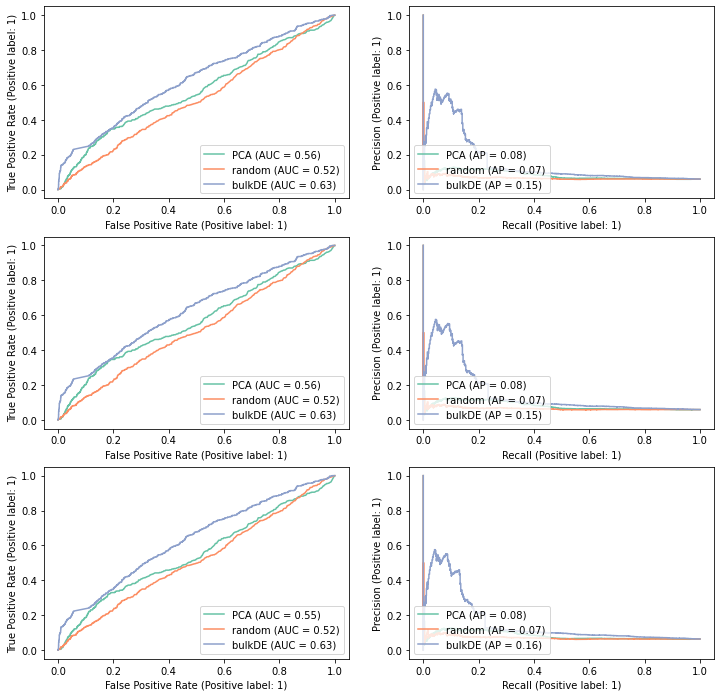

In [73]:

# get PR curve

curr_cell_type = "hepatocyte"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# get bulk DE genes

# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_hepatic
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)



fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


In [ ]:
a = proj_log2FC_df.iloc[np.argsort(proj_log2FC_df[0])[::-1]]
a.iloc[:30]

<ipython-input-72-23000f78beea>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(union_g

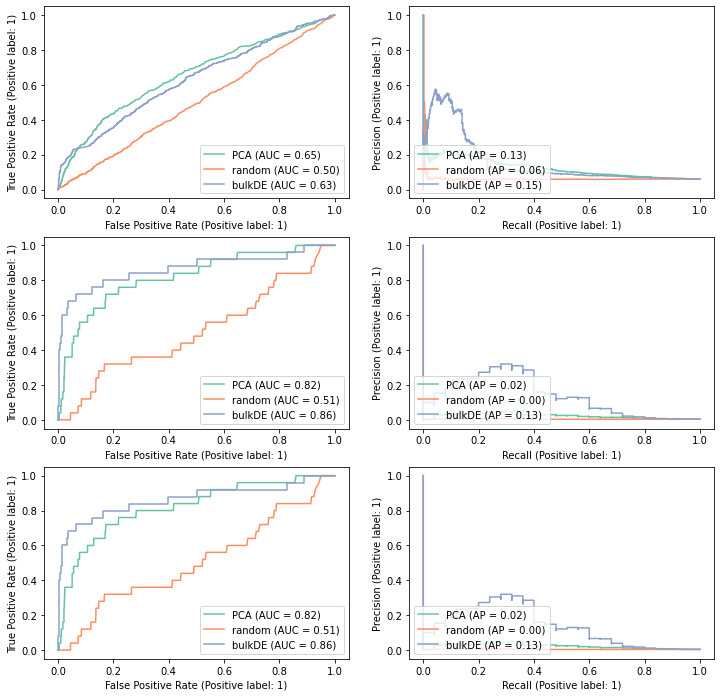

In [74]:
curr_cell_type = "hepatic_stellate"


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_hsc
extra_ref = Pub_DE_hsc


fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


<ipython-input-72-23000f78beea>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(union_g

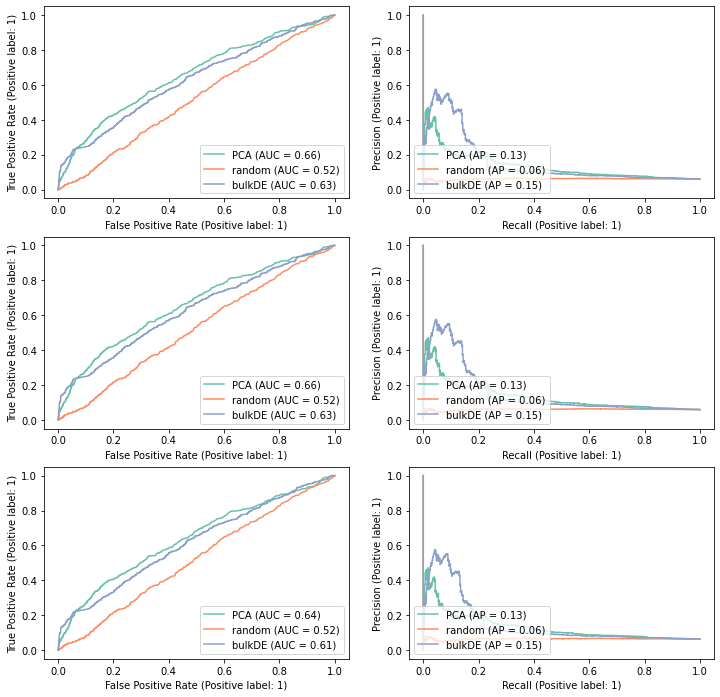

In [75]:

curr_cell_type = "hepatic_sinusoid"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_hepatic
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)


fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


<ipython-input-72-23000f78beea>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(union_g

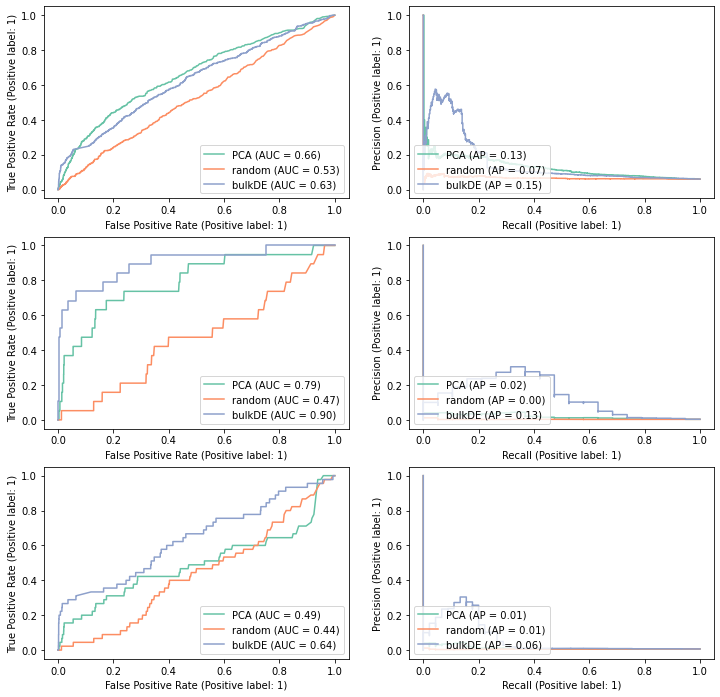

In [76]:

# get PR curve

curr_cell_type = "kupffer"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]

a = ["MIS18BP1", "CIT", "MYO5A"]

# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_kupffer
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)


fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()


<ipython-input-72-23000f78beea>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(union_g

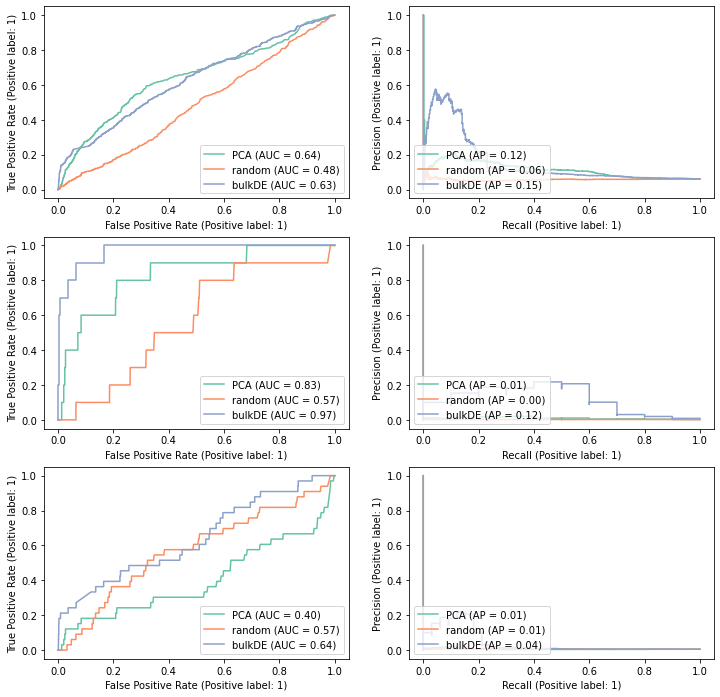

In [77]:

# get PR curve

curr_cell_type = "NK"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_immune
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)



fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()



<ipython-input-72-23000f78beea>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.isDE[np.where(np.isin(union_genes_cap, DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.hepaticDE[np.where(np.isin(union_genes_cap, ct_DE_ref))[0]] = 1
<ipython-input-72-23000f78beea>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.X_Y[np.where(np.isin(union_g

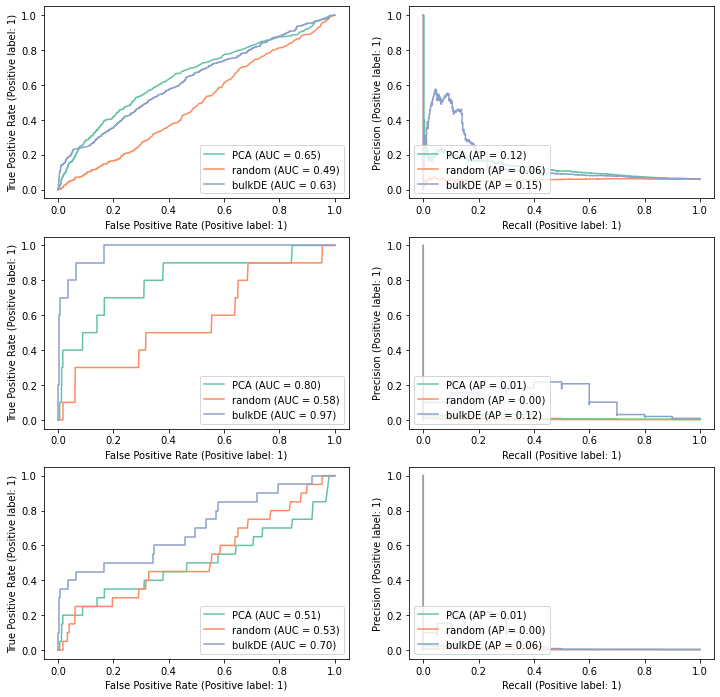

In [78]:

# get PR curve

curr_cell_type = "b_cell"

# get our DE genes
de_genes_curr = de_genes[curr_cell_type]
de_genes_curr = [x.upper() for x in de_genes_curr]


# set the reference genes
DE_ref = Pub_DE
ct_DE_ref = Pub_DE_immune
extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)



fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs, proj_log2FC_df = plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, 
                                    bulk_sig_df, curr_cell_type, DE_ref, ct_DE_ref, 
                                    extra_ref, axs, union_genes_cap)
fig.show()

